# Instalação de bibliotecas

In [ ]:
!pip install -U darts
!pip install optuna
!pip install openpyxl
!pip install lxml
!pip install ray
!pip install pyswarm

In [1]:
import os
import shutil
folders = ['projeto-da-graduacao-classes', 'classes']

for folder in folders:
  try:
    shutil.rmtree(folder)
    print('removed:', folder)
  except:
    pass

!git clone https://github.com/ellizeurs/projeto-da-graduacao-classes.git

os.rename('projeto-da-graduacao-classes', 'classes')

removed: classes
Cloning into 'projeto-da-graduacao-classes'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 281 (delta 177), reused 186 (delta 82), pack-reused 0
Receiving objects: 100% (281/281), 40.37 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (177/177), done.


# Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch

from darts.dataprocessing.transformers import Scaler
from darts.models import (
    ARIMA,
    FourTheta,
    NLinearModel,
    TFTModel,
    NHiTSModel,
)
from darts.metrics import mape

from sklearn.preprocessing import MinMaxScaler

from classes.const import DATE_FORMAT_STRING, VAL_START, TEST_START
from classes.functions import resample_month_series_in_week_series
from classes.metrics import sle
from classes import TimeSeries
from classes.models.preprocessing import Detrend
from classes.models.window import Takens
from classes.models import (
    NARX,
    DA_RNN,
    IDLN,
    IMP,
    MLP,
    RandomWalkModel,
)
from classes.metrics import Hurst, UTheil
from classes.functions import plot_series, plot_series_labels, plot_trend_line, eval_model

import optuna

from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

from pytorch_lightning.callbacks import Callback, EarlyStopping

from pyswarm import pso

# Criando o dataset

## Leitura da Tabela de Dados

In [2]:
df_biodiesel = pd.read_excel(
    "https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/ppidp/precos-medios-ponderados-semanais-2013.xls",
    usecols="A:B, D:I",
    skiprows=8,
    na_values=["***"],
)
df_biodiesel = df_biodiesel.rename(
    columns={df_biodiesel.columns[0]: "Produto", df_biodiesel.columns[1]: "Data", df_biodiesel.columns[7]: "Brasil"}
)
df_biodiesel = df_biodiesel.dropna(subset=["Data"])
df_biodiesel = df_biodiesel[df_biodiesel["Produto"] == "Biodiesel B-100 (R$/litro)"]
df_biodiesel = df_biodiesel.drop("Produto", axis=1)
df_biodiesel.reset_index(drop=True, inplace=True)
df_biodiesel

,Data,Norte,Nordeste,Centro-Oeste,Sul,Sudeste,Brasil
0,2022-01-03,6.58694,6.53524,6.63140,6.52017,6.42527,6.50281
1,2022-01-10,6.59247,6.54389,6.49987,6.49273,6.44492,6.49439
2,2022-01-17,6.59975,6.52692,6.63605,6.50669,6.48951,6.53165
3,2022-01-24,6.57902,6.53398,6.63996,6.48883,6.46100,6.5178
4,2022-01-31,6.71899,6.67343,6.69431,6.52320,6.50844,6.58144
...,...,...,...,...,...,...,...
127,2024-06-10,4.84877,5.03313,4.60784,4.62982,4.74864,4.75228
128,2024-06-17,4.98503,5.11313,4.90841,4.78222,4.94306,4.92817
129,2024-06-24,5.00430,5.24851,4.90230,4.86621,4.97412,4.99009
130,2024-07-01,5.06412,5.19255,4.86046,4.81466,4.94753,4.95293


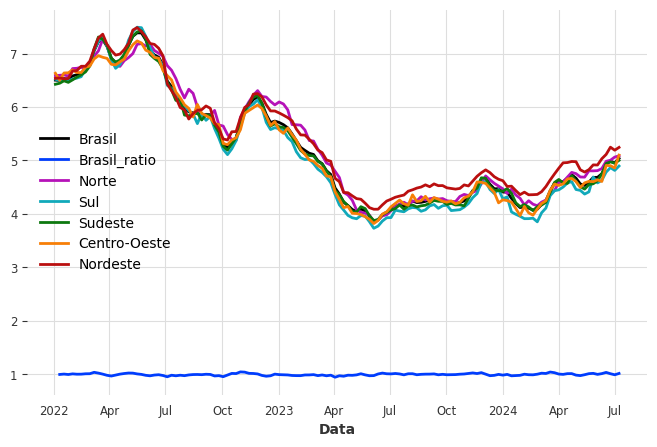

In [3]:
# Transformando o Dataframe em uma serie temporal do darts
series_national = TimeSeries.from_dataframe(df_biodiesel, "Data", "Brasil")
series_national_tx = series_national.ratio()
series_north = TimeSeries.from_dataframe(df_biodiesel, "Data", "Norte")
series_south = TimeSeries.from_dataframe(df_biodiesel, "Data", "Sul")
series_southeast = TimeSeries.from_dataframe(df_biodiesel, "Data", "Sudeste")
series_midwest = TimeSeries.from_dataframe(df_biodiesel, "Data", "Centro-Oeste")
series_northeast = TimeSeries.from_dataframe(df_biodiesel, "Data", "Nordeste")

plot_series(
    [
        series_national,
        series_national_tx,
        series_north,
        series_south,
        series_southeast,
        series_midwest,
        series_northeast,
    ]
)

In [4]:
df_soybean_oil = pd.read_excel('https://thedocs.worldbank.org/en/doc/5d903e848db1d1b83e0ec8f744e55570-0350012021/related/CMO-Historical-Data-Monthly.xlsx', sheet_name="Monthly Prices", skiprows = 6)
df_soybean_oil = df_soybean_oil.rename(columns={df_soybean_oil.columns[0]: 'Month', 'SOYBEAN_OIL': 'Soybean Oil'})
df_soybean_oil = df_soybean_oil[['Month', 'Soybean Oil']]
df_soybean_oil['Month'] = df_soybean_oil['Month'].apply(lambda x: pd.to_datetime(x, format='%YM%m'))
df_soybean_oil = resample_month_series_in_week_series("Monday", ["Soybean Oil"], df_soybean_oil, "Month")
df_soybean_oil

,Data,Soybean Oil
0,1960-01-04,204.00
1,1960-01-11,203.25
2,1960-01-18,202.50
3,1960-01-25,201.75
4,1960-02-01,201.00
...,...,...
3357,2024-05-06,988.00
3358,2024-05-13,993.67
3359,2024-05-20,999.34
3360,2024-05-27,1005.01


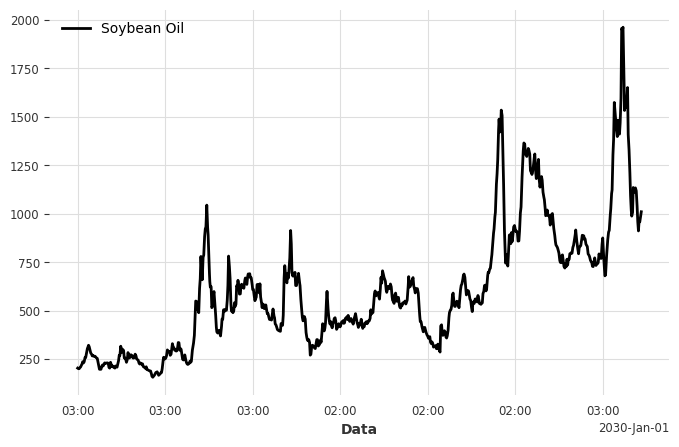

In [5]:
# Transformando o Dataframe em uma serie temporal do darts
soybean_oil = TimeSeries.from_dataframe(df_soybean_oil, "Data", "Soybean Oil")

plot_series(
    [
        soybean_oil,
    ]
)

In [6]:
# URL da página da web que contém a tabela HTML com um atributo "id"
url = 'https://www.indexmundi.com/commodities/?commodity=soybean-oil&months=360'

# Use a função read_html para importar a tabela HTML com base no atributo "id"
tabelas_html = pd.read_html(url, attrs={"id": "gvPrices"}, na_values=['-'])

df_soybean_oil_future = tabelas_html[0]  # Pode ser necessário ajustar o índice se houver mais de uma tabela com o mesmo atributo "id"
df_soybean_oil_future = df_soybean_oil_future.drop('Change', axis = 1)
df_soybean_oil_future = df_soybean_oil_future.rename(columns={df_soybean_oil_future.columns[0]: 'Mês', df_soybean_oil_future.columns[1]: 'Soybean Oil Future'})
df_soybean_oil_future['Mês'] = pd.to_datetime(df_soybean_oil_future['Mês'], format='%b %Y')
df_soybean_oil_future = resample_month_series_in_week_series("Monday", ["Soybean Oil Future"], df_soybean_oil_future, "Mês")
df_soybean_oil_future

,Data,Soybean Oil Future
0,1994-06-06,571.0000
1,1994-06-13,568.2500
2,1994-06-20,565.5000
3,1994-06-27,562.7500
4,1994-07-04,560.0000
...,...,...
1552,2024-03-04,964.9500
1553,2024-03-11,963.3525
1554,2024-03-18,961.7550
1555,2024-03-25,960.1575


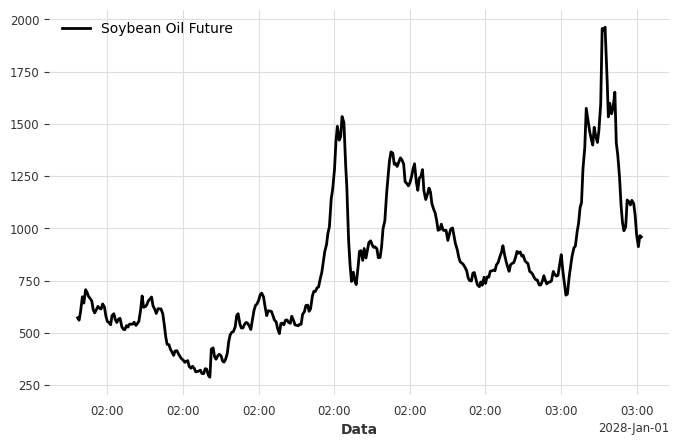

In [7]:
# Transformando o Dataframe em uma serie temporal do darts
soybean_oil_future = TimeSeries.from_dataframe(df_soybean_oil_future, "Data", "Soybean Oil Future")

plot_series(
    [
        soybean_oil_future,
    ]
)

## Tratamento dos dados - Série Original

### Visualização dos dados

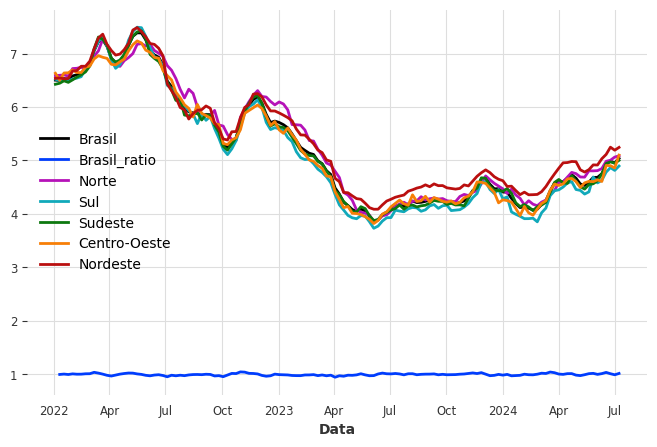

In [8]:
plot_series(
    [
        series_national,
        series_national_tx,
        series_north,
        series_south,
        series_southeast,
        series_midwest,
        series_northeast,
    ]
)

#### Verificação da Sazonalidade

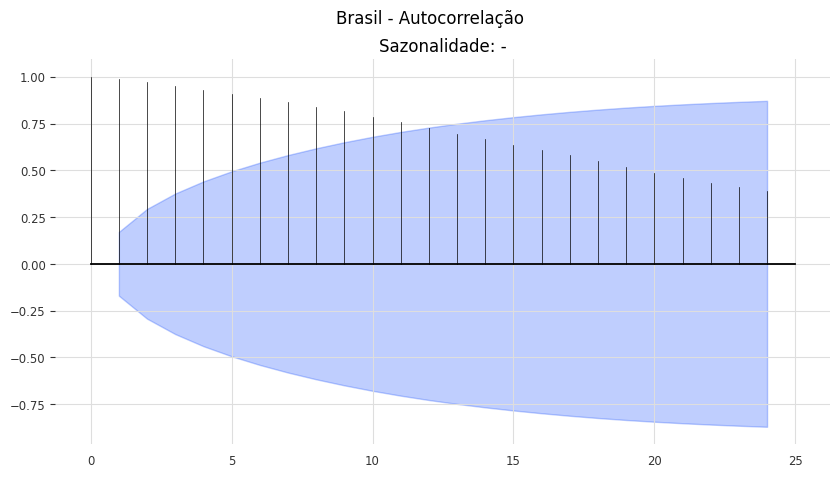

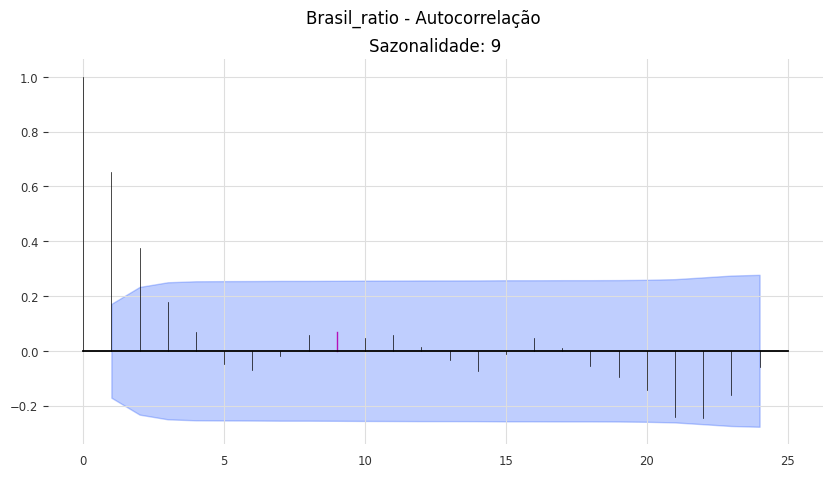

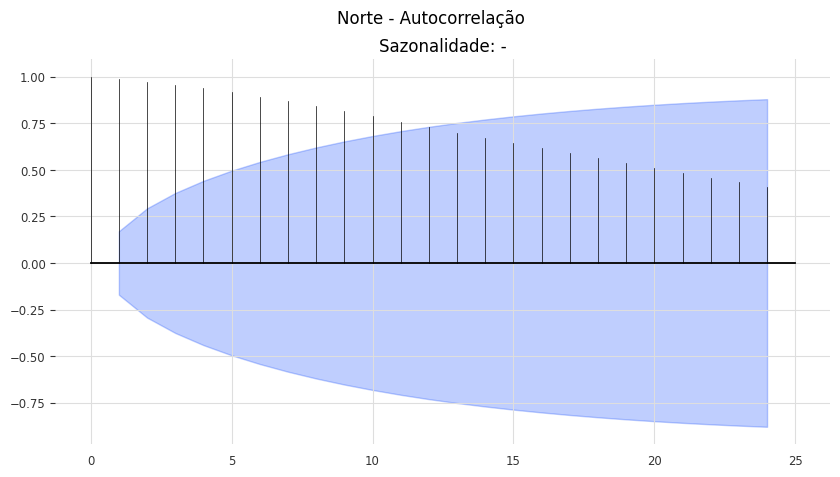

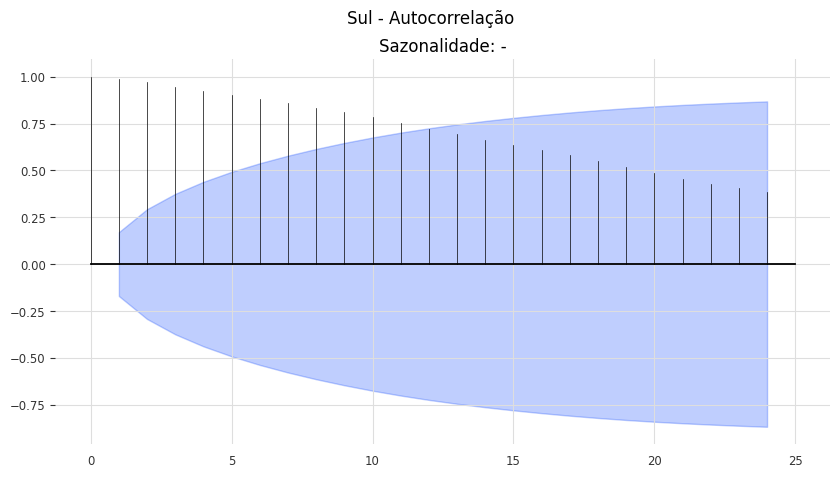

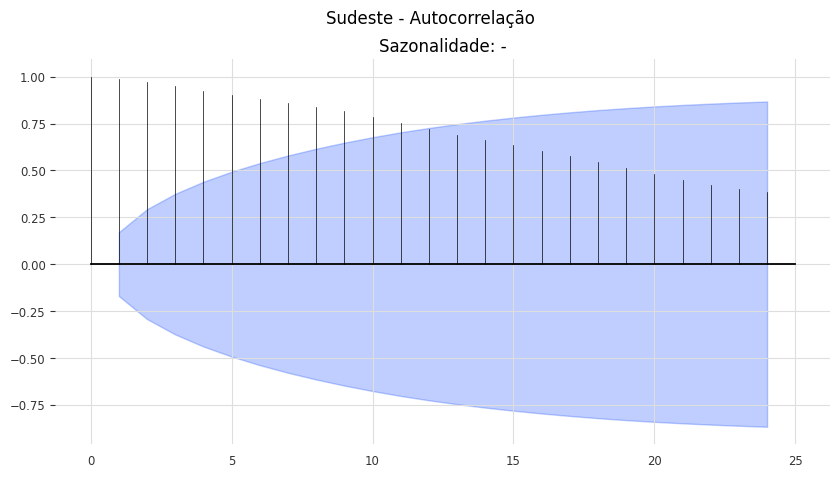

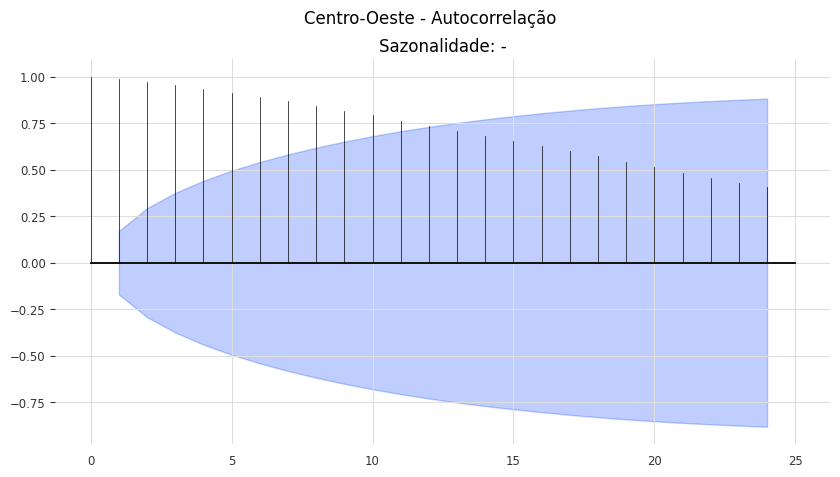

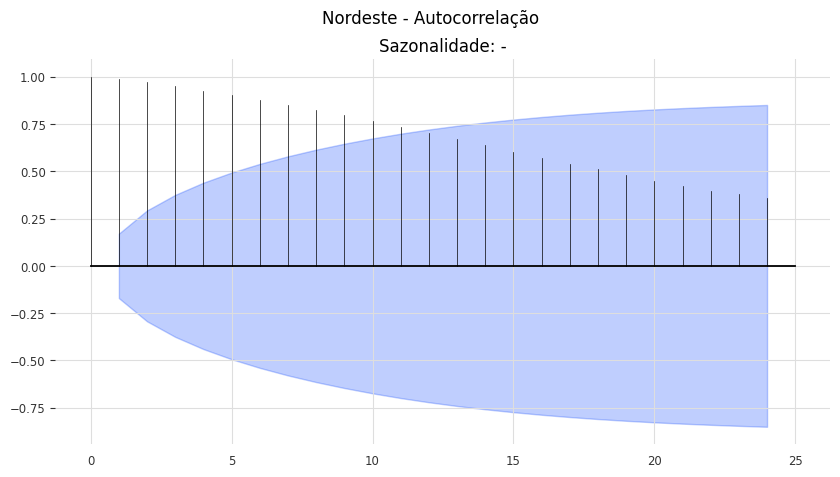

In [9]:
series_national.plot_acf()
series_national_tx.plot_acf()
series_north.plot_acf()
series_south.plot_acf()
series_southeast.plot_acf()
series_midwest.plot_acf()
series_northeast.plot_acf()


#### Verificação de Ciclos

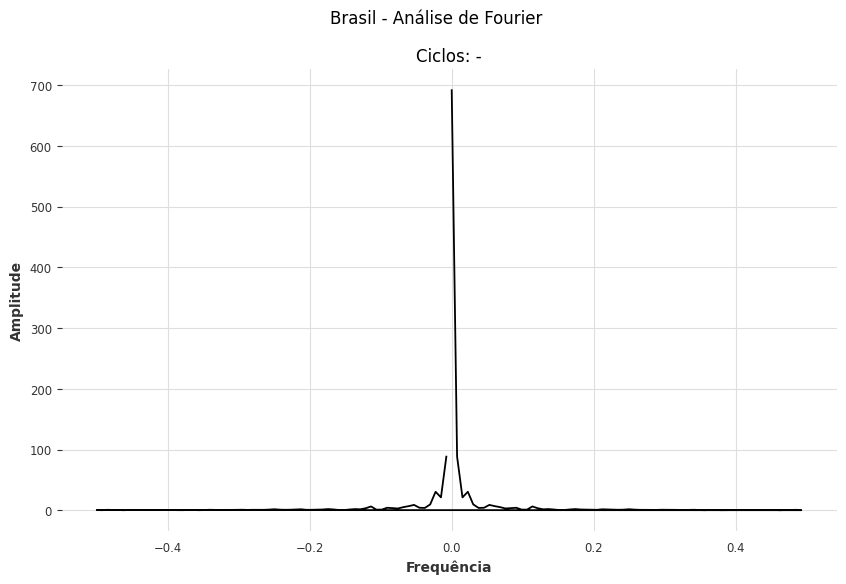

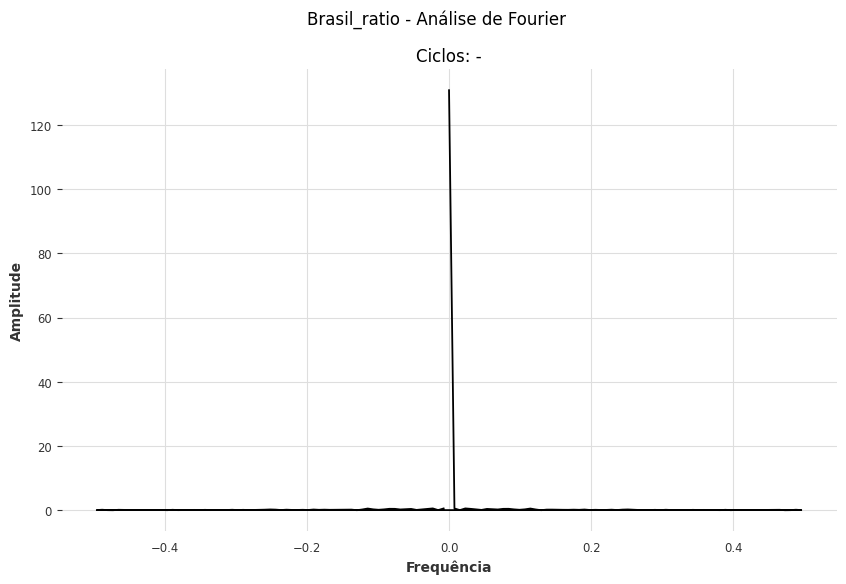

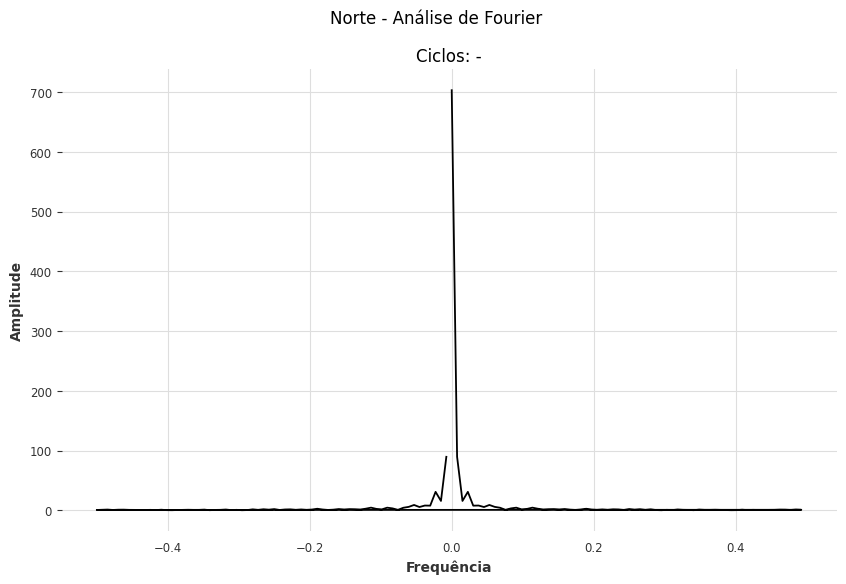

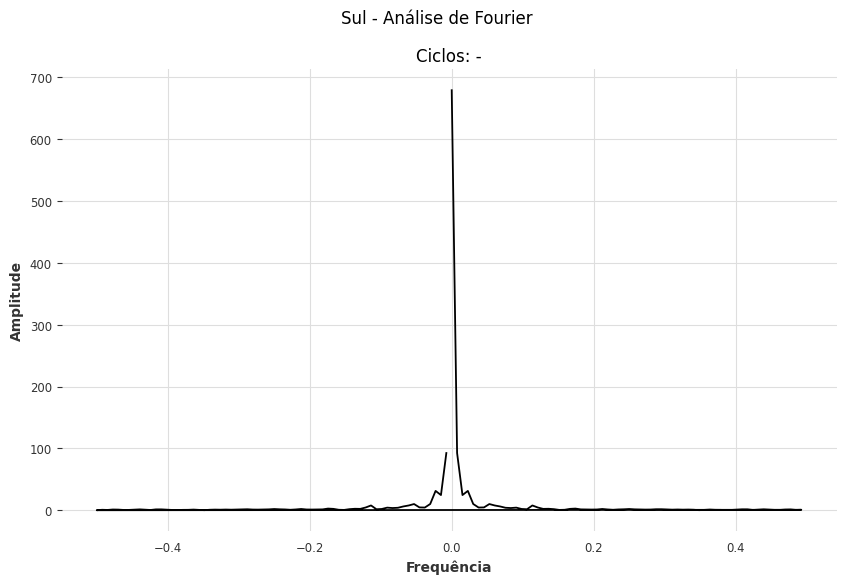

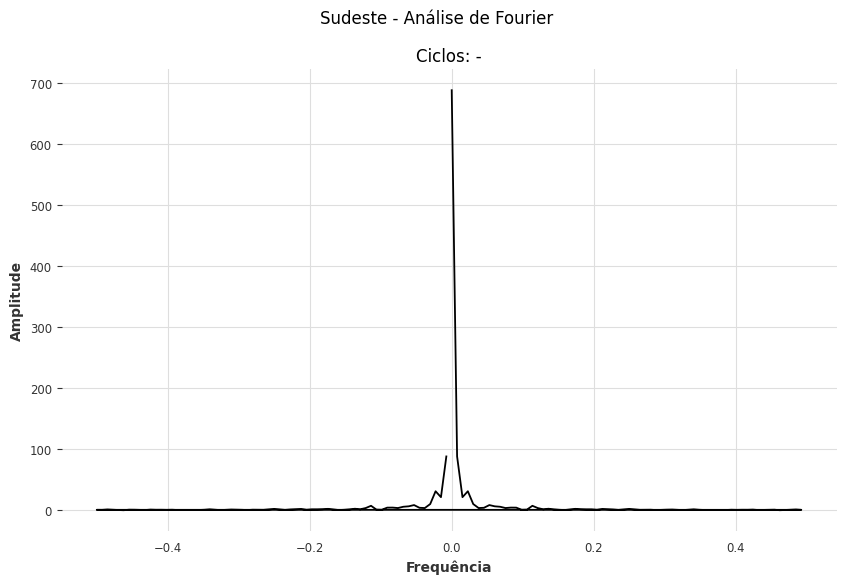

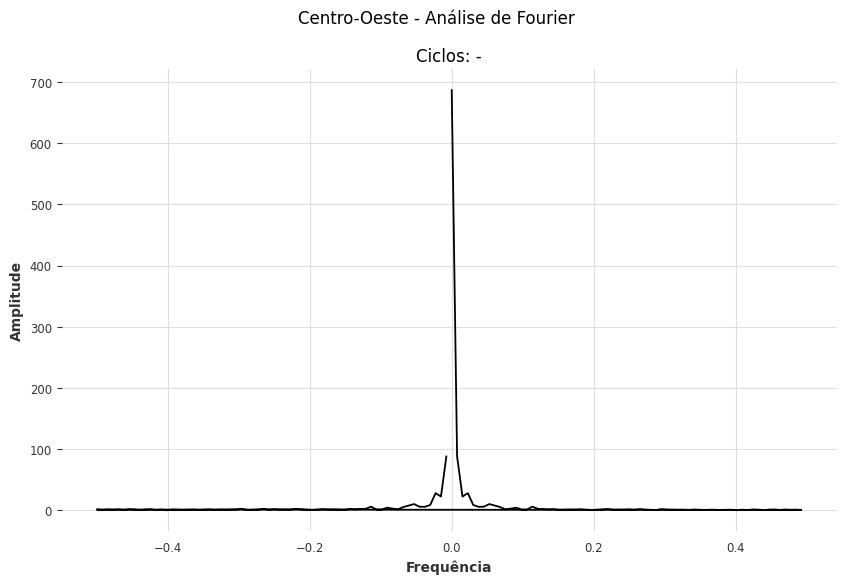

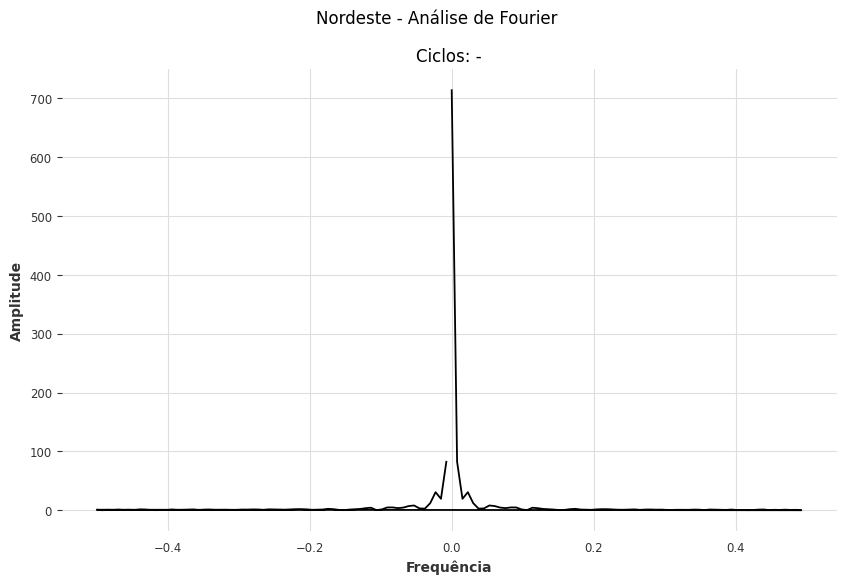

In [10]:
series_national.plot_fourier_analisys()
series_national_tx.plot_fourier_analisys()
series_north.plot_fourier_analisys()
series_south.plot_fourier_analisys()
series_southeast.plot_fourier_analisys()
series_midwest.plot_fourier_analisys()
series_northeast.plot_fourier_analisys()


#### Coeficiente de Hurst

In [11]:
hurst = Hurst()

H, HDescription = hurst.calculate(series_national)
print("Coeficiente de Hurst = {:.2f} - {}".format(H, HDescription))

Coeficiente de Hurst = 0.73 - Persistente


#### Matriz de Correlação

In [12]:
np.corrcoef([
    series_national.slice(
        max(series_national.start_time(),soybean_oil.start_time(),soybean_oil_future.start_time()), 
        min(series_national.end_time(),soybean_oil.end_time(),soybean_oil_future.end_time())
    ).univariate_values(), 
    series_north.slice(
        max(series_national.start_time(),soybean_oil.start_time(),soybean_oil_future.start_time()), 
        min(series_national.end_time(),soybean_oil.end_time(),soybean_oil_future.end_time())
    ).univariate_values(), 
    series_south.slice(
        max(series_national.start_time(),soybean_oil.start_time(),soybean_oil_future.start_time()), 
        min(series_national.end_time(),soybean_oil.end_time(),soybean_oil_future.end_time())
    ).univariate_values(),
    series_southeast.slice(
        max(series_national.start_time(),soybean_oil.start_time(),soybean_oil_future.start_time()), 
        min(series_national.end_time(),soybean_oil.end_time(),soybean_oil_future.end_time())
    ).univariate_values(),
    series_midwest.slice(
        max(series_national.start_time(),soybean_oil.start_time(),soybean_oil_future.start_time()), 
        min(series_national.end_time(),soybean_oil.end_time(),soybean_oil_future.end_time())
    ).univariate_values(),
    series_northeast.slice(
        max(series_national.start_time(),soybean_oil.start_time(),soybean_oil_future.start_time()), 
        min(series_national.end_time(),soybean_oil.end_time(),soybean_oil_future.end_time())
    ).univariate_values(),
    soybean_oil.slice(
        max(series_national.start_time(),soybean_oil.start_time(),soybean_oil_future.start_time()), 
        min(series_national.end_time(),soybean_oil.end_time(),soybean_oil_future.end_time())
    ).univariate_values(),
    soybean_oil_future.slice(
        max(series_national.start_time(),soybean_oil.start_time(),soybean_oil_future.start_time()), 
        min(series_national.end_time(),soybean_oil.end_time(),soybean_oil_future.end_time())
    ).univariate_values(),
])

array([[1.        , 0.99117946, 0.99902207, 0.99933316, 0.99674443,
        0.99781922, 0.93759966, 0.93759966],
       [0.99117946, 1.        , 0.98736418, 0.98824674, 0.9895263 ,
        0.98806518, 0.91682587, 0.91682587],
       [0.99902207, 0.98736418, 1.        , 0.99823866, 0.99529202,
        0.99582853, 0.93995089, 0.93995089],
       [0.99933316, 0.98824674, 0.99823866, 1.        , 0.99462224,
        0.99685204, 0.93733252, 0.93733252],
       [0.99674443, 0.9895263 , 0.99529202, 0.99462224, 1.        ,
        0.99302146, 0.93926049, 0.93926049],
       [0.99781922, 0.98806518, 0.99582853, 0.99685204, 0.99302146,
        1.        , 0.93228786, 0.93228786],
       [0.93759966, 0.91682587, 0.93995089, 0.93733252, 0.93926049,
        0.93228786, 1.        , 1.        ],
       [0.93759966, 0.91682587, 0.93995089, 0.93733252, 0.93926049,
        0.93228786, 1.        , 1.        ]])

### Divisão dos Conjuntos de Treino, Validação e Teste

In [13]:
train_tx, val_tx, test_tx = series_national_tx.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)
train, val, test = series_national.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)
train_north, val_north, test_north = series_north.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)
train_south, val_south, test_south = series_south.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)
train_southeast, val_southeast, test_southeast = series_southeast.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)
train_midwest, val_midwest, test_midwest = series_midwest.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)
train_northeast, val_northeast, test_northeast = series_northeast.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)

print(
    f"Treinamento: {train.time_index[0].strftime(DATE_FORMAT_STRING)} - {train.time_index[- 1].strftime(DATE_FORMAT_STRING)}"
)
print(
    f"Validação  : {val.time_index[0].strftime(DATE_FORMAT_STRING)} - {val.time_index[-1].strftime(DATE_FORMAT_STRING)}"
)
print(
    f"Teste      : {test.time_index[0].strftime(DATE_FORMAT_STRING)} - {test.time_index[-1].strftime(DATE_FORMAT_STRING)}"
)

Treinamento: 03/01/2022 - 23/01/2023
Validação  : 30/01/2023 - 10/07/2023
Teste      : 17/07/2023 - 08/07/2024


In [14]:
train_soybean_oil, val_soybean_oil, test_soybean_oil = soybean_oil.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)

print(
    f"Treinamento: {train_soybean_oil.time_index[0].strftime(DATE_FORMAT_STRING)} - {train_soybean_oil.time_index[- 1].strftime(DATE_FORMAT_STRING)}"
)
print(
    f"Validação  : {val_soybean_oil.time_index[0].strftime(DATE_FORMAT_STRING)} - {val_soybean_oil.time_index[-1].strftime(DATE_FORMAT_STRING)}"
)
print(
    f"Teste      : {test_soybean_oil.time_index[0].strftime(DATE_FORMAT_STRING)} - {test_soybean_oil.time_index[-1].strftime(DATE_FORMAT_STRING)}"
)

Treinamento: 04/01/1960 - 23/01/2023
Validação  : 30/01/2023 - 10/07/2023
Teste      : 17/07/2023 - 03/06/2024


In [15]:
train_soybean_oil_future, val_soybean_oil_future, test_soybean_oil_future = soybean_oil_future.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)

print(
    f"Treinamento: {train_soybean_oil_future.time_index[0].strftime(DATE_FORMAT_STRING)} - {train_soybean_oil_future.time_index[- 1].strftime(DATE_FORMAT_STRING)}"
)
print(
    f"Validação  : {val_soybean_oil_future.time_index[0].strftime(DATE_FORMAT_STRING)} - {val_soybean_oil_future.time_index[-1].strftime(DATE_FORMAT_STRING)}"
)
print(
    f"Teste      : {test_soybean_oil_future.time_index[0].strftime(DATE_FORMAT_STRING)} - {test_soybean_oil_future.time_index[-1].strftime(DATE_FORMAT_STRING)}"
)

Treinamento: 06/06/1994 - 23/01/2023
Validação  : 30/01/2023 - 10/07/2023
Teste      : 17/07/2023 - 01/04/2024


### Aplicando o filtro de média móvel

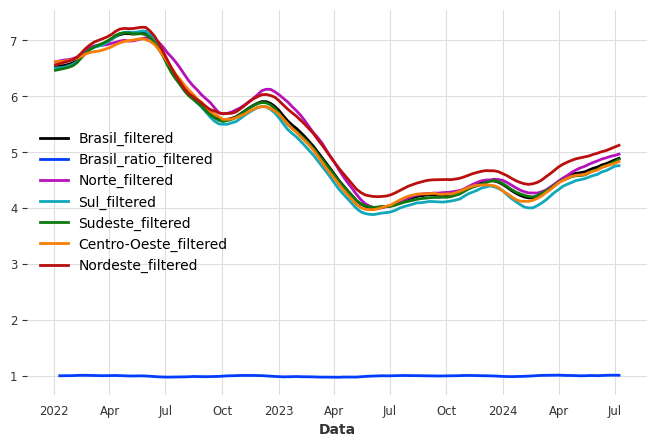

In [16]:
series_national_filtered = series_national.filter()[0]
series_national_tx_filtered = series_national_tx.filter()[0]
series_north_filtered = series_north.filter()[0]
series_south_filtered = series_south.filter()[0]
series_southeast_filtered = series_southeast.filter()[0]
series_midwest_filtered = series_midwest.filter()[0]
series_northeast_filtered = series_northeast.filter()[0]

plot_series(
    [
        series_national_filtered,
        series_national_tx_filtered,
        series_north_filtered,
        series_south_filtered,
        series_southeast_filtered,
        series_midwest_filtered,
        series_northeast_filtered,
    ]
)

#### Divisão dos Conjuntos de Treino, Validação e Teste

In [17]:
(
    train_tx_filtered,
    val_tx_filtered,
    test_tx_filtered,
) = series_national_tx_filtered.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)
train_filtered, val_filtered, test_filtered = series_national_filtered.split(
    [pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)]
)
(
    train_north_filtered,
    val_north_filtered,
    test_north_filtered,
) = series_north_filtered.split([pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)])
(
    train_south_filtered,
    val_south_filtered,
    test_south_filtered,
) = series_south_filtered.split([pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)])
(
    train_southeast_filtered,
    val_southeast_filtered,
    test_southeast_filtered,
) = series_southeast_filtered.split([pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)])
(
    train_midwest_filtered,
    val_midwest_filtered,
    test_midwest_filtered,
) = series_midwest_filtered.split([pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)])
(
    train_northeast_filtered,
    val_northeast_filtered,
    test_northeast_filtered,
) = series_northeast_filtered.split([pd.Timestamp(VAL_START), pd.Timestamp(TEST_START)])

print(
    f"Treinamento: {train_filtered.time_index[0].strftime(DATE_FORMAT_STRING)} - {train_filtered.time_index[- 1].strftime(DATE_FORMAT_STRING)}"
)
print(
    f"Validação  : {val_filtered.time_index[0].strftime(DATE_FORMAT_STRING)} - {val_filtered.time_index[-1].strftime(DATE_FORMAT_STRING)}"
)
print(
    f"Teste      : {test_filtered.time_index[0].strftime(DATE_FORMAT_STRING)} - {test_filtered.time_index[-1].strftime(DATE_FORMAT_STRING)}"
)

Treinamento: 03/01/2022 - 23/01/2023
Validação  : 30/01/2023 - 10/07/2023
Teste      : 17/07/2023 - 08/07/2024


#### Novamente verificando sazonalidade

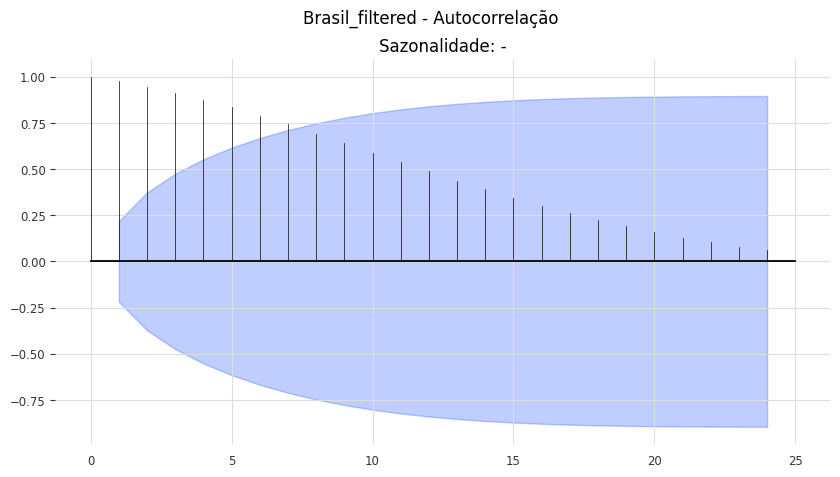

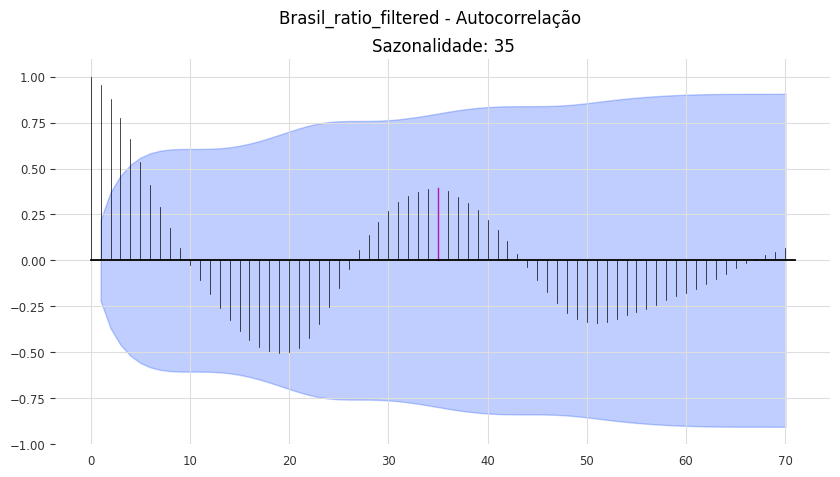

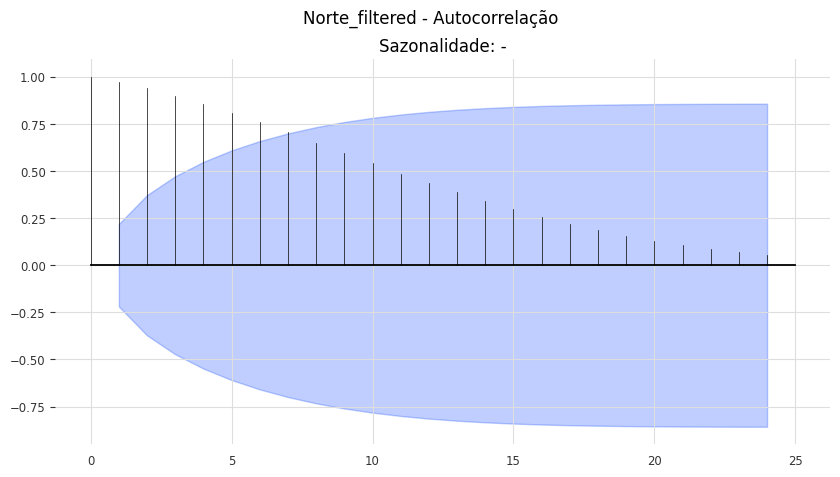

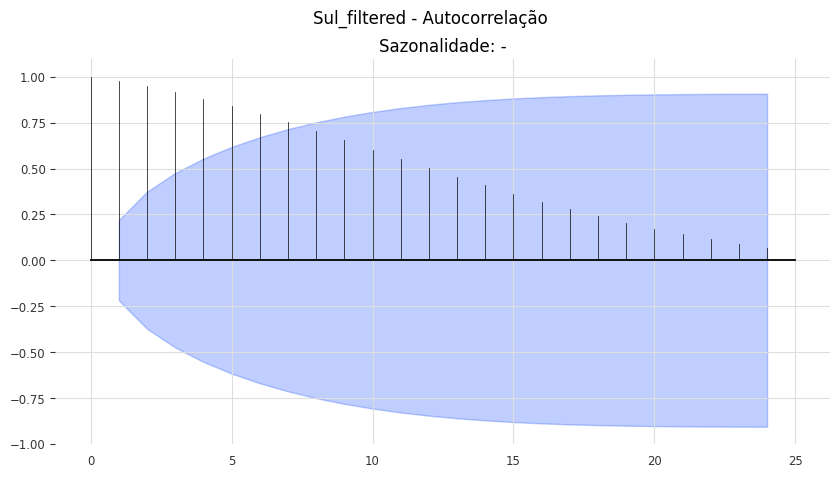

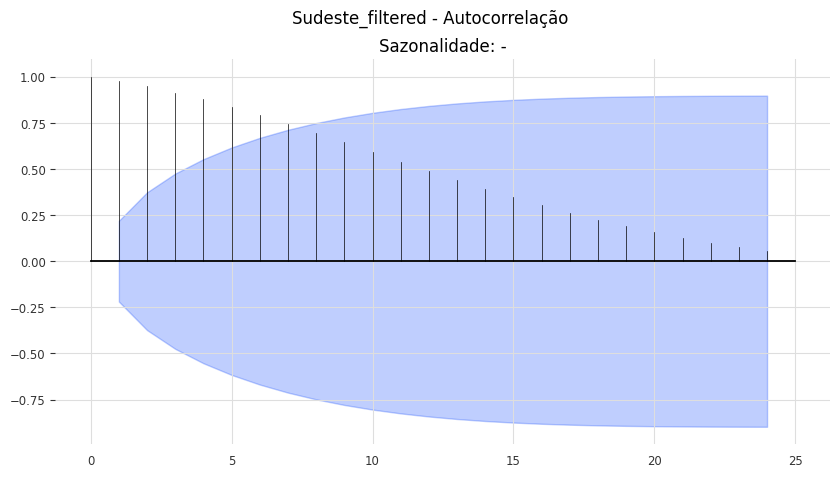

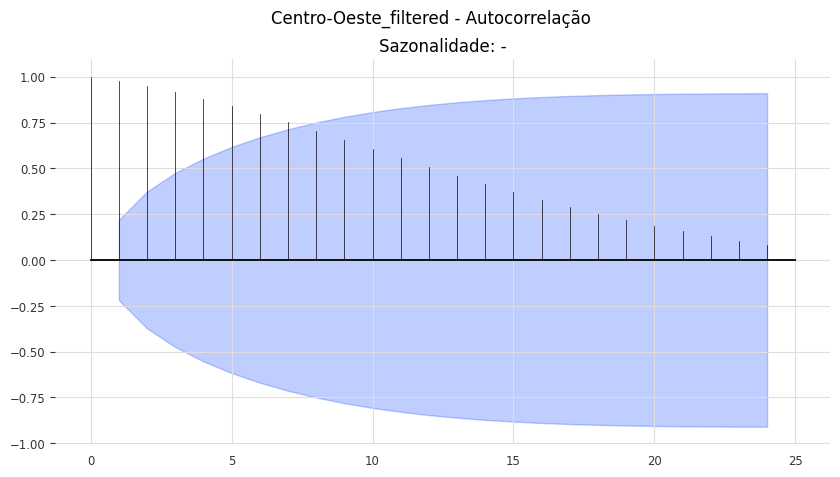

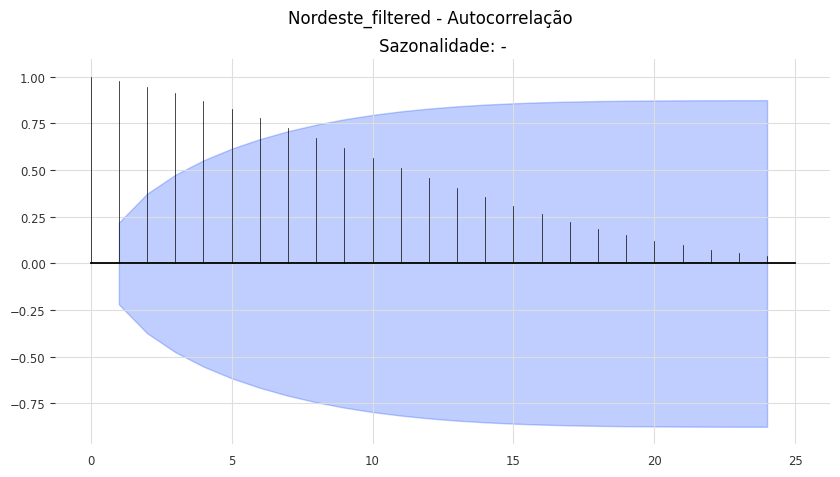

In [18]:
series_national_filtered.slice(train.start_time(), val.end_time()).plot_acf()
series_national_tx_filtered.slice(train.start_time(), val.end_time()).plot_acf()
series_north_filtered.slice(train.start_time(), val.end_time()).plot_acf()
series_south_filtered.slice(train.start_time(), val.end_time()).plot_acf()
series_southeast_filtered.slice(train.start_time(), val.end_time()).plot_acf()
series_midwest_filtered.slice(train.start_time(), val.end_time()).plot_acf()
series_northeast_filtered.slice(train.start_time(), val.end_time()).plot_acf()


#### Novamente verificando ciclos

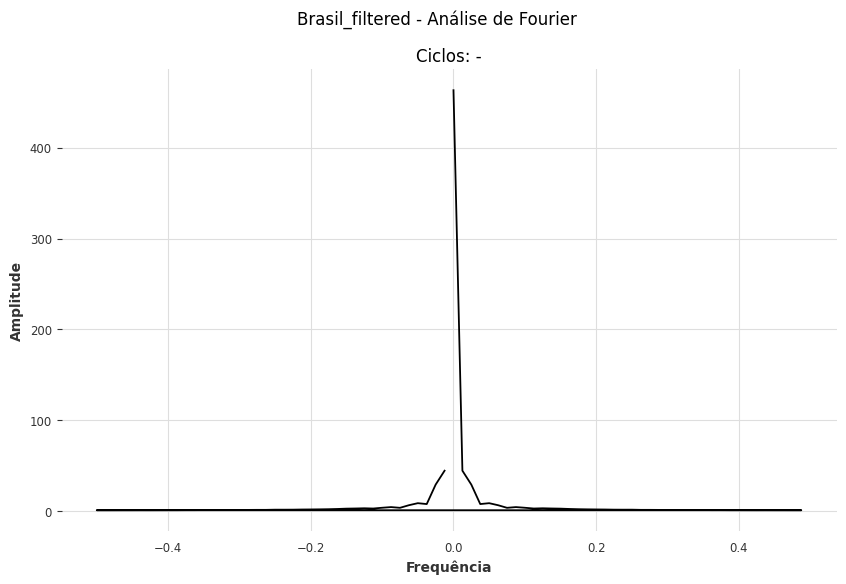

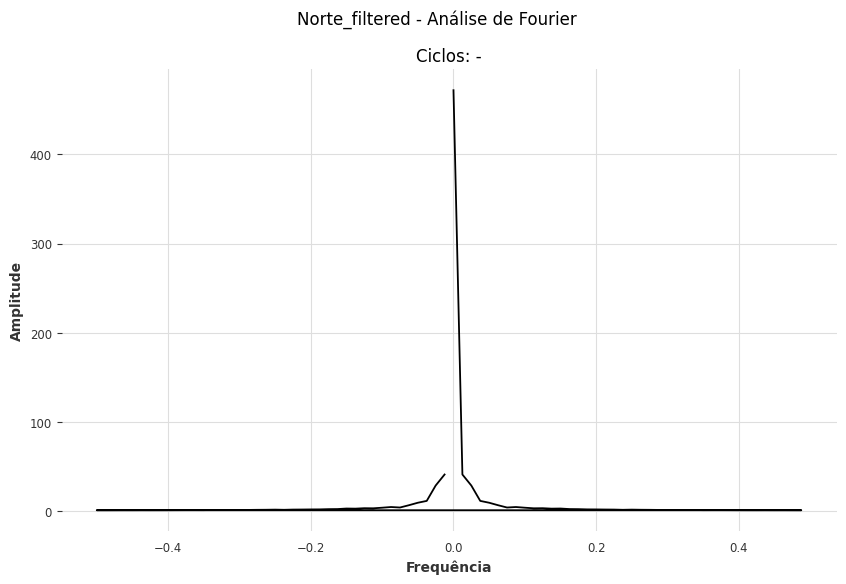

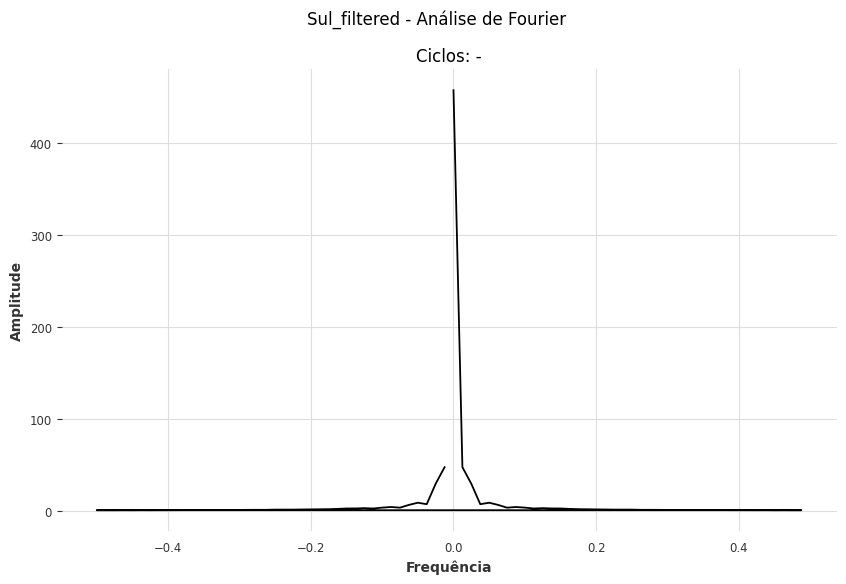

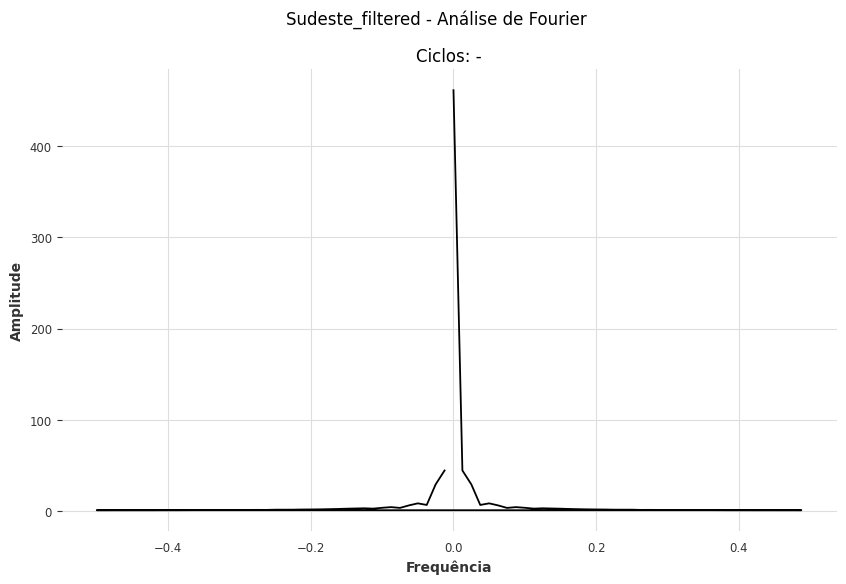

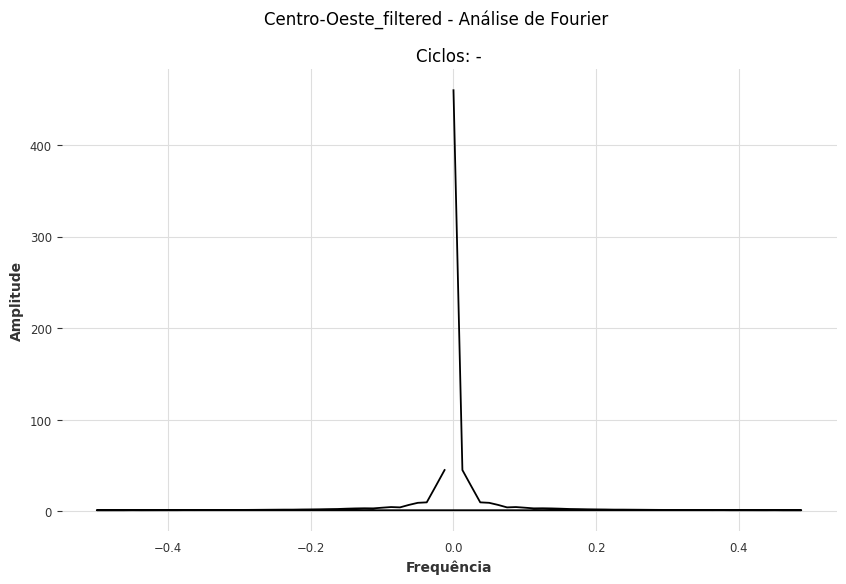

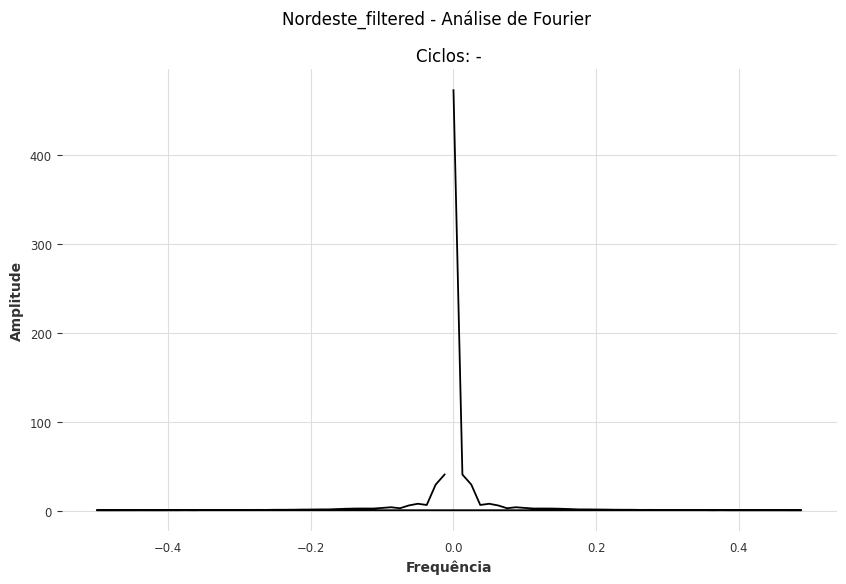

In [19]:
series_national_filtered.slice(train.start_time(), val.end_time()).plot_fourier_analisys()
series_north_filtered.slice(train.start_time(), val.end_time()).plot_fourier_analisys()
series_south_filtered.slice(train.start_time(), val.end_time()).plot_fourier_analisys()
series_southeast_filtered.slice(train.start_time(), val.end_time()).plot_fourier_analisys()
series_midwest_filtered.slice(train.start_time(), val.end_time()).plot_fourier_analisys()
series_northeast_filtered.slice(train.start_time(), val.end_time()).plot_fourier_analisys()


# Treinando o Modelo

## ARIMA

### Brasil

In [ ]:
models_arima = []

for p in range(12, 30, 4):
    for d in range(1, 3):
        for q in range(0, 5, 2):
            for s in range(0, 30, 5):
                try:
                    model = ARIMA(
                        p=p, 
                        d=d, 
                        seasonal_order=(
                            0, 
                            0, 
                            q, 
                            s
                        ),
                    )
                    model.fit(train_scaled)
                    pred_series, mape_arima, sle_arima = eval_model(
                        model,
                        len(val_scaled),
                        series_national_scaled.slice(train.start_time(), val.end_time()),
                        val_scaled,
                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                        plot = False,
                    )
                    uTheil = UTheil()
                    u1_arima = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                    u2_arima = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                    print({
                        'MAPE': mape_arima,
                        'SLE': sle_arima,
                        'U1': u1_arima,
                        'U2': u1_arima,
                        'p': p,
                        'd': d,
                        'q': q,
                        's': s,
                    })
                    models_arima.append({
                        'MAPE': mape_arima,
                        'SLE': sle_arima,
                        'U1': u1_arima,
                        'U2': u1_arima,
                        'p': p,
                        'd': d,
                        'q': q,
                        's': s,
                    })
                except:
                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_arima in [
                            {
                                'name': i,
                                'd': min(models_arima, key=lambda d: d[i])['d'],
                                'p': min(models_arima, key=lambda d: d[i])['p'],
                                'q': min(models_arima, key=lambda d: d[i])['q'],
                                's': min(models_arima, key=lambda d: d[i])['s'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_arima['name'])
    model = ARIMA(
        p=best_model_arima['p'],
        d=best_model_arima['d'],
        seasonal_order=(
            0, 
            0, 
            best_model_arima['q'], 
            best_model_arima['s']
        ),
    )
    model.fit(train_scaled)
    pred_series, mape_arima, sle_arima = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_arima = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_arima = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_arima)
    print('U2: ', u2_arima)
    print('')
    print('')

### Brasil (detrend)

In [ ]:
models_arima = []

for p in range(12, 30, 4):
    for d in range(1, 3):
        for q in range(0, 5, 2):
            for s in range(0, 30, 5):
                try:
                    model = ARIMA(
                        p=p, 
                        d=d, 
                        seasonal_order=(
                            0, 
                            0, 
                            q, 
                            s
                        ),
                    )
                    model.fit(train_detrend_scaled)
                    pred_series, mape_arima, sle_arima = eval_model(
                        model,
                        len(val_detrend_scaled),
                        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                        val_detrend_scaled,
                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                        plot = False,
                    )
                    uTheil = UTheil()
                    u1_arima = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                    u2_arima = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                    print({
                        'MAPE': mape_arima,
                        'SLE': sle_arima,
                        'U1': u1_arima,
                        'U2': u1_arima,
                        'p': p,
                        'd': d,
                        'q': q,
                        's': s,
                    })
                    models_arima.append({
                        'MAPE': mape_arima,
                        'SLE': sle_arima,
                        'U1': u1_arima,
                        'U2': u1_arima,
                        'p': p,
                        'd': d,
                        'q': q,
                        's': s,
                    })
                except:
                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_arima in [
                            {
                                'name': i,
                                'd': min(models_arima, key=lambda d: d[i])['d'],
                                'p': min(models_arima, key=lambda d: d[i])['p'],
                                'q': min(models_arima, key=lambda d: d[i])['q'],
                                's': min(models_arima, key=lambda d: d[i])['s'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_arima['name'])
    model = ARIMA(
        p=best_model_arima['p'],
        d=best_model_arima['d'],
        seasonal_order=(
            0, 
            0, 
            best_model_arima['q'], 
            best_model_arima['s']
        ),
    )
    model.fit(train_detrend_scaled)
    pred_series, mape_arima, sle_arima = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_arima = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_arima = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_arima)
    print('U2: ', u2_arima)
    print('')
    print('')

### Brasil (filtered)

In [ ]:
models_arima = []

for p in range(12, 50, 4):
    for d in range(1, 3):
        for q in range(0, 5, 2):
            for s in range(0, 30, 5):
                try:
                    model = ARIMA(
                        p=p, 
                        d=d, 
                        seasonal_order=(
                            0, 
                            0, 
                            q, 
                            s
                        ),
                    )
                    model.fit(train_filtered_scaled)
                    pred_series, mape_arima, sle_arima = eval_model(
                        model,
                        len(val_filtered_scaled),
                        series_national_filtered_scaled.slice(train.start_time(), val.end_time()),
                        val_filtered_scaled,
                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                        plot = False,
                    )
                    uTheil = UTheil()
                    u1_arima = uTheil.calculateU1(val_filtered_scaled, pred_series[:len(val)])
                    u2_arima = uTheil.calculateU2(val_filtered_scaled, pred_series[:len(val)])
                    print({
                        'MAPE': mape_arima,
                        'SLE': sle_arima,
                        'U1': u1_arima,
                        'U2': u1_arima,
                        'p': p,
                        'd': d,
                        'q': q,
                        's': s,
                    })
                    models_arima.append({
                        'MAPE': mape_arima,
                        'SLE': sle_arima,
                        'U1': u1_arima,
                        'U2': u1_arima,
                        'p': p,
                        'd': d,
                        'q': q,
                        's': s,
                    })
                except:
                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_arima in [
                            {
                                'name': i,
                                'd': min(models_arima, key=lambda d: d[i])['d'],
                                'p': min(models_arima, key=lambda d: d[i])['p'],
                                'q': min(models_arima, key=lambda d: d[i])['q'],
                                's': min(models_arima, key=lambda d: d[i])['s'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_arima['name'])
    model = ARIMA(
        p=best_model_arima['p'],
        d=best_model_arima['d'],
        seasonal_order=(
            0, 
            0, 
            best_model_arima['q'], 
            best_model_arima['s']
        ),
    )
    model.fit(train_filtered_scaled)
    pred_series, mape_arima, sle_arima = eval_model(
        model,
        len(val_filtered_scaled),
        series_national_filtered_scaled.slice(train.start_time(), val.end_time()),
        val_filtered_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_arima = uTheil.calculateU1(val_filtered_scaled, pred_series[:len(val)])
    u2_arima = uTheil.calculateU2(val_filtered_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_arima)
    print('U2: ', u2_arima)
    print('')
    print('')

### Brasil (filtered/detrend)

In [ ]:
models_arima = []

for p in range(12, 30, 4):
    for d in range(1, 3):
        for q in range(0, 5, 2):
            for s in range(0, 30, 5):
                try:
                    model = ARIMA(
                        p=p, 
                        d=d, 
                        seasonal_order=(
                            0, 
                            0, 
                            q, 
                            s
                        ),
                    )
                    model.fit(train_detrend_filtered_scaled)
                    pred_series, mape_arima, sle_arima = eval_model(
                        model,
                        len(val_detrend_filtered_scaled),
                        series_national_detrend_filtered_scaled.slice(train.start_time(), val.end_time()),
                        val_detrend_filtered_scaled,
                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                        plot = False,
                    )
                    uTheil = UTheil()
                    u1_arima = uTheil.calculateU1(val_detrend_filtered_scaled, pred_series[:len(val)])
                    u2_arima = uTheil.calculateU2(val_detrend_filtered_scaled, pred_series[:len(val)])
                    print({
                        'MAPE': mape_arima,
                        'SLE': sle_arima,
                        'U1': u1_arima,
                        'U2': u1_arima,
                        'p': p,
                        'd': d,
                        'q': q,
                        's': s,
                    })
                    models_arima.append({
                        'MAPE': mape_arima,
                        'SLE': sle_arima,
                        'U1': u1_arima,
                        'U2': u1_arima,
                        'p': p,
                        'd': d,
                        'q': q,
                        's': s,
                    })
                except:
                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_arima in [
                            {
                                'name': i,
                                'd': min(models_arima, key=lambda d: d[i])['d'],
                                'p': min(models_arima, key=lambda d: d[i])['p'],
                                'q': min(models_arima, key=lambda d: d[i])['q'],
                                's': min(models_arima, key=lambda d: d[i])['s'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_arima['name'])
    model = ARIMA(
        p=best_model_arima['p'],
        d=best_model_arima['d'],
        seasonal_order=(
            0, 
            0, 
            best_model_arima['q'], 
            best_model_arima['s']
        ),
    )
    model.fit(train_detrend_filtered_scaled)
    pred_series, mape_arima, sle_arima = eval_model(
        model,
        len(val_detrend_filtered_scaled),
        series_national_detrend_filtered_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_filtered_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_arima = uTheil.calculateU1(val_detrend_filtered_scaled, pred_series[:len(val)])
    u2_arima = uTheil.calculateU2(val_detrend_filtered_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_arima)
    print('U2: ', u2_arima)
    print('')
    print('')

## 4Theta

### Brasil (taxa)

In [ ]:
models_4theta = []

for theta in [i / 10 for i in range(3, 21)]:
    for seasonality_period in range(7, 10, 1):
        try:
            model = FourTheta(
                theta=theta, 
                seasonality_period=seasonality_period,
            )
            model.fit(train_tx)
            pred_series, mape_4theta, sle_4theta = eval_model(
                model,
                len(val_tx),
                series_national_tx.slice(train.start_time(), val.end_time()),
                val_tx,
                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                plot = False,
            )
            uTheil = UTheil()
            u1_4theta = uTheil.calculateU1(val_tx, pred_series[:len(val)])
            u2_4theta = uTheil.calculateU2(val_tx, pred_series[:len(val)])
            print({
                'MAPE': mape_4theta,
                'SLE': sle_4theta,
                'U1': u1_4theta,
                'U2': u1_4theta,
                'theta': theta,
                'seasonality_period': seasonality_period,
            })
            models_4theta.append({
                'MAPE': mape_4theta,
                'SLE': sle_4theta,
                'U1': u1_4theta,
                'U2': u1_4theta,
                'theta': theta,
                'seasonality_period': seasonality_period,
            })
        except:
            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_4theta in [
                            {
                                'name': i,
                                'theta': min(models_4theta, key=lambda d: d[i])['theta'],
                                'seasonality_period': min(models_4theta, key=lambda d: d[i])['seasonality_period'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_4theta['name'])
    model = FourTheta(
        theta=best_model_4theta['theta'], 
        seasonality_period=best_model_4theta['seasonality_period'],
    )
    model.fit(train_tx)
    pred_series, mape_4theta, sle_4theta = eval_model(
        model,
        len(val_tx),
        series_national_tx.slice(train.start_time(), val.end_time()),
        val_tx,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_4theta = uTheil.calculateU1(val_tx, pred_series[:len(val)])
    u2_4theta = uTheil.calculateU2(val_tx, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_4theta)
    print('U2: ', u2_4theta)
    print('')
    print('')

#### Voltando ao original

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_4theta in [
                            {
                                'name': i,
                                'theta': min(models_4theta, key=lambda d: d[i])['theta'],
                                'seasonality_period': min(models_4theta, key=lambda d: d[i])['seasonality_period'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_4theta['name'])
    model = FourTheta(
        theta=best_model_4theta['theta'], 
        seasonality_period=best_model_4theta['seasonality_period'],
    )
    model.fit(train_tx)
    pred_series, mape_4theta, sle_4theta = eval_model(
        model,
        len(val_tx),
        series_national_tx.slice(train.start_time(), val.end_time()),
        val_tx,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
        plot=False,
    )
    pred_series = pred_series.inverse_ratio(train[-1])
    pred_series = Scaler().fit(train).transform(pred_series)
    uTheil = UTheil()
    mape_4theta = mape(val_scaled, pred_series[: len(val)])
    sle_4theta = sle(val_scaled, pred_series[: len(val)])
    u1_4theta = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_4theta = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    plot_series_labels(
        [series_national_scaled.slice(train.start_time(), val.end_time()), pred_series],
        ["actual", "forecast"],
        "MAPE: {:.2f}%".format(mape_4theta) + " - SLE: {:.2f}".format(sle_4theta),
    )
    print('Model (tx): ', model)
    print('U1: ', u1_4theta)
    print('U2: ', u2_4theta)
    print('')
    print('')

## RW

In [ ]:
model = RandomWalkModel(step=1e-1, random_state=0)
model.fit(train_scaled[:1])
pred_series, mape_rw = eval_model(
    model,
    len(series_national_scaled.slice(train.start_time(), val.end_time())),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    returned = ['PREDICT_VALUES', 'MAPE_VAL'],
)
uTheil = UTheil()
u1_rw = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
u2_rw = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
print('Model (tx): ', model)
print('U1: ', u1_rw)
print('U2: ', u2_rw)
print('')
print('')

## NARX

### Brasil

#### Janela Deslizante

In [ ]:
models_narx = []

for input_chunk_length in [4*3, 4*6]:
    for output_chunk_length in [4, 4*2, 4*3]:
       for hidden_size in range(3, 7):
           for batch_size in range(3, 7):
               for lr in range(2, 5):
                    model = NARX(
                        input_chunk_length=input_chunk_length,
                        output_chunk_length=output_chunk_length,
                        hidden_size=2**hidden_size,
                        batch_size=2**batch_size,
                        n_epochs=200,
                        lr=10**(-lr),
                        preprocessing = [MinMaxScaler()],
                        random_state = 0,
                    )
                    model.fit(train, val)
                    metrics = model.evaluate(val)
                    print({
                        'mape': metrics['mape'],
                        'sle': metrics['sle'],
                        'rmse': metrics['rmse'],
                        'mse': metrics['mse'],
                        'u1': metrics['u1'],
                        'u2': metrics['u2'],
                        'lr': 10**(-lr),
                        'input_chunk_length': input_chunk_length,
                        'output_chunk_length': output_chunk_length,
                        'hidden_size': 2**hidden_size,
                        'batch_size': 2**batch_size,
                    })
                    models_narx.append({
                        'mape': metrics['mape'],
                        'sle': metrics['sle'],
                        'rmse': metrics['rmse'],
                        'mse': metrics['mse'],
                        'u1': metrics['u1'],
                        'u2': metrics['u2'],
                        'lr': 10**(-lr),
                        'input_chunk_length': input_chunk_length,
                        'output_chunk_length': output_chunk_length,
                        'hidden_size': 2**hidden_size,
                        'batch_size': 2**batch_size,
                    })


In [22]:
# Melhor modelo
uTheil = UTheil()

for best_model_narx in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['mape'])['lr'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['sle'])['lr'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u1'])['lr'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u2'])['lr'],
                            },
                        ]:
    print('Best', best_model_narx['name'])
    model = NARX(
        input_chunk_length=best_model_narx['input_chunk_length'],
        output_chunk_length=best_model_narx['output_chunk_length'],
        hidden_size=best_model_narx['hidden_size'],
        batch_size=best_model_narx['batch_size'],
        lr=best_model_narx['lr'],
        n_epochs=200,
        preprocessing = [MinMaxScaler()],
        random_state = 0
    )
    model.fit(train)
    print(model.evaluate(val))
    print('Model: ', model)
    print('')
    print('')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 416    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 396    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.9 K     Trainable

Best MAPE


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 208    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 136    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
616       Trainable

{'mape': 0.02704113427395402, 'mse': 0.02051727044901311, 'rmse': 0.10972905514399223, 'sle': 0.015053363879895906, 'u1': 0.42899109319645734, 'u2': 1.793527923266237}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=12, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=12, output_chunk_length=12), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=32, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])


Best SLE


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 208    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 136    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
616       Trainable

{'mape': 0.031231929426551976, 'mse': 0.022705765952552, 'rmse': 0.12585773557662966, 'sle': 0.011797287487654738, 'u1': 0.3712902440069809, 'u2': 2.1525720498297525}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=8, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=12, output_chunk_length=8), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=16, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])


Best U1


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 104    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 36     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
212       Trainable

{'mape': 0.031231929426551976, 'mse': 0.022705765952552, 'rmse': 0.12585773557662966, 'sle': 0.011797287487654738, 'u1': 0.3712902440069809, 'u2': 2.1525720498297525}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=8, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=12, output_chunk_length=8), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=16, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])


Best U2


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

{'mape': 0.0445057182614803, 'mse': 0.039078972669182005, 'rmse': 0.19574651955390932, 'sle': 0.028038664719204034, 'u1': 0.9494163975537522, 'u2': 0.5838740656105939}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=4, batch_size=16, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=12, output_chunk_length=4), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=8, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])




##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [26]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)


    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        n_epochs=n_epochs,
        preprocessing = [MinMaxScaler()],
        random_state = 0
    )
    try:
        # train the model
        model.fit(train)
        metrics = model.evaluate(val)
    except:
        return float("inf")
    
    mape_val = metrics['mape']

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [27]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

[I 2024-07-24 18:36:19,020] A new study created in memory with name: no-name-63bc1527-5b2b-41ad-802c-f0a768254865
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.9 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 260 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=574` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:36:27,069] Trial 0 finished with value: inf and parameters: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train

Current value: inf, Current params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=641` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:36:35,602] Trial 1 finished with value: inf and parameters: {'in_len': 21, 'out_len': 11, 'hidden_size': 4, 'batch_size': 3, 'n_epochs': 641, 'lr': 9.460397107030346e-05}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | trai

Current value: inf, Current params: {'in_len': 21, 'out_len': 11, 'hidden_size': 4, 'batch_size': 3, 'n_epochs': 641, 'lr': 9.460397107030346e-05}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=609` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:36:43,544] Trial 2 finished with value: inf and parameters: {'in_len': 23, 'out_len': 4, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 609, 'lr': 6.835708785703428e-05}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train

Current value: inf, Current params: {'in_len': 23, 'out_len': 4, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 609, 'lr': 6.835708785703428e-05}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=764` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:36:58,945] Trial 3 finished with value: inf and parameters: {'in_len': 30, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 764, 'lr': 0.0001916267418004316}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


Current value: inf, Current params: {'in_len': 30, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 764, 'lr': 0.0001916267418004316}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.5 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 260    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024     Total estimated model params size (MB)
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50).

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=425` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:05,198] Trial 4 finished with value: inf and parameters: {'in_len': 22, 'out_len': 4, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 425, 'lr': 0.0008187405545471868}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train

Current value: inf, Current params: {'in_len': 22, 'out_len': 4, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 425, 'lr': 0.0008187405545471868}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=281` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:09,715] Trial 5 finished with value: inf and parameters: {'in_len': 26, 'out_len': 2, 'hidden_size': 7, 'batch_size': 7, 'n_epochs': 281, 'lr': 0.00012799323743219602}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | trai

Current value: inf, Current params: {'in_len': 26, 'out_len': 2, 'hidden_size': 7, 'batch_size': 7, 'n_epochs': 281, 'lr': 0.00012799323743219602}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=335` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:14,387] Trial 6 finished with value: inf and parameters: {'in_len': 21, 'out_len': 6, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 335, 'lr': 9.271044255884936e-05}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train

Current value: inf, Current params: {'in_len': 21, 'out_len': 6, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 335, 'lr': 9.271044255884936e-05}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=543` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-07-24 18:37:21,739] Trial 7 finished with value: 0.31808499372316873 and parameters: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lo

Current value: 0.31808499372316873, Current params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=782` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:33,151] Trial 8 finished with value: inf and parameters: {'in_len': 24, 'out_len': 1, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 782, 'lr': 0.000307381805725207}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss |

Current value: inf, Current params: {'in_len': 24, 'out_len': 1, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 782, 'lr': 0.000307381805725207}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=798` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:44,632] Trial 9 finished with value: inf and parameters: {'in_len': 14, 'out_len': 11, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 798, 'lr': 0.000380661558612169}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss 

Current value: inf, Current params: {'in_len': 14, 'out_len': 11, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 798, 'lr': 0.000380661558612169}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=457` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:50,939] Trial 10 finished with value: inf and parameters: {'in_len': 12, 'out_len': 19, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 457, 'lr': 0.0012639450568557211}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 12, 'out_len': 19, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 457, 'lr': 0.0012639450568557211}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=574` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:58,884] Trial 11 finished with value: inf and parameters: {'in_len': 17, 'out_len': 8, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 574, 'lr': 0.0036953735035260902}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 17, 'out_len': 8, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 574, 'lr': 0.0036953735035260902}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=525` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:06,290] Trial 12 finished with value: inf and parameters: {'in_len': 28, 'out_len': 4, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 525, 'lr': 0.007346037454735263}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss 

Current value: inf, Current params: {'in_len': 28, 'out_len': 4, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 525, 'lr': 0.007346037454735263}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=673` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:15,515] Trial 13 finished with value: inf and parameters: {'in_len': 17, 'out_len': 8, 'hidden_size': 4, 'batch_size': 7, 'n_epochs': 673, 'lr': 0.0018594870495151977}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 17, 'out_len': 8, 'hidden_size': 4, 'batch_size': 7, 'n_epochs': 673, 'lr': 0.0018594870495151977}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=407` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:21,492] Trial 14 finished with value: inf and parameters: {'in_len': 31, 'out_len': 1, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 407, 'lr': 0.00989352310419074}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss |

Current value: inf, Current params: {'in_len': 31, 'out_len': 1, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 407, 'lr': 0.00989352310419074}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=521` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:30,109] Trial 15 finished with value: inf and parameters: {'in_len': 18, 'out_len': 11, 'hidden_size': 7, 'batch_size': 4, 'n_epochs': 521, 'lr': 0.002765771690369684}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 18, 'out_len': 11, 'hidden_size': 7, 'batch_size': 4, 'n_epochs': 521, 'lr': 0.002765771690369684}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=707` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:39,905] Trial 16 finished with value: inf and parameters: {'in_len': 26, 'out_len': 5, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 707, 'lr': 0.0005354763987292665}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 26, 'out_len': 5, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 707, 'lr': 0.0005354763987292665}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=566` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:48,097] Trial 17 finished with value: inf and parameters: {'in_len': 14, 'out_len': 14, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 566, 'lr': 0.003971498603889935}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 14, 'out_len': 14, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 566, 'lr': 0.003971498603889935}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=219` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:51,153] Trial 18 finished with value: inf and parameters: {'in_len': 19, 'out_len': 7, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 219, 'lr': 5.290219984235562e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 19, 'out_len': 7, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 219, 'lr': 5.290219984235562e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=478` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:57,753] Trial 19 finished with value: inf and parameters: {'in_len': 28, 'out_len': 3, 'hidden_size': 4, 'batch_size': 4, 'n_epochs': 478, 'lr': 0.001173403809447237}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss 

Current value: inf, Current params: {'in_len': 28, 'out_len': 3, 'hidden_size': 4, 'batch_size': 4, 'n_epochs': 478, 'lr': 0.001173403809447237}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=366` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:03,121] Trial 20 finished with value: inf and parameters: {'in_len': 12, 'out_len': 14, 'hidden_size': 6, 'batch_size': 7, 'n_epochs': 366, 'lr': 0.0002456359393251178}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 12, 'out_len': 14, 'hidden_size': 6, 'batch_size': 7, 'n_epochs': 366, 'lr': 0.0002456359393251178}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=639` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:11,834] Trial 21 finished with value: inf and parameters: {'in_len': 20, 'out_len': 10, 'hidden_size': 4, 'batch_size': 4, 'n_epochs': 639, 'lr': 0.00015065589091027914}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELo

Current value: inf, Current params: {'in_len': 20, 'out_len': 10, 'hidden_size': 4, 'batch_size': 4, 'n_epochs': 639, 'lr': 0.00015065589091027914}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=695` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:21,100] Trial 22 finished with value: inf and parameters: {'in_len': 15, 'out_len': 13, 'hidden_size': 4, 'batch_size': 5, 'n_epochs': 695, 'lr': 8.937451635676957e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 15, 'out_len': 13, 'hidden_size': 4, 'batch_size': 5, 'n_epochs': 695, 'lr': 8.937451635676957e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=579` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:29,085] Trial 23 finished with value: inf and parameters: {'in_len': 25, 'out_len': 5, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 579, 'lr': 0.0005904294870813014}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 25, 'out_len': 5, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 579, 'lr': 0.0005904294870813014}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=629` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:37,584] Trial 24 finished with value: inf and parameters: {'in_len': 28, 'out_len': 3, 'hidden_size': 3, 'batch_size': 4, 'n_epochs': 629, 'lr': 0.00010932867337156831}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 28, 'out_len': 3, 'hidden_size': 3, 'batch_size': 4, 'n_epochs': 629, 'lr': 0.00010932867337156831}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=528` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:44,871] Trial 25 finished with value: inf and parameters: {'in_len': 16, 'out_len': 9, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 528, 'lr': 5.5456138325765785e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 16, 'out_len': 9, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 528, 'lr': 5.5456138325765785e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=724` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:54,538] Trial 26 finished with value: inf and parameters: {'in_len': 21, 'out_len': 6, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 724, 'lr': 0.0001835327334437171}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 21, 'out_len': 6, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 724, 'lr': 0.0001835327334437171}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=655` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:03,612] Trial 27 finished with value: inf and parameters: {'in_len': 30, 'out_len': 1, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 655, 'lr': 0.00040116441662693317}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 30, 'out_len': 1, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 655, 'lr': 0.00040116441662693317}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=597` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:11,820] Trial 28 finished with value: inf and parameters: {'in_len': 23, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 597, 'lr': 0.0053764500052075745}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 23, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 597, 'lr': 0.0053764500052075745}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=552` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:19,413] Trial 29 finished with value: inf and parameters: {'in_len': 19, 'out_len': 9, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 552, 'lr': 8.933701285256679e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 19, 'out_len': 9, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 552, 'lr': 8.933701285256679e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=614` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:27,760] Trial 30 finished with value: inf and parameters: {'in_len': 23, 'out_len': 5, 'hidden_size': 3, 'batch_size': 3, 'n_epochs': 614, 'lr': 0.0023184644443023338}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 23, 'out_len': 5, 'hidden_size': 3, 'batch_size': 3, 'n_epochs': 614, 'lr': 0.0023184644443023338}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=475` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:34,176] Trial 31 finished with value: inf and parameters: {'in_len': 29, 'out_len': 2, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 475, 'lr': 6.514293116907686e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 29, 'out_len': 2, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 475, 'lr': 6.514293116907686e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=605` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:43,601] Trial 32 finished with value: inf and parameters: {'in_len': 31, 'out_len': 1, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 605, 'lr': 0.00019547444945125728}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 31, 'out_len': 1, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 605, 'lr': 0.00019547444945125728}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=547` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:53,354] Trial 33 finished with value: inf and parameters: {'in_len': 26, 'out_len': 3, 'hidden_size': 4, 'batch_size': 3, 'n_epochs': 547, 'lr': 7.254357777798809e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 26, 'out_len': 3, 'hidden_size': 4, 'batch_size': 3, 'n_epochs': 547, 'lr': 7.254357777798809e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=740` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:03,877] Trial 34 finished with value: inf and parameters: {'in_len': 22, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 740, 'lr': 0.0001216438552695186}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 22, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 740, 'lr': 0.0001216438552695186}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=664` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:14,211] Trial 35 finished with value: inf and parameters: {'in_len': 24, 'out_len': 4, 'hidden_size': 7, 'batch_size': 7, 'n_epochs': 664, 'lr': 0.0001501084398868491}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 24, 'out_len': 4, 'hidden_size': 7, 'batch_size': 7, 'n_epochs': 664, 'lr': 0.0001501084398868491}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=748` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:24,338] Trial 36 finished with value: inf and parameters: {'in_len': 27, 'out_len': 2, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 748, 'lr': 7.678077571402538e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 27, 'out_len': 2, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 748, 'lr': 7.678077571402538e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=501` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:30,962] Trial 37 finished with value: inf and parameters: {'in_len': 13, 'out_len': 12, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 501, 'lr': 0.0011128574052500445}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 13, 'out_len': 12, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 501, 'lr': 0.0011128574052500445}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=677` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:40,411] Trial 38 finished with value: inf and parameters: {'in_len': 20, 'out_len': 6, 'hidden_size': 6, 'batch_size': 4, 'n_epochs': 677, 'lr': 0.0007723520678388062}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 20, 'out_len': 6, 'hidden_size': 6, 'batch_size': 4, 'n_epochs': 677, 'lr': 0.0007723520678388062}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=423` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:45,978] Trial 39 finished with value: inf and parameters: {'in_len': 24, 'out_len': 4, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 423, 'lr': 0.0003063417988876448}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 24, 'out_len': 4, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 423, 'lr': 0.0003063417988876448}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=594` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:54,123] Trial 40 finished with value: inf and parameters: {'in_len': 22, 'out_len': 5, 'hidden_size': 5, 'batch_size': 3, 'n_epochs': 594, 'lr': 0.00010208994900394779}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 22, 'out_len': 5, 'hidden_size': 5, 'batch_size': 3, 'n_epochs': 594, 'lr': 0.00010208994900394779}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=773` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:42:09,673] Trial 41 finished with value: inf and parameters: {'in_len': 30, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 773, 'lr': 0.0001481388188596119}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 30, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 773, 'lr': 0.0001481388188596119}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=636` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:42:22,567] Trial 42 finished with value: inf and parameters: {'in_len': 29, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 636, 'lr': 0.00021687803532788934}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 29, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 636, 'lr': 0.00021687803532788934}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=799` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:42:44,525] Trial 43 finished with value: inf and parameters: {'in_len': 31, 'out_len': 1, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 799, 'lr': 6.53172188619787e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss 

Current value: inf, Current params: {'in_len': 31, 'out_len': 1, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 799, 'lr': 6.53172188619787e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=452` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:42:51,838] Trial 44 finished with value: inf and parameters: {'in_len': 27, 'out_len': 3, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 452, 'lr': 8.557312007899956e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 27, 'out_len': 3, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 452, 'lr': 8.557312007899956e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=698` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:43:01,621] Trial 45 finished with value: inf and parameters: {'in_len': 17, 'out_len': 16, 'hidden_size': 6, 'batch_size': 4, 'n_epochs': 698, 'lr': 5.087498208123509e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 17, 'out_len': 16, 'hidden_size': 6, 'batch_size': 4, 'n_epochs': 698, 'lr': 5.087498208123509e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=518` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:43:08,838] Trial 46 finished with value: inf and parameters: {'in_len': 25, 'out_len': 6, 'hidden_size': 6, 'batch_size': 7, 'n_epochs': 518, 'lr': 0.00011599686112288687}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 25, 'out_len': 6, 'hidden_size': 6, 'batch_size': 7, 'n_epochs': 518, 'lr': 0.00011599686112288687}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=558` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:43:18,823] Trial 47 finished with value: inf and parameters: {'in_len': 30, 'out_len': 2, 'hidden_size': 5, 'batch_size': 3, 'n_epochs': 558, 'lr': 0.0015310969892074265}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 30, 'out_len': 2, 'hidden_size': 5, 'batch_size': 3, 'n_epochs': 558, 'lr': 0.0015310969892074265}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=757` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-07-24 18:43:30,349] Trial 48 finished with value: 0.34468058651564004 and parameters: {'in_len': 15, 'out_len': 7, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 757, 'lr': 0.00029587203986698214}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | 

Current value: 0.34468058651564004, Current params: {'in_len': 15, 'out_len': 7, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 757, 'lr': 0.00029587203986698214}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=625` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-07-24 18:43:38,681] Trial 49 finished with value: 0.30691858609270606 and parameters: {'in_len': 13, 'out_len': 8, 'hidden_size': 3, 'batch_size': 5, 'n_epochs': 625, 'lr': 0.00027719726790487604}. Best is trial 49 with value: 0.30691858609270606.


Current value: 0.30691858609270606, Current params: {'in_len': 13, 'out_len': 8, 'hidden_size': 3, 'batch_size': 5, 'n_epochs': 625, 'lr': 0.00027719726790487604}
Best value: 0.30691858609270606, Best params: {'in_len': 13, 'out_len': 8, 'hidden_size': 3, 'batch_size': 5, 'n_epochs': 625, 'lr': 0.00027719726790487604}


In [28]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    n_epochs=study.best_trial.params['n_epochs'],
    preprocessing = [MinMaxScaler()],
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=625, input_chunk_length=13, output_chunk_length=8, batch_size=32, random_state=0, fit_called=False, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.00027719726790487604
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=13, output_chunk_length=8), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=8)


NameError: name 'train_scaled' is not defined

###### Pelo U2 de Theil

In [33]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1,12)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)


    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        n_epochs=n_epochs,
        preprocessing = [MinMaxScaler()],
        random_state = 0
    )
    # train the model
    model.fit(train)
    metrics = model.evaluate(val)

    
    mape_val = metrics['u2']

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [34]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

[I 2024-07-24 18:51:19,848] A new study created in memory with name: no-name-6fd6e466-f99f-47aa-b607-0563cc00477d
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 3.2 K  | train
2 | lin2    | Linear  | 16.5 K | train
3 | lin3    | Linear  | 516 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=655` reached.


Prediction: 0it [00:00, ?it/s]

[W 2024-07-24 18:51:30,024] Trial 0 failed with parameters: {'in_len': 24, 'out_len': 4, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 655, 'lr': 0.002172236929503528} because of the following error: ValueError('Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.').
Traceback (most recent call last):
  File "/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_57764/802593498.py", line 27, in objective
    metrics = model.evaluate(val)
              ^^^^^^^^^^^^^^^^^^^
  File "/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/classes/models/torch_generic_model.py", line 291, in evaluate
    "mape": mape([i[1] for i in val], predicted_outputs_original),
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/pyth

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    n_epochs=study.best_trial.params['n_epochs'],
    preprocessing = [MinMaxScaler()],
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_narx = []

for input_chunk_length in [4*3, 4*6]:
    for output_chunk_length in [4, 4*2, 4*3]:
       for hidden_size in range(3, 7):
           for batch_size in range(3, 7):
               for lr in range(2, 5):
                   for takens_tau in range(1,4):
                        model = NARX(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            hidden_size=2**hidden_size,
                            batch_size=2**batch_size,
                            n_epochs=200,
                            lr=10**(-lr),
                            window_model = Takens(tau=takens_tau),
                            preprocessing = [MinMaxScaler()],
                            random_state = 0,
                        )
                        try:
                            model.fit(train, val)
                            metrics = model.evaluate(val)
                        except:
                            continue
                        print({
                            'mape': metrics['mape'],
                            'sle': metrics['sle'],
                            'rmse': metrics['rmse'],
                            'mse': metrics['mse'],
                            'u1': metrics['u1'],
                            'u2': metrics['u2'],
                            'lr': 10**(-lr),
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'takens_tau': takens_tau,
                            'hidden_size': 2**hidden_size,
                            'batch_size': 2**batch_size,
                        })
                        models_narx.append({
                            'mape': metrics['mape'],
                            'sle': metrics['sle'],
                            'rmse': metrics['rmse'],
                            'mse': metrics['mse'],
                            'u1': metrics['u1'],
                            'u2': metrics['u2'],
                            'lr': 10**(-lr),
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'takens_tau': takens_tau,
                            'hidden_size': 2**hidden_size,
                            'batch_size': 2**batch_size,
                        })

In [27]:
# Melhor modelo
uTheil = UTheil()

for best_model_narx in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['mape'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['mape'])['takens_tau'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['sle'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['sle'])['takens_tau'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u1'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['u1'])['takens_tau'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u2'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['u2'])['takens_tau'],
                            },
                        ]:
    print('Best', best_model_narx['name'])
    model = NARX(
        input_chunk_length=best_model_narx['input_chunk_length'],
        output_chunk_length=best_model_narx['output_chunk_length'],
        hidden_size=best_model_narx['hidden_size'],
        batch_size=best_model_narx['batch_size'],
        lr=best_model_narx['lr'],
        window_model = Takens(tau=best_model_narx['takens_tau']),
        n_epochs=200,
        preprocessing = [MinMaxScaler()],
        random_state = 0
    )
    model.fit(train)
    print(model.evaluate(val))
    print('Model: ', model)
    print('')
    print('')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 416    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 132    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.6 K     Trainable

Best MAPE


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 208    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 204    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
684       Trainable

{'mape': 0.2324093377939715, 'mse': 0.98575220185428, 'rmse': 0.9925120025865224, 'sle': 1.7191925110238624, 'u1': 1.1503641848146937, 'u2': 1.560531732321116}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=4, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=12, output_chunk_length=4, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=32, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])


Best SLE


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 104    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 108    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
284       Trainable

{'mape': 0.37763866279917124, 'mse': 2.3471365012348033, 'rmse': 1.5174640101496377, 'sle': 1.2470942255157498, 'u1': 1.372268142025938, 'u2': 5.508058361701673}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=12, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=12, output_chunk_length=12, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=16, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])


Best U1


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 208    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 68     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
548       Trainable

{'mape': 0.3073188597916276, 'mse': 1.5431212924979099, 'rmse': 1.2360263349914549, 'sle': 0.8686603141560766, 'u1': 0.5887653324799269, 'u2': 1.6114552996931215}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=12, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=12, output_chunk_length=12, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=8, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])


Best U2


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

{'mape': 0.30512161920573744, 'mse': 1.5416499548548561, 'rmse': 1.2380502831750853, 'sle': 2.605050987124422, 'u1': 1.0701756670534535, 'u2': 3.307390076302709}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=4, batch_size=64, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=12, output_chunk_length=4, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=16, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])




##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    takens_tau = trial.suggest_int("takens_tau", 1, 3)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    takens_tau = trial.suggest_int("takens_tau", 1, 3)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    takens_tau = trial.suggest_int("takens_tau", 1, 3)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend)

#### Janela deslizante

In [ ]:
models_narx = []

for input_chunk_length in [4*3, 4*6]:
    for output_chunk_length in [4, 4*2, 4*3]:
       for hidden_size in range(3, 7):
           for batch_size in range(3, 7):
               for lr in range(2, 5):
                    model = NARX(
                        input_chunk_length=input_chunk_length,
                        output_chunk_length=output_chunk_length,
                        hidden_size=2**hidden_size,
                        batch_size=2**batch_size,
                        n_epochs=200,
                        lr=10**(-lr),
                        preprocessing = [Detrend(), MinMaxScaler()],
                        random_state = 0,
                    )
                    model.fit(train, val)
                    metrics = model.evaluate(val)
                    print({
                        'mape': metrics['mape'],
                        'sle': metrics['sle'],
                        'rmse': metrics['rmse'],
                        'mse': metrics['mse'],
                        'u1': metrics['u1'],
                        'u2': metrics['u2'],
                        'lr': 10**(-lr),
                        'input_chunk_length': input_chunk_length,
                        'output_chunk_length': output_chunk_length,
                        'hidden_size': 2**hidden_size,
                        'batch_size': 2**batch_size,
                    })
                    models_narx.append({
                        'mape': metrics['mape'],
                        'sle': metrics['sle'],
                        'rmse': metrics['rmse'],
                        'mse': metrics['mse'],
                        'u1': metrics['u1'],
                        'u2': metrics['u2'],
                        'lr': 10**(-lr),
                        'input_chunk_length': input_chunk_length,
                        'output_chunk_length': output_chunk_length,
                        'hidden_size': 2**hidden_size,
                        'batch_size': 2**batch_size,
                    })


In [21]:
# Melhor modelo
uTheil = UTheil()

for best_model_narx in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['mape'])['lr'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['sle'])['lr'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u1'])['lr'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u2'])['lr'],
                            },
                        ]:
    print('Best', best_model_narx['name'])
    model = NARX(
        input_chunk_length=best_model_narx['input_chunk_length'],
        output_chunk_length=best_model_narx['output_chunk_length'],
        hidden_size=best_model_narx['hidden_size'],
        batch_size=best_model_narx['batch_size'],
        lr=best_model_narx['lr'],
        n_epochs=200,
        preprocessing = [Detrend(), MinMaxScaler()],
        random_state = 0
    )
    model.fit(train)
    print(model.evaluate(val))
    print('Model: ', model)
    print('')
    print('')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 832    | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 520    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.5 K     Trainable

Best MAPE


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 104    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 72     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
248       Trainable

{'mape': 0.030046106554488323, 'mse': 0.02064387638115314, 'rmse': 0.12133545062062545, 'sle': 0.010596414904083253, 'u1': 0.42126112888452394, 'u2': 1.8932321407946269}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=8, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=12, output_chunk_length=8), preprocessing=[<classes.models.preprocessing.detrend.Detrend object at 0x7fed836bcce0>, MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=64, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975,

/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 104    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 72     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
248       Trainable

{'mape': 0.019862035085207282, 'mse': 0.010666349487247642, 'rmse': 0.08028217995306952, 'sle': 0.005393332636704602, 'u1': 0.27548803042912434, 'u2': 1.260955661371924}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=8, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=12, output_chunk_length=8), preprocessing=[<classes.models.preprocessing.detrend.Detrend object at 0x7fed32f99340>, MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=8, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 

/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 832    | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 520    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.5 K     Trainable

{'mape': 0.019862035085207282, 'mse': 0.010666349487247642, 'rmse': 0.08028217995306952, 'sle': 0.005393332636704602, 'u1': 0.27548803042912434, 'u2': 1.260955661371924}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=8, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=12, output_chunk_length=8), preprocessing=[<classes.models.preprocessing.detrend.Detrend object at 0x7fed3301c050>, MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=8, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 

/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

{'mape': 0.018569588787902516, 'mse': 0.011632023480552936, 'rmse': 0.07492443928058967, 'sle': 0.0059259569840861715, 'u1': 0.29005496706087625, 'u2': 1.0335938447152981}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=8, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=12, output_chunk_length=8), preprocessing=[<classes.models.preprocessing.detrend.Detrend object at 0x7fed32d4c050>, MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=64, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.6697

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [26]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)


    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        n_epochs=n_epochs,
        preprocessing = [MinMaxScaler()],
        random_state = 0
    )
    try:
        # train the model
        model.fit(train)
        metrics = model.evaluate(val)
    except:
        return float("inf")
    
    mape_val = metrics['mape']

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [27]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

[I 2024-07-24 18:36:19,020] A new study created in memory with name: no-name-63bc1527-5b2b-41ad-802c-f0a768254865
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.9 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 260 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=574` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:36:27,069] Trial 0 finished with value: inf and parameters: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train

Current value: inf, Current params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=641` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:36:35,602] Trial 1 finished with value: inf and parameters: {'in_len': 21, 'out_len': 11, 'hidden_size': 4, 'batch_size': 3, 'n_epochs': 641, 'lr': 9.460397107030346e-05}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | trai

Current value: inf, Current params: {'in_len': 21, 'out_len': 11, 'hidden_size': 4, 'batch_size': 3, 'n_epochs': 641, 'lr': 9.460397107030346e-05}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=609` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:36:43,544] Trial 2 finished with value: inf and parameters: {'in_len': 23, 'out_len': 4, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 609, 'lr': 6.835708785703428e-05}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train

Current value: inf, Current params: {'in_len': 23, 'out_len': 4, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 609, 'lr': 6.835708785703428e-05}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=764` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:36:58,945] Trial 3 finished with value: inf and parameters: {'in_len': 30, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 764, 'lr': 0.0001916267418004316}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


Current value: inf, Current params: {'in_len': 30, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 764, 'lr': 0.0001916267418004316}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.5 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 260    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024     Total estimated model params size (MB)
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50).

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=425` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:05,198] Trial 4 finished with value: inf and parameters: {'in_len': 22, 'out_len': 4, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 425, 'lr': 0.0008187405545471868}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train

Current value: inf, Current params: {'in_len': 22, 'out_len': 4, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 425, 'lr': 0.0008187405545471868}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=281` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:09,715] Trial 5 finished with value: inf and parameters: {'in_len': 26, 'out_len': 2, 'hidden_size': 7, 'batch_size': 7, 'n_epochs': 281, 'lr': 0.00012799323743219602}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | trai

Current value: inf, Current params: {'in_len': 26, 'out_len': 2, 'hidden_size': 7, 'batch_size': 7, 'n_epochs': 281, 'lr': 0.00012799323743219602}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=335` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:14,387] Trial 6 finished with value: inf and parameters: {'in_len': 21, 'out_len': 6, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 335, 'lr': 9.271044255884936e-05}. Best is trial 0 with value: inf.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train

Current value: inf, Current params: {'in_len': 21, 'out_len': 6, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 335, 'lr': 9.271044255884936e-05}
Best value: inf, Best params: {'in_len': 29, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 574, 'lr': 0.0034764503463942864}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=543` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-07-24 18:37:21,739] Trial 7 finished with value: 0.31808499372316873 and parameters: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lo

Current value: 0.31808499372316873, Current params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=782` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:33,151] Trial 8 finished with value: inf and parameters: {'in_len': 24, 'out_len': 1, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 782, 'lr': 0.000307381805725207}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss |

Current value: inf, Current params: {'in_len': 24, 'out_len': 1, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 782, 'lr': 0.000307381805725207}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=798` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:44,632] Trial 9 finished with value: inf and parameters: {'in_len': 14, 'out_len': 11, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 798, 'lr': 0.000380661558612169}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss 

Current value: inf, Current params: {'in_len': 14, 'out_len': 11, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 798, 'lr': 0.000380661558612169}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=457` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:50,939] Trial 10 finished with value: inf and parameters: {'in_len': 12, 'out_len': 19, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 457, 'lr': 0.0012639450568557211}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 12, 'out_len': 19, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 457, 'lr': 0.0012639450568557211}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=574` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:37:58,884] Trial 11 finished with value: inf and parameters: {'in_len': 17, 'out_len': 8, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 574, 'lr': 0.0036953735035260902}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 17, 'out_len': 8, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 574, 'lr': 0.0036953735035260902}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=525` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:06,290] Trial 12 finished with value: inf and parameters: {'in_len': 28, 'out_len': 4, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 525, 'lr': 0.007346037454735263}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss 

Current value: inf, Current params: {'in_len': 28, 'out_len': 4, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 525, 'lr': 0.007346037454735263}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=673` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:15,515] Trial 13 finished with value: inf and parameters: {'in_len': 17, 'out_len': 8, 'hidden_size': 4, 'batch_size': 7, 'n_epochs': 673, 'lr': 0.0018594870495151977}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 17, 'out_len': 8, 'hidden_size': 4, 'batch_size': 7, 'n_epochs': 673, 'lr': 0.0018594870495151977}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=407` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:21,492] Trial 14 finished with value: inf and parameters: {'in_len': 31, 'out_len': 1, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 407, 'lr': 0.00989352310419074}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss |

Current value: inf, Current params: {'in_len': 31, 'out_len': 1, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 407, 'lr': 0.00989352310419074}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=521` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:30,109] Trial 15 finished with value: inf and parameters: {'in_len': 18, 'out_len': 11, 'hidden_size': 7, 'batch_size': 4, 'n_epochs': 521, 'lr': 0.002765771690369684}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 18, 'out_len': 11, 'hidden_size': 7, 'batch_size': 4, 'n_epochs': 521, 'lr': 0.002765771690369684}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=707` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:39,905] Trial 16 finished with value: inf and parameters: {'in_len': 26, 'out_len': 5, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 707, 'lr': 0.0005354763987292665}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 26, 'out_len': 5, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 707, 'lr': 0.0005354763987292665}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=566` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:48,097] Trial 17 finished with value: inf and parameters: {'in_len': 14, 'out_len': 14, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 566, 'lr': 0.003971498603889935}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 14, 'out_len': 14, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 566, 'lr': 0.003971498603889935}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=219` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:51,153] Trial 18 finished with value: inf and parameters: {'in_len': 19, 'out_len': 7, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 219, 'lr': 5.290219984235562e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 19, 'out_len': 7, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 219, 'lr': 5.290219984235562e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=478` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:38:57,753] Trial 19 finished with value: inf and parameters: {'in_len': 28, 'out_len': 3, 'hidden_size': 4, 'batch_size': 4, 'n_epochs': 478, 'lr': 0.001173403809447237}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss 

Current value: inf, Current params: {'in_len': 28, 'out_len': 3, 'hidden_size': 4, 'batch_size': 4, 'n_epochs': 478, 'lr': 0.001173403809447237}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=366` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:03,121] Trial 20 finished with value: inf and parameters: {'in_len': 12, 'out_len': 14, 'hidden_size': 6, 'batch_size': 7, 'n_epochs': 366, 'lr': 0.0002456359393251178}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 12, 'out_len': 14, 'hidden_size': 6, 'batch_size': 7, 'n_epochs': 366, 'lr': 0.0002456359393251178}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=639` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:11,834] Trial 21 finished with value: inf and parameters: {'in_len': 20, 'out_len': 10, 'hidden_size': 4, 'batch_size': 4, 'n_epochs': 639, 'lr': 0.00015065589091027914}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELo

Current value: inf, Current params: {'in_len': 20, 'out_len': 10, 'hidden_size': 4, 'batch_size': 4, 'n_epochs': 639, 'lr': 0.00015065589091027914}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=695` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:21,100] Trial 22 finished with value: inf and parameters: {'in_len': 15, 'out_len': 13, 'hidden_size': 4, 'batch_size': 5, 'n_epochs': 695, 'lr': 8.937451635676957e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 15, 'out_len': 13, 'hidden_size': 4, 'batch_size': 5, 'n_epochs': 695, 'lr': 8.937451635676957e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=579` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:29,085] Trial 23 finished with value: inf and parameters: {'in_len': 25, 'out_len': 5, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 579, 'lr': 0.0005904294870813014}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 25, 'out_len': 5, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 579, 'lr': 0.0005904294870813014}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=629` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:37,584] Trial 24 finished with value: inf and parameters: {'in_len': 28, 'out_len': 3, 'hidden_size': 3, 'batch_size': 4, 'n_epochs': 629, 'lr': 0.00010932867337156831}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 28, 'out_len': 3, 'hidden_size': 3, 'batch_size': 4, 'n_epochs': 629, 'lr': 0.00010932867337156831}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=528` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:44,871] Trial 25 finished with value: inf and parameters: {'in_len': 16, 'out_len': 9, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 528, 'lr': 5.5456138325765785e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 16, 'out_len': 9, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 528, 'lr': 5.5456138325765785e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=724` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:39:54,538] Trial 26 finished with value: inf and parameters: {'in_len': 21, 'out_len': 6, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 724, 'lr': 0.0001835327334437171}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 21, 'out_len': 6, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 724, 'lr': 0.0001835327334437171}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=655` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:03,612] Trial 27 finished with value: inf and parameters: {'in_len': 30, 'out_len': 1, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 655, 'lr': 0.00040116441662693317}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 30, 'out_len': 1, 'hidden_size': 5, 'batch_size': 5, 'n_epochs': 655, 'lr': 0.00040116441662693317}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=597` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:11,820] Trial 28 finished with value: inf and parameters: {'in_len': 23, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 597, 'lr': 0.0053764500052075745}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 23, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 597, 'lr': 0.0053764500052075745}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=552` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:19,413] Trial 29 finished with value: inf and parameters: {'in_len': 19, 'out_len': 9, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 552, 'lr': 8.933701285256679e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 19, 'out_len': 9, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 552, 'lr': 8.933701285256679e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=614` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:27,760] Trial 30 finished with value: inf and parameters: {'in_len': 23, 'out_len': 5, 'hidden_size': 3, 'batch_size': 3, 'n_epochs': 614, 'lr': 0.0023184644443023338}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 23, 'out_len': 5, 'hidden_size': 3, 'batch_size': 3, 'n_epochs': 614, 'lr': 0.0023184644443023338}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=475` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:34,176] Trial 31 finished with value: inf and parameters: {'in_len': 29, 'out_len': 2, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 475, 'lr': 6.514293116907686e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 29, 'out_len': 2, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 475, 'lr': 6.514293116907686e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=605` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:43,601] Trial 32 finished with value: inf and parameters: {'in_len': 31, 'out_len': 1, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 605, 'lr': 0.00019547444945125728}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 31, 'out_len': 1, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 605, 'lr': 0.00019547444945125728}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=547` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:40:53,354] Trial 33 finished with value: inf and parameters: {'in_len': 26, 'out_len': 3, 'hidden_size': 4, 'batch_size': 3, 'n_epochs': 547, 'lr': 7.254357777798809e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 26, 'out_len': 3, 'hidden_size': 4, 'batch_size': 3, 'n_epochs': 547, 'lr': 7.254357777798809e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=740` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:03,877] Trial 34 finished with value: inf and parameters: {'in_len': 22, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 740, 'lr': 0.0001216438552695186}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 22, 'out_len': 4, 'hidden_size': 6, 'batch_size': 6, 'n_epochs': 740, 'lr': 0.0001216438552695186}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=664` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:14,211] Trial 35 finished with value: inf and parameters: {'in_len': 24, 'out_len': 4, 'hidden_size': 7, 'batch_size': 7, 'n_epochs': 664, 'lr': 0.0001501084398868491}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 24, 'out_len': 4, 'hidden_size': 7, 'batch_size': 7, 'n_epochs': 664, 'lr': 0.0001501084398868491}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=748` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:24,338] Trial 36 finished with value: inf and parameters: {'in_len': 27, 'out_len': 2, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 748, 'lr': 7.678077571402538e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 27, 'out_len': 2, 'hidden_size': 5, 'batch_size': 6, 'n_epochs': 748, 'lr': 7.678077571402538e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=501` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:30,962] Trial 37 finished with value: inf and parameters: {'in_len': 13, 'out_len': 12, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 501, 'lr': 0.0011128574052500445}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 13, 'out_len': 12, 'hidden_size': 3, 'batch_size': 7, 'n_epochs': 501, 'lr': 0.0011128574052500445}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=677` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:40,411] Trial 38 finished with value: inf and parameters: {'in_len': 20, 'out_len': 6, 'hidden_size': 6, 'batch_size': 4, 'n_epochs': 677, 'lr': 0.0007723520678388062}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 20, 'out_len': 6, 'hidden_size': 6, 'batch_size': 4, 'n_epochs': 677, 'lr': 0.0007723520678388062}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=423` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:45,978] Trial 39 finished with value: inf and parameters: {'in_len': 24, 'out_len': 4, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 423, 'lr': 0.0003063417988876448}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 24, 'out_len': 4, 'hidden_size': 4, 'batch_size': 6, 'n_epochs': 423, 'lr': 0.0003063417988876448}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=594` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:41:54,123] Trial 40 finished with value: inf and parameters: {'in_len': 22, 'out_len': 5, 'hidden_size': 5, 'batch_size': 3, 'n_epochs': 594, 'lr': 0.00010208994900394779}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 22, 'out_len': 5, 'hidden_size': 5, 'batch_size': 3, 'n_epochs': 594, 'lr': 0.00010208994900394779}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=773` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:42:09,673] Trial 41 finished with value: inf and parameters: {'in_len': 30, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 773, 'lr': 0.0001481388188596119}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 30, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 773, 'lr': 0.0001481388188596119}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=636` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:42:22,567] Trial 42 finished with value: inf and parameters: {'in_len': 29, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 636, 'lr': 0.00021687803532788934}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 29, 'out_len': 2, 'hidden_size': 7, 'batch_size': 3, 'n_epochs': 636, 'lr': 0.00021687803532788934}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=799` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:42:44,525] Trial 43 finished with value: inf and parameters: {'in_len': 31, 'out_len': 1, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 799, 'lr': 6.53172188619787e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss 

Current value: inf, Current params: {'in_len': 31, 'out_len': 1, 'hidden_size': 6, 'batch_size': 3, 'n_epochs': 799, 'lr': 6.53172188619787e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=452` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:42:51,838] Trial 44 finished with value: inf and parameters: {'in_len': 27, 'out_len': 3, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 452, 'lr': 8.557312007899956e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 27, 'out_len': 3, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 452, 'lr': 8.557312007899956e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=698` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:43:01,621] Trial 45 finished with value: inf and parameters: {'in_len': 17, 'out_len': 16, 'hidden_size': 6, 'batch_size': 4, 'n_epochs': 698, 'lr': 5.087498208123509e-05}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 17, 'out_len': 16, 'hidden_size': 6, 'batch_size': 4, 'n_epochs': 698, 'lr': 5.087498208123509e-05}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=518` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:43:08,838] Trial 46 finished with value: inf and parameters: {'in_len': 25, 'out_len': 6, 'hidden_size': 6, 'batch_size': 7, 'n_epochs': 518, 'lr': 0.00011599686112288687}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELos

Current value: inf, Current params: {'in_len': 25, 'out_len': 6, 'hidden_size': 6, 'batch_size': 7, 'n_epochs': 518, 'lr': 0.00011599686112288687}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=558` reached.


Prediction: 0it [00:00, ?it/s]

[I 2024-07-24 18:43:18,823] Trial 47 finished with value: inf and parameters: {'in_len': 30, 'out_len': 2, 'hidden_size': 5, 'batch_size': 3, 'n_epochs': 558, 'lr': 0.0015310969892074265}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss

Current value: inf, Current params: {'in_len': 30, 'out_len': 2, 'hidden_size': 5, 'batch_size': 3, 'n_epochs': 558, 'lr': 0.0015310969892074265}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=757` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-07-24 18:43:30,349] Trial 48 finished with value: 0.34468058651564004 and parameters: {'in_len': 15, 'out_len': 7, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 757, 'lr': 0.00029587203986698214}. Best is trial 7 with value: 0.31808499372316873.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | 

Current value: 0.34468058651564004, Current params: {'in_len': 15, 'out_len': 7, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 757, 'lr': 0.00029587203986698214}
Best value: 0.31808499372316873, Best params: {'in_len': 12, 'out_len': 7, 'hidden_size': 5, 'batch_size': 7, 'n_epochs': 543, 'lr': 8.612076518164722e-05}


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=625` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-07-24 18:43:38,681] Trial 49 finished with value: 0.30691858609270606 and parameters: {'in_len': 13, 'out_len': 8, 'hidden_size': 3, 'batch_size': 5, 'n_epochs': 625, 'lr': 0.00027719726790487604}. Best is trial 49 with value: 0.30691858609270606.


Current value: 0.30691858609270606, Current params: {'in_len': 13, 'out_len': 8, 'hidden_size': 3, 'batch_size': 5, 'n_epochs': 625, 'lr': 0.00027719726790487604}
Best value: 0.30691858609270606, Best params: {'in_len': 13, 'out_len': 8, 'hidden_size': 3, 'batch_size': 5, 'n_epochs': 625, 'lr': 0.00027719726790487604}


In [28]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    n_epochs=study.best_trial.params['n_epochs'],
    preprocessing = [MinMaxScaler()],
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=625, input_chunk_length=13, output_chunk_length=8, batch_size=32, random_state=0, fit_called=False, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.00027719726790487604
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=13, output_chunk_length=8), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=8)


NameError: name 'train_scaled' is not defined

###### Pelo U2 de Theil

In [33]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1,12)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)


    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        n_epochs=n_epochs,
        preprocessing = [MinMaxScaler()],
        random_state = 0
    )
    # train the model
    model.fit(train)
    metrics = model.evaluate(val)

    
    mape_val = metrics['u2']

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [34]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

[I 2024-07-24 18:51:19,848] A new study created in memory with name: no-name-6fd6e466-f99f-47aa-b607-0563cc00477d
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3578/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 3.2 K  | train
2 | lin2    | Linear  | 16.5 K | train
3 | lin3    | Linear  | 516 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=655` reached.


Prediction: 0it [00:00, ?it/s]

[W 2024-07-24 18:51:30,024] Trial 0 failed with parameters: {'in_len': 24, 'out_len': 4, 'hidden_size': 7, 'batch_size': 5, 'n_epochs': 655, 'lr': 0.002172236929503528} because of the following error: ValueError('Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.').
Traceback (most recent call last):
  File "/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_57764/802593498.py", line 27, in objective
    metrics = model.evaluate(val)
              ^^^^^^^^^^^^^^^^^^^
  File "/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/classes/models/torch_generic_model.py", line 291, in evaluate
    "mape": mape([i[1] for i in val], predicted_outputs_original),
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/pyth

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    n_epochs=study.best_trial.params['n_epochs'],
    preprocessing = [MinMaxScaler()],
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_narx = []

for input_chunk_length in [4*3, 4*6]:
    for output_chunk_length in [4, 4*2, 4*3]:
       for hidden_size in range(3, 7):
           for batch_size in range(3, 7):
               for lr in range(2, 5):
                   for takens_tau in range(1,4):
                        model = NARX(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            hidden_size=2**hidden_size,
                            batch_size=2**batch_size,
                            n_epochs=200,
                            lr=10**(-lr),
                            window_model = Takens(tau=takens_tau),
                            preprocessing = [MinMaxScaler()],
                            random_state = 0,
                        )
                        try:
                            model.fit(train, val)
                            metrics = model.evaluate(val)
                        except:
                            continue
                        print({
                            'mape': metrics['mape'],
                            'sle': metrics['sle'],
                            'rmse': metrics['rmse'],
                            'mse': metrics['mse'],
                            'u1': metrics['u1'],
                            'u2': metrics['u2'],
                            'lr': 10**(-lr),
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'takens_tau': takens_tau,
                            'hidden_size': 2**hidden_size,
                            'batch_size': 2**batch_size,
                        })
                        models_narx.append({
                            'mape': metrics['mape'],
                            'sle': metrics['sle'],
                            'rmse': metrics['rmse'],
                            'mse': metrics['mse'],
                            'u1': metrics['u1'],
                            'u2': metrics['u2'],
                            'lr': 10**(-lr),
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'takens_tau': takens_tau,
                            'hidden_size': 2**hidden_size,
                            'batch_size': 2**batch_size,
                        })

In [25]:
# Melhor modelo
uTheil = UTheil()

for best_model_narx in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['mape'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['mape'])['takens_tau'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['sle'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['sle'])['takens_tau'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u1'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['u1'])['takens_tau'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u2'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['u2'])['takens_tau'],
                            },
                        ]:
    print('Best', best_model_narx['name'])
    model = NARX(
        input_chunk_length=best_model_narx['input_chunk_length'],
        output_chunk_length=best_model_narx['output_chunk_length'],
        hidden_size=best_model_narx['hidden_size'],
        batch_size=best_model_narx['batch_size'],
        lr=best_model_narx['lr'],
        window_model = Takens(tau=best_model_narx['takens_tau']),
        n_epochs=200,
        preprocessing = [MinMaxScaler()],
        random_state = 0
    )
    model.fit(train)
    print(model.evaluate(val))
    print('Model: ', model)
    print('')
    print('')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 208    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 204    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
684       Trainable

Best MAPE


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 208    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 204    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
684       Trainable

{'mape': 0.019981096632082418, 'mse': 0.010651060883335443, 'rmse': 0.0796762024243672, 'sle': 0.007978863970636088, 'u1': 0.3879987988896881, 'u2': 1.1544126640897698}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=12, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=12, output_chunk_length=12, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=16, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])


Best SLE


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 104    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 108    | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
284       Trainable

{'mape': 0.019981096632082418, 'mse': 0.010651060883335443, 'rmse': 0.0796762024243672, 'sle': 0.007978863970636088, 'u1': 0.3879987988896881, 'u2': 1.1544126640897698}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=12, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=12, output_chunk_length=12, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=16, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])


Best U1


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 208    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 68     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
548       Trainable

{'mape': 0.03045109118969225, 'mse': 0.022461150549662384, 'rmse': 0.12129518703460691, 'sle': 0.016525144991660384, 'u1': 0.5887653324799269, 'u2': 1.6114552996931215}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=12, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=12, output_chunk_length=12, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=8, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])


Best U2


/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/9 [00:00<?, ?it/s]

{'mape': 0.0579169981276531, 'mse': 0.06935187248721682, 'rmse': 0.2511378452050789, 'sle': 0.1442910438997791, 'u1': 1.0701756670534535, 'u2': 3.307390076302709}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=12, output_chunk_length=4, batch_size=64, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=12, output_chunk_length=4, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=16, last_index=2023-01-23 00:00:00, data_freq=<Week: weekday=0>, last_data=[5.92149, 6.03723, 6.14058, 6.19233, 6.07111, 5.86276, 5.70988, 5.73702, 5.71108, 5.66975, 5.61122, 5.49708])




##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    takens_tau = trial.suggest_int("takens_tau", 1, 3)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    takens_tau = trial.suggest_int("takens_tau", 1, 3)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    takens_tau = trial.suggest_int("takens_tau", 1, 3)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil + Óleo de Soja

#### Janela Deslizante

In [26]:
models_narx = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in range(3, 7):
           for batch_size in range(3, 7):
               for lr in range(2, 5):
                    model = NARX(
                        input_chunk_length=input_chunk_length,
                        output_chunk_length=output_chunk_length,
                        hidden_size=2**hidden_size,
                        batch_size=2**batch_size,
                        n_epochs=200,
                        lr=10**(-lr),
                        preprocessing = [MinMaxScaler()],
                        random_state = 0,
                    )
                    model.fit([train, soybean_oil.slice(soybean_oil.start_time(), train.end_time())])
                    metrics = model.evaluate(val)
                    print({
                        'mape': metrics['mape'],
                        'sle': metrics['sle'],
                        'rmse': metrics['rmse'],
                        'mse': metrics['mse'],
                        'u1': metrics['u1'],
                        'u2': metrics['u2'],
                        'lr': 10**(-lr),
                        'input_chunk_length': input_chunk_length,
                        'output_chunk_length': output_chunk_length,
                        'hidden_size': 2**hidden_size,
                        'batch_size': 2**batch_size,
                    })
                    models_narx.append({
                        'mape': metrics['mape'],
                        'sle': metrics['sle'],
                        'rmse': metrics['rmse'],
                        'mse': metrics['mse'],
                        'u1': metrics['u1'],
                        'u2': metrics['u2'],
                        'lr': 10**(-lr),
                        'input_chunk_length': input_chunk_length,
                        'output_chunk_length': output_chunk_length,
                        'hidden_size': 2**hidden_size,
                        'batch_size': 2**batch_size,
                    })


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014307100390329463, 'sle': 0.0013685826175918385, 'rmse': 0.07352693943366395, 'mse': 0.005406210822481688, 'u1': 0.2596452664074085, 'u2': 0.6091925066787471, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014044513792484784, 'sle': 0.0009043027437784913, 'rmse': 0.06107318712281624, 'mse': 0.0037299341853385274, 'u1': 0.21352648185738712, 'u2': 1.075414933028669, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.018716042726915752, 'sle': 0.0014984298550116933, 'rmse': 0.07829278500704198, 'mse': 0.006129760184158898, 'u1': 0.2535233263052373, 'u2': 1.4391199166370672, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013476692812255192, 'sle': 0.0008246647104210664, 'rmse': 0.05777583537875076, 'mse': 0.0033380471537125074, 'u1': 0.1876571043139377, 'u2': 0.9738049380517221, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014775976853394091, 'sle': 0.00096516645800122, 'rmse': 0.06302588514731217, 'mse': 0.003972262198602184, 'u1': 0.21659866379699247, 'u2': 1.1230859783710232, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01961186878647674, 'sle': 0.0016515720069442041, 'rmse': 0.0822426791912713, 'mse': 0.006763858280558369, 'u1': 0.2560140961820589, 'u2': 1.5456516035878463, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.016717846224977927, 'sle': 0.0018239767670485516, 'rmse': 0.08534516149014826, 'mse': 0.007283796589779484, 'u1': 0.3195162086438326, 'u2': 0.8698601085738044, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015261628840057474, 'sle': 0.00124695765613742, 'rmse': 0.07110967814086323, 'mse': 0.0050565863252971625, 'u1': 0.25396820319634705, 'u2': 0.968879463094266, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.020551523740928133, 'sle': 0.00206548205963617, 'rmse': 0.09071593586466671, 'mse': 0.008229381019802324, 'u1': 0.2746112181418858, 'u2': 1.2693589454524152, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.012851126505463911, 'sle': 0.0010820129346683241, 'rmse': 0.06619051233481536, 'mse': 0.004381183923145345, 'u1': 0.24408206262516036, 'u2': 0.7562254053958911, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01612170728270363, 'sle': 0.001119140737673099, 'rmse': 0.06775312676979171, 'mse': 0.004590486187083466, 'u1': 0.2250195105211287, 'u2': 1.2465599197401946, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.019517684057709372, 'sle': 0.0026144408587166824, 'rmse': 0.1009683983875713, 'mse': 0.01019461747295131, 'u1': 0.2941743477287048, 'u2': 0.9396397260786008, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 8, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.016356976864982744, 'sle': 0.0018035865045614718, 'rmse': 0.08721871827862045, 'mse': 0.007607104818165361, 'u1': 0.25412709324603905, 'u2': 2.0035473347586024, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013389899323915384, 'sle': 0.0008681981033347791, 'rmse': 0.05958040102379285, 'mse': 0.003549824186155976, 'u1': 0.2084670466823499, 'u2': 0.939406151173372, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.017486089095487645, 'sle': 0.0013110710570909654, 'rmse': 0.07329856447881224, 'mse': 0.005372679554654594, 'u1': 0.24067186382534814, 'u2': 1.3527756472931887, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013396214570624496, 'sle': 0.0009498222472110933, 'rmse': 0.06218133787290549, 'mse': 0.0038665187796644305, 'u1': 0.2183000331475353, 'u2': 0.9362930527229362, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014747744459540909, 'sle': 0.0009637044747948464, 'rmse': 0.06288421916651545, 'mse': 0.003954425020182348, 'u1': 0.21571625641439382, 'u2': 1.0872660333355813, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.018674706791630295, 'sle': 0.001509457344112385, 'rmse': 0.07862654674339427, 'mse': 0.006182133852791164, 'u1': 0.2494203541515549, 'u2': 1.4963699756620645, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.025167378744447796, 'sle': 0.003356303103577897, 'rmse': 0.11466083499177288, 'mse': 0.013147107081010568, 'u1': 0.44572652556706466, 'u2': 1.2144265279978839, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015287370318934297, 'sle': 0.0012632287944411812, 'rmse': 0.07150593083311438, 'mse': 0.005113098144310138, 'u1': 0.2559822136358115, 'u2': 0.9244900855441378, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.020285671613297588, 'sle': 0.0018819832629226152, 'rmse': 0.08693654597787558, 'mse': 0.007557963026563273, 'u1': 0.26825725813860624, 'u2': 1.3876614812433297, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014420124363667304, 'sle': 0.0012088173637707692, 'rmse': 0.07017161859185314, 'mse': 0.00492405605580051, 'u1': 0.2563515986900003, 'u2': 0.9807910527587491, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.016062853949263538, 'sle': 0.0010852858606983167, 'rmse': 0.0669850828645704, 'mse': 0.004487001326373364, 'u1': 0.21798939131165337, 'u2': 1.336025804394658, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.02037550274337506, 'sle': 0.0022728263494241597, 'rmse': 0.09488405925850761, 'mse': 0.009002984701371985, 'u1': 0.28053643359280084, 'u2': 1.2754524941590104, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 16, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.008941665314196778, 'sle': 0.0005856823571491276, 'rmse': 0.04945003157718137, 'mse': 0.0024453056229842346, 'u1': 0.19102776487670997, 'u2': 0.7528795118640808, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.012051243799418384, 'sle': 0.0006329794961058757, 'rmse': 0.0511352606352566, 'mse': 0.002614814880235623, 'u1': 0.17516524498652195, 'u2': 0.9520814778316232, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01645476450946216, 'sle': 0.0011151512358346933, 'rmse': 0.06763912291667008, 'mse': 0.004575050948936404, 'u1': 0.22320878572064556, 'u2': 1.2184610209412152, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014091842223243474, 'sle': 0.001467586086058348, 'rmse': 0.0753398377338885, 'mse': 0.00567609114976865, 'u1': 0.23786027299658152, 'u2': 0.4624666399896742, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014948423325169012, 'sle': 0.0009612775721155629, 'rmse': 0.06299762744989958, 'mse': 0.00396870106431634, 'u1': 0.2138990811660067, 'u2': 1.1793303054794402, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.017620599312573322, 'sle': 0.0012953849498281592, 'rmse': 0.07267794064460802, 'mse': 0.005282083056341166, 'u1': 0.23881911686313903, 'u2': 1.2373967396903538, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013822999327244756, 'sle': 0.0009381608633388278, 'rmse': 0.062037603977472384, 'mse': 0.0038486643072656976, 'u1': 0.19130228491616857, 'u2': 1.242407692691864, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01536882719860605, 'sle': 0.0013838010522177493, 'rmse': 0.07473936935490941, 'mse': 0.005585973331569571, 'u1': 0.2713320000640427, 'u2': 0.8924359563397651, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.019446693709673588, 'sle': 0.0015753846899324976, 'rmse': 0.08015049001734473, 'mse': 0.006424101050020476, 'u1': 0.2555041651503179, 'u2': 1.40439895074094, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013160143441917516, 'sle': 0.000780715541848073, 'rmse': 0.05652047802577549, 'mse': 0.00319456443626217, 'u1': 0.19515618458593664, 'u2': 0.9103008446681001, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014943869710998932, 'sle': 0.000980626062807197, 'rmse': 0.06331572923467486, 'mse': 0.004008881568518661, 'u1': 0.21886729393558932, 'u2': 0.9913482065126678, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.02069639853867583, 'sle': 0.0019814721818604995, 'rmse': 0.08880783152801411, 'mse': 0.007886830940708136, 'u1': 0.28398500876750044, 'u2': 1.1873699782969986, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 32, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.06583904881823543, 'sle': 0.020161766885958977, 'rmse': 0.2762186331463289, 'mse': 0.07629673329722622, 'u1': 1.1399894350971338, 'u2': 3.714752344886803, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.011786147863618056, 'sle': 0.0006220616568288808, 'rmse': 0.0505471709881486, 'mse': 0.002555016494905132, 'u1': 0.17659776816436135, 'u2': 0.7933945623009397, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015277359038092105, 'sle': 0.00096531825048369, 'rmse': 0.06308341905235301, 'mse': 0.003979517759334775, 'u1': 0.21107960518951888, 'u2': 1.169735482194199, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015080377973303718, 'sle': 0.0011208173918833841, 'rmse': 0.06655661495286579, 'mse': 0.004429782993984038, 'u1': 0.23803895799703848, 'u2': 0.8087489054508177, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014014824566087509, 'sle': 0.0008627304669784925, 'rmse': 0.05983648747070212, 'mse': 0.003580405232831491, 'u1': 0.20509698460982376, 'u2': 1.1502528214436891, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015346006794322454, 'sle': 0.001051149864500258, 'rmse': 0.06544077748568225, 'mse': 0.0042824953579305765, 'u1': 0.2248840134150685, 'u2': 1.0112441269789998, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.009842683983122325, 'sle': 0.0009372498882403332, 'rmse': 0.06236927395757833, 'mse': 0.003889926333995459, 'u1': 0.24913276184976704, 'u2': 0.8902480740837316, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014842637738421397, 'sle': 0.0014780207752983004, 'rmse': 0.07732919776812104, 'mse': 0.005979804827461176, 'u1': 0.2894264860653003, 'u2': 0.9194202919987913, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015938111539095415, 'sle': 0.0010573405300897745, 'rmse': 0.065966098933208, 'mse': 0.004351526208465786, 'u1': 0.21641140420106242, 'u2': 1.2528099373210648, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01221990816789737, 'sle': 0.000685529234043427, 'rmse': 0.05343408297734896, 'mse': 0.002855201223630214, 'u1': 0.18152505355782833, 'u2': 1.0905464451277571, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014970734090295996, 'sle': 0.0010097490789657154, 'rmse': 0.06421216155129489, 'mse': 0.0041232016910895935, 'u1': 0.22352456826101702, 'u2': 0.9769140100610366, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 45     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
285       Trainable

{'mape': 0.016352062523853596, 'sle': 0.001220726894746726, 'rmse': 0.07025912774350941, 'mse': 0.004936345031278775, 'u1': 0.23647518594502825, 'u2': 1.0607212224451315, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'hidden_size': 64, 'batch_size': 64}


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction: 0it [00:00, ?it/s]

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [27]:
# Melhor modelo
uTheil = UTheil()

for best_model_narx in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['mape'])['lr'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['sle'])['lr'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u1'])['lr'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u2'])['lr'],
                            },
                        ]:
    print('Best', best_model_narx['name'])
    model = NARX(
        input_chunk_length=best_model_narx['input_chunk_length'],
        output_chunk_length=best_model_narx['output_chunk_length'],
        hidden_size=best_model_narx['hidden_size'],
        batch_size=best_model_narx['batch_size'],
        n_epochs=200,
        lr=best_model_narx['lr'],
        preprocessing = [MinMaxScaler()],
        random_state = 0,
    )
    model.fit([train, soybean_oil.slice(soybean_oil.start_time(), train.end_time())])
    metrics = model.evaluate(val)
    print({
        'mape': metrics['mape'],
        'sle': metrics['sle'],
        'rmse': metrics['rmse'],
        'mse': metrics['mse'],
        'u1': metrics['u1'],
        'u2': metrics['u2'],
        'lr': 10**(-lr),
        'input_chunk_length': input_chunk_length,
        'output_chunk_length': output_chunk_length,
        'hidden_size': 2**hidden_size,
        'batch_size': 2**batch_size,
    })
    print('Model: ', model)
    print('')
    print('')

Best MAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.008941665314196778, 'sle': 0.0005856823571491276, 'rmse': 0.04945003157718137, 'mse': 0.0024453056229842346, 'u1': 0.19102776487670997, 'u2': 0.7528795118640808, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 5, 'hidden_size': 8, 'batch_size': 8}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=20, output_chunk_length=1, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=20, output_chunk_length=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=32)


Best SLE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.008941665314196778, 'sle': 0.0005856823571491276, 'rmse': 0.04945003157718137, 'mse': 0.0024453056229842346, 'u1': 0.19102776487670997, 'u2': 0.7528795118640808, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 5, 'hidden_size': 8, 'batch_size': 8}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=20, output_chunk_length=1, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=20, output_chunk_length=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=32)


Best U1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.012051243799418384, 'sle': 0.0006329794961058757, 'rmse': 0.0511352606352566, 'mse': 0.002614814880235623, 'u1': 0.17516524498652195, 'u2': 0.9520814778316232, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 5, 'hidden_size': 8, 'batch_size': 8}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=20, output_chunk_length=1, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=20, output_chunk_length=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=32)


Best U2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3626/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014091842223243474, 'sle': 0.001467586086058348, 'rmse': 0.0753398377338885, 'mse': 0.00567609114976865, 'u1': 0.23786027299658152, 'u2': 0.4624666399896742, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 5, 'hidden_size': 8, 'batch_size': 8}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=20, output_chunk_length=1, batch_size=16, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=SlidingWindow(input_chunk_length=20, output_chunk_length=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=32)




##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U1 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [20]:
models_narx = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in range(3, 7):
           for batch_size in range(3, 7):
               for lr in range(2, 5):
                   for takens_tau in range(1,len(train)//(input_chunk_length - 1)):
                        model = NARX(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            hidden_size=2**hidden_size,
                            batch_size=2**batch_size,
                            n_epochs=200,
                            lr=10**(-lr),
                            window_model = Takens(tau=takens_tau),
                            preprocessing = [MinMaxScaler()],
                            random_state = 0,
                        )
                        model.fit([train, soybean_oil.slice(soybean_oil.start_time(), train.end_time())])
                        metrics = model.evaluate(val)
                        print({
                            'mape': metrics['mape'],
                            'sle': metrics['sle'],
                            'rmse': metrics['rmse'],
                            'mse': metrics['mse'],
                            'u1': metrics['u1'],
                            'u2': metrics['u2'],
                            'lr': 10**(-lr),
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'takens_tau': takens_tau,
                            'hidden_size': 2**hidden_size,
                            'batch_size': 2**batch_size,
                        })
                        models_narx.append({
                            'mape': metrics['mape'],
                            'sle': metrics['sle'],
                            'rmse': metrics['rmse'],
                            'mse': metrics['mse'],
                            'u1': metrics['u1'],
                            'u2': metrics['u2'],
                            'lr': 10**(-lr),
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': 2**hidden_size,
                            'takens_tau': takens_tau,
                            'batch_size': 2**batch_size,
                        })

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable params
0         Non-trainable params
249       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013900717681058512, 'sle': 0.001255726207190585, 'rmse': 0.07036815774308455, 'mse': 0.004951677624155631, 'u1': 0.23457052143259993, 'u2': 0.7173478752503417, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014044513792484784, 'sle': 0.0009043027437784913, 'rmse': 0.06107318712281624, 'mse': 0.0037299341853385274, 'u1': 0.21352648185738712, 'u2': 1.075414933028669, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.018716042726915752, 'sle': 0.0014984298550116933, 'rmse': 0.07829278500704198, 'mse': 0.006129760184158898, 'u1': 0.2535233263052373, 'u2': 1.4391199166370672, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013476692812255192, 'sle': 0.0008246647104210664, 'rmse': 0.05777583537875076, 'mse': 0.0033380471537125074, 'u1': 0.1876571043139377, 'u2': 0.9738049380517221, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014775976853394091, 'sle': 0.00096516645800122, 'rmse': 0.06302588514731217, 'mse': 0.003972262198602184, 'u1': 0.21659866379699247, 'u2': 1.1230859783710232, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01961186878647674, 'sle': 0.0016515720069442041, 'rmse': 0.0822426791912713, 'mse': 0.006763858280558369, 'u1': 0.2560140961820589, 'u2': 1.5456516035878463, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.016717846224977927, 'sle': 0.0018239767670485516, 'rmse': 0.08534516149014826, 'mse': 0.007283796589779484, 'u1': 0.3195162086438326, 'u2': 0.8698601085738044, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015261628840057474, 'sle': 0.00124695765613742, 'rmse': 0.07110967814086323, 'mse': 0.0050565863252971625, 'u1': 0.25396820319634705, 'u2': 0.968879463094266, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.020551523740928133, 'sle': 0.00206548205963617, 'rmse': 0.09071593586466671, 'mse': 0.008229381019802324, 'u1': 0.2746112181418858, 'u2': 1.2693589454524152, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.012851126505463911, 'sle': 0.0010820129346683241, 'rmse': 0.06619051233481536, 'mse': 0.004381183923145345, 'u1': 0.24408206262516036, 'u2': 0.7562254053958911, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01612170728270363, 'sle': 0.001119140737673099, 'rmse': 0.06775312676979171, 'mse': 0.004590486187083466, 'u1': 0.2250195105211287, 'u2': 1.2465599197401946, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 9      | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
249       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.019517684057709372, 'sle': 0.0026144408587166824, 'rmse': 0.1009683983875713, 'mse': 0.01019461747295131, 'u1': 0.2941743477287048, 'u2': 0.9396397260786008, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 8, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.016356976864982744, 'sle': 0.0018035865045614718, 'rmse': 0.08721871827862045, 'mse': 0.007607104818165361, 'u1': 0.25412709324603905, 'u2': 2.0035473347586024, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013389899323915384, 'sle': 0.0008681981033347791, 'rmse': 0.05958040102379285, 'mse': 0.003549824186155976, 'u1': 0.2084670466823499, 'u2': 0.939406151173372, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.017486089095487645, 'sle': 0.0013110710570909654, 'rmse': 0.07329856447881224, 'mse': 0.005372679554654594, 'u1': 0.24067186382534814, 'u2': 1.3527756472931887, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013396214570624496, 'sle': 0.0009498222472110933, 'rmse': 0.06218133787290549, 'mse': 0.0038665187796644305, 'u1': 0.2183000331475353, 'u2': 0.9362930527229362, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014747744459540909, 'sle': 0.0009637044747948464, 'rmse': 0.06288421916651545, 'mse': 0.003954425020182348, 'u1': 0.21571625641439382, 'u2': 1.0872660333355813, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.018674706791630295, 'sle': 0.001509457344112385, 'rmse': 0.07862654674339427, 'mse': 0.006182133852791164, 'u1': 0.2494203541515549, 'u2': 1.4963699756620645, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.025167378744447796, 'sle': 0.003356303103577897, 'rmse': 0.11466083499177288, 'mse': 0.013147107081010568, 'u1': 0.44572652556706466, 'u2': 1.2144265279978839, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015287370318934297, 'sle': 0.0012632287944411812, 'rmse': 0.07150593083311438, 'mse': 0.005113098144310138, 'u1': 0.2559822136358115, 'u2': 0.9244900855441378, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.020285671613297588, 'sle': 0.0018819832629226152, 'rmse': 0.08693654597787558, 'mse': 0.007557963026563273, 'u1': 0.26825725813860624, 'u2': 1.3876614812433297, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014420124363667304, 'sle': 0.0012088173637707692, 'rmse': 0.07017161859185314, 'mse': 0.00492405605580051, 'u1': 0.2563515986900003, 'u2': 0.9807910527587491, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.016062853949263538, 'sle': 0.0010852858606983167, 'rmse': 0.0669850828645704, 'mse': 0.004487001326373364, 'u1': 0.21798939131165337, 'u2': 1.336025804394658, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 336    | train
2 | lin2    | Linear  | 272    | train
3 | lin3    | Linear  | 17     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
625       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.02037550274337506, 'sle': 0.0022728263494241597, 'rmse': 0.09488405925850761, 'mse': 0.009002984701371985, 'u1': 0.28053643359280084, 'u2': 1.2754524941590104, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 16, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.008941665314196778, 'sle': 0.0005856823571491276, 'rmse': 0.04945003157718137, 'mse': 0.0024453056229842346, 'u1': 0.19102776487670997, 'u2': 0.7528795118640808, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.012051243799418384, 'sle': 0.0006329794961058757, 'rmse': 0.0511352606352566, 'mse': 0.002614814880235623, 'u1': 0.17516524498652195, 'u2': 0.9520814778316232, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01645476450946216, 'sle': 0.0011151512358346933, 'rmse': 0.06763912291667008, 'mse': 0.004575050948936404, 'u1': 0.22320878572064556, 'u2': 1.2184610209412152, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014091842223243474, 'sle': 0.001467586086058348, 'rmse': 0.0753398377338885, 'mse': 0.00567609114976865, 'u1': 0.23786027299658152, 'u2': 0.4624666399896742, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014948423325169012, 'sle': 0.0009612775721155629, 'rmse': 0.06299762744989958, 'mse': 0.00396870106431634, 'u1': 0.2138990811660067, 'u2': 1.1793303054794402, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.017620599312573322, 'sle': 0.0012953849498281592, 'rmse': 0.07267794064460802, 'mse': 0.005282083056341166, 'u1': 0.23881911686313903, 'u2': 1.2373967396903538, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013822999327244756, 'sle': 0.0009381608633388278, 'rmse': 0.062037603977472384, 'mse': 0.0038486643072656976, 'u1': 0.19130228491616857, 'u2': 1.242407692691864, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01536882719860605, 'sle': 0.0013838010522177493, 'rmse': 0.07473936935490941, 'mse': 0.005585973331569571, 'u1': 0.2713320000640427, 'u2': 0.8924359563397651, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.019446693709673588, 'sle': 0.0015753846899324976, 'rmse': 0.08015049001734473, 'mse': 0.006424101050020476, 'u1': 0.2555041651503179, 'u2': 1.40439895074094, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013160143441917516, 'sle': 0.000780715541848073, 'rmse': 0.05652047802577549, 'mse': 0.00319456443626217, 'u1': 0.19515618458593664, 'u2': 0.9103008446681001, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014943869710998932, 'sle': 0.000980626062807197, 'rmse': 0.06331572923467486, 'mse': 0.004008881568518661, 'u1': 0.21886729393558932, 'u2': 0.9913482065126678, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.02069639853867583, 'sle': 0.0019814721818604995, 'rmse': 0.08880783152801411, 'mse': 0.007886830940708136, 'u1': 0.28398500876750044, 'u2': 1.1873699782969986, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 32, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.06583904881823543, 'sle': 0.020161766885958977, 'rmse': 0.2762186331463289, 'mse': 0.07629673329722622, 'u1': 1.1399894350971338, 'u2': 3.714752344886803, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.011786147863618056, 'sle': 0.0006220616568288808, 'rmse': 0.0505471709881486, 'mse': 0.002555016494905132, 'u1': 0.17659776816436135, 'u2': 0.7933945623009397, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015277359038092105, 'sle': 0.00096531825048369, 'rmse': 0.06308341905235301, 'mse': 0.003979517759334775, 'u1': 0.21107960518951888, 'u2': 1.169735482194199, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 8}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.0553637283672569, 'sle': 0.013153702628951967, 'rmse': 0.22670702551648414, 'mse': 0.051396075418531785, 'u1': 1.0759549814680651, 'u2': 3.996473207833402, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01405690416906375, 'sle': 0.0008676392539843317, 'rmse': 0.06002707174938286, 'mse': 0.0036032493428055585, 'u1': 0.20489310454747617, 'u2': 1.1693668587809443, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015345977240474047, 'sle': 0.0010511463596229102, 'rmse': 0.06544066607304726, 'mse': 0.004282480776084078, 'u1': 0.22488416049768337, 'u2': 1.0112441908835283, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 16}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.03899729639260006, 'sle': 0.006479158324479067, 'rmse': 0.15962580044121072, 'mse': 0.025480396166497228, 'u1': 0.701386185256128, 'u2': 2.5595846465785974, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014842608944254768, 'sle': 0.0014780139053617255, 'rmse': 0.07732901551597533, 'mse': 0.005979776640669953, 'u1': 0.28942630437938627, 'u2': 0.9194201279095952, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.015938141092943822, 'sle': 0.0010573453808601974, 'rmse': 0.06596625326232342, 'mse': 0.004351546569468994, 'u1': 0.21641150583380708, 'u2': 1.252811305800067, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 32}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.013072119386266042, 'sle': 0.0010384834196567082, 'rmse': 0.06511341346094802, 'mse': 0.004239756612536367, 'u1': 0.24324893323837293, 'u2': 0.8446584647207325, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01497071843836853, 'sle': 0.0010097691520916888, 'rmse': 0.0642127634683229, 'mse': 0.0041232789922387835, 'u1': 0.22352793604110888, 'u2': 0.976900450687613, 'lr': 0.001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 1.3 K  | train
2 | lin2    | Linear  | 4.2 K  | train
3 | lin3    | Linear  | 65     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
5.6 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.01635210675542626, 'sle': 0.0012207313804693557, 'rmse': 0.07025925427705046, 'mse': 0.004936362811567233, 'u1': 0.23647529721537916, 'u2': 1.0607210185637075, 'lr': 0.0001, 'input_chunk_length': 20, 'output_chunk_length': 1, 'takens_tau': 1, 'hidden_size': 64, 'batch_size': 64}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 168    | train
2 | lin2    | Linear  | 72     | train
3 | lin3    | Linear  | 45     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
285       Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction: 0it [00:00, ?it/s]

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [21]:
# Melhor modelo
uTheil = UTheil()

for best_model_narx in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['mape'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['mape'])['takens_tau'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_narx, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['sle'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['sle'])['takens_tau'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u1'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['u1'])['takens_tau'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_narx, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_narx, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_narx, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_narx, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_narx, key=lambda d: d['u2'])['lr'],
                                'takens_tau': min(models_narx, key=lambda d: d['u2'])['takens_tau'],
                            },
                        ]:
    print('Best', best_model_narx['name'])
    model = NARX(
        input_chunk_length=best_model_narx['input_chunk_length'],
        output_chunk_length=best_model_narx['output_chunk_length'],
        hidden_size=best_model_narx['hidden_size'],
        batch_size=best_model_narx['batch_size'],
        lr=best_model_narx['lr'],
        window_model = Takens(tau=best_model_narx['takens_tau']),
        n_epochs=200,
        preprocessing = [MinMaxScaler()],
        random_state = 0,
    )
    model.fit([train, soybean_oil.slice(soybean_oil.start_time(), train.end_time())])
    metrics = model.evaluate(val)
    print({
        'mape': metrics['mape'],
        'sle': metrics['sle'],
        'rmse': metrics['rmse'],
        'mse': metrics['mse'],
        'u1': metrics['u1'],
        'u2': metrics['u2'],
        'lr': 10**(-lr),
        'input_chunk_length': input_chunk_length,
        'output_chunk_length': output_chunk_length,
        'hidden_size': 2**hidden_size,
        'batch_size': 2**batch_size,
    })
    print('Model: ', model)
    print('')
    print('')

Best MAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.008941665314196778, 'sle': 0.0005856823571491276, 'rmse': 0.04945003157718137, 'mse': 0.0024453056229842346, 'u1': 0.19102776487670997, 'u2': 0.7528795118640808, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 5, 'hidden_size': 8, 'batch_size': 8}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=20, output_chunk_length=1, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=20, output_chunk_length=1, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=32)


Best SLE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.008941665314196778, 'sle': 0.0005856823571491276, 'rmse': 0.04945003157718137, 'mse': 0.0024453056229842346, 'u1': 0.19102776487670997, 'u2': 0.7528795118640808, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 5, 'hidden_size': 8, 'batch_size': 8}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=20, output_chunk_length=1, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=20, output_chunk_length=1, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=32)


Best U1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.012051243799418384, 'sle': 0.0006329794961058757, 'rmse': 0.0511352606352566, 'mse': 0.002614814880235623, 'u1': 0.17516524498652195, 'u2': 0.9520814778316232, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 5, 'hidden_size': 8, 'batch_size': 8}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=20, output_chunk_length=1, batch_size=8, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=20, output_chunk_length=1, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=32)


Best U2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/ellizeu.sena/Documentos/Projeto-da-Graduacao/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/ellizeu.sena/Documentos/Projeto-da-Graduacao/lightning_logs/version_3657/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lin     | Linear  | 672    | train
2 | lin2    | Linear  | 1.1 K  | train
3 | lin3    | Linear  | 33     | train
4 | tanh    | Tanh    | 0      | train
--------------------------------------------
1.8 K     Trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Prediction:   0%|          | 0/4 [00:00<?, ?it/s]

{'mape': 0.014091842223243474, 'sle': 0.001467586086058348, 'rmse': 0.0753398377338885, 'mse': 0.00567609114976865, 'u1': 0.23786027299658152, 'u2': 0.4624666399896742, 'lr': 0.01, 'input_chunk_length': 20, 'output_chunk_length': 5, 'hidden_size': 8, 'batch_size': 8}
Model:  NARX(training=True, prepare_data_per_node=True, allow_zero_length_dataloader_with_multiple_devices=False, n_epochs=200, input_chunk_length=20, output_chunk_length=1, batch_size=16, random_state=0, fit_called=True, optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
), window_model=Takens(input_chunk_length=20, output_chunk_length=1, tau=1), preprocessing=[MinMaxScaler()], pl_trainer_kwargs={}, hidden_size=32)




##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    takens_tau = trial.suggest_int("takens_tau", 1, 3)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    takens_tau = trial.suggest_int("takens_tau", 1, 3)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    takens_tau = trial.suggest_int("takens_tau", 1, 3)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NARX(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NARX(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

## DA-RNN

### Brasil

#### Janela Deslizante

In [ ]:
models_da_rnn = []

for num_heads_attention in range(2,7):
    for dropout in [i/100 for i in range(0,20,5)]:
        for output_chunk_length in range(1, 20, 4):
            for input_chunk_length in range(22, 30, 2):
               for hidden_size in [2**i for i in range(3, 7)]:
                   for batch_size in [2**i for i in range(3, 7)]:
                       for lr in [10**(-i) for i in range(2, 5)]:
                            try:
                                model = DA_RNN(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    num_heads_attention=num_heads_attention,
                                    dropout=dropout,
                                    n_epochs=400,
                                    lr=lr,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit(train, val)
                                metrics = model.evaluate(val)
                                print({
                                    'mape': metrics['mape'],
                                    'sle': metrics['sle'],
                                    'u1': u1_da_rnn,
                                    'u2': u1_da_rnn,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                })
                                models_da_rnn.append({
                                    'mape': metrics['mape'],
                                    'sle': metrics['sle'],
                                    'u1': u1_da_rnn,
                                    'u2': u1_da_rnn,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_da_rnn in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['mape'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['mape'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['mape'])['dropout'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['sle'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['sle'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['sle'])['dropout'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['u1'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['u1'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['u1'])['dropout'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['u2'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['u2'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['u2'])['dropout'],
                            },
                        ]:
    print('Best', best_model_da_rnn['name'])
    model = DA_RNN(
        input_chunk_length=best_model_da_rnn['input_chunk_length'],
        output_chunk_length=best_model_da_rnn['output_chunk_length'],
        hidden_size=best_model_da_rnn['hidden_size'],
        batch_size=best_model_da_rnn['batch_size'],
        lr=best_model_da_rnn['lr'],
        num_heads_attention=best_model_da_rnn['num_heads_attention'],
        dropout=best_model_da_rnn['dropout'],
        n_epochs=400,
        device="cuda",
        random_state = 0
    )
    model.fit(train_scaled)
    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_da_rnn = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_da_rnn = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_da_rnn)
    print('U2: ', u2_da_rnn)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=29,
    output_chunk_length=2,
    hidden_size=2**3,
    batch_size=2**7,
    num_heads_attention=2**0,
    dropout=0.02818752616036449,
    n_epochs=722,
    lr=5.8838406863956746e-05,
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
## Depois de mais de 1h os resultados ficaram ruins
## Alterei a GRID para diminuir os parâmetros e continuou ruim
models_da_rnn = []

for input_chunk_length in range(24, 38, 2):
    for output_chunk_length in range(1, 3):
        for dropout in [i/100 for i in range(0,20,5)]:
            for hidden_size in [2**i for i in range(3, 7)]:
                for batch_size in [2**i for i in range(3, 7)]:
                    for lr in [10**(-i) for i in range(2, 5)]:
                        for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                            for num_heads_attention in [2**i for i in range(4)]:
                                try:
                                    model = DA_RNN(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        hidden_size=hidden_size,
                                        batch_size=batch_size,
                                        num_heads_attention=num_heads_attention,
                                        dropout=dropout,
                                        n_epochs=400,
                                        window_model = Takens(tau=takens_tau),
                                        lr=lr,
                                        device="cuda",
                                        random_state = 0
                                    )
                                    model.fit(train_scaled)
                                    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_da_rnn = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_da_rnn = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_da_rnn,
                                        'SLE': sle_da_rnn,
                                        'U1': u1_da_rnn,
                                        'U2': u1_da_rnn,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'num_heads_attention': num_heads_attention,
                                        'dropout': dropout,
                                        'lr': lr,
                                        'takens_tau': takens_tau,
                                    })
                                    models_da_rnn.append({
                                        'MAPE': mape_da_rnn,
                                        'SLE': sle_da_rnn,
                                        'U1': u1_da_rnn,
                                        'U2': u1_da_rnn,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'num_heads_attention': num_heads_attention,
                                        'dropout': dropout,
                                        'takens_tau': takens_tau,
                                        'lr': lr,
                                    })
                                except:
                                    pass

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend)

#### Janela Deslizante

In [ ]:
models_da_rnn = []

for num_heads_attention in range(2,7):
    for dropout in [i/100 for i in range(0,20,5)]:
        for output_chunk_length in range(1, 20, 4):
            for input_chunk_length in range(22, 30, 2):
               for hidden_size in [2**i for i in range(3, 7)]:
                   for batch_size in [2**i for i in range(3, 7)]:
                       for lr in [10**(-i) for i in range(2, 5)]:
                            try:
                                model = DA_RNN(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    num_heads_attention=num_heads_attention,
                                    dropout=dropout,
                                    n_epochs=400,
                                    lr=lr,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit(train_detrend_scaled)
                                pred_series, mape_da_rnn, sle_da_rnn = eval_model(
                                    model,
                                    len(val_detrend_scaled),
                                    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                    val_detrend_scaled,
                                    target_series = train_detrend_scaled,
                                    returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                    plot = False,
                                )
                                uTheil = UTheil()
                                u1_da_rnn = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                u2_da_rnn = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                print({
                                    'mape': mape_da_rnn,
                                    'sle': sle_da_rnn,
                                    'u1': u1_da_rnn,
                                    'u2': u1_da_rnn,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                })
                                models_da_rnn.append({
                                    'mape': mape_da_rnn,
                                    'sle': sle_da_rnn,
                                    'u1': u1_da_rnn,
                                    'u2': u1_da_rnn,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_da_rnn in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['mape'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['mape'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['mape'])['dropout'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['sle'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['sle'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['sle'])['dropout'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['u1'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['u1'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['u1'])['dropout'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['u2'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['u2'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['u2'])['dropout'],
                            },
                        ]:
    print('Best', best_model_da_rnn['name'])
    model = DA_RNN(
        input_chunk_length=best_model_da_rnn['input_chunk_length'],
        output_chunk_length=best_model_da_rnn['output_chunk_length'],
        hidden_size=best_model_da_rnn['hidden_size'],
        batch_size=best_model_da_rnn['batch_size'],
        lr=best_model_da_rnn['lr'],
        num_heads_attention=best_model_da_rnn['num_heads_attention'],
        dropout=best_model_da_rnn['dropout'],
        n_epochs=400,
        device="cuda",
        random_state = 0
    )
    model.fit(train_detrend_scaled)
    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_da_rnn = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_da_rnn = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_da_rnn)
    print('U2: ', u2_da_rnn)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
## Depois de mais de 1h os resultados ficaram ruins
## Alterei a GRID para diminuir os parâmetros e continuou ruim
models_da_rnn = []

for input_chunk_length in range(24, 38, 2):
    for output_chunk_length in range(1, 3):
        for dropout in [i/100 for i in range(0,20,5)]:
            for hidden_size in [2**i for i in range(3, 7)]:
                for batch_size in [2**i for i in range(3, 7)]:
                    for lr in [10**(-i) for i in range(2, 5)]:
                        for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                            for num_heads_attention in [2**i for i in range(4)]:
                                try:
                                    model = DA_RNN(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        hidden_size=hidden_size,
                                        batch_size=batch_size,
                                        num_heads_attention=num_heads_attention,
                                        dropout=dropout,
                                        n_epochs=400,
                                        window_model = Takens(tau=takens_tau),
                                        lr=lr,
                                        device="cuda",
                                        random_state = 0
                                    )
                                    model.fit(train_detrend_scaled)
                                    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
                                        model,
                                        len(val_detrend_scaled),
                                        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                        val_detrend_scaled,
                                        target_series = train_detrend_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_da_rnn = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                    u2_da_rnn = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_da_rnn,
                                        'SLE': sle_da_rnn,
                                        'U1': u1_da_rnn,
                                        'U2': u1_da_rnn,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'num_heads_attention': num_heads_attention,
                                        'dropout': dropout,
                                        'lr': lr,
                                        'takens_tau': takens_tau,
                                    })
                                    models_da_rnn.append({
                                        'MAPE': mape_da_rnn,
                                        'SLE': sle_da_rnn,
                                        'U1': u1_da_rnn,
                                        'U2': u1_da_rnn,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'num_heads_attention': num_heads_attention,
                                        'dropout': dropout,
                                        'takens_tau': takens_tau,
                                        'lr': lr,
                                    })
                                except:
                                    pass

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Sudeste

#### Janela Deslizante

In [ ]:
models_da_rnn = []

for num_heads_attention in range(2,7):
    for dropout in [i/100 for i in range(0,20,5)]:
        for output_chunk_length in range(1, 20, 4):
            for input_chunk_length in range(22, 30, 2):
               for hidden_size in [2**i for i in range(3, 7)]:
                   for batch_size in [2**i for i in range(3, 7)]:
                       for lr in [10**(-i) for i in range(2, 5)]:
                            try:
                                model = DA_RNN(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    num_heads_attention=num_heads_attention,
                                    dropout=dropout,
                                    n_epochs=400,
                                    lr=lr,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                pred_series, mape_da_rnn, sle_da_rnn = eval_model(
                                    model,
                                    len(val_scaled),
                                    series_national_scaled.slice(train.start_time(), val.end_time()),
                                    val_scaled,
                                    target_series = train_scaled,
                                    returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                    plot = False,
                                )
                                uTheil = UTheil()
                                u1_da_rnn = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                u2_da_rnn = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                print({
                                    'mape': mape_da_rnn,
                                    'sle': sle_da_rnn,
                                    'u1': u1_da_rnn,
                                    'u2': u1_da_rnn,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                })
                                models_da_rnn.append({
                                    'mape': mape_da_rnn,
                                    'sle': sle_da_rnn,
                                    'u1': u1_da_rnn,
                                    'u2': u1_da_rnn,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_da_rnn in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['mape'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['mape'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['mape'])['dropout'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['sle'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['sle'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['sle'])['dropout'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['u1'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['u1'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['u1'])['dropout'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['u2'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['u2'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['u2'])['dropout'],
                            },
                        ]:
    print('Best', best_model_da_rnn['name'])
    model = DA_RNN(
        input_chunk_length=best_model_da_rnn['input_chunk_length'],
        output_chunk_length=best_model_da_rnn['output_chunk_length'],
        hidden_size=best_model_da_rnn['hidden_size'],
        batch_size=best_model_da_rnn['batch_size'],
        lr=best_model_da_rnn['lr'],
        num_heads_attention=best_model_da_rnn['num_heads_attention'],
        dropout=best_model_da_rnn['dropout'],
        n_epochs=400,
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_da_rnn = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_da_rnn = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_da_rnn)
    print('U2: ', u2_da_rnn)
    print('')
    print('')

In [ ]:
models_da_rnn = []

for input_chunk_length in range(24, 28, 2):
    for output_chunk_length in range(1, 3):
        for num_heads_attention in range(4):
            for hidden_size in [9, 64]:
                for batch_size in [2**i for i in range(4, 6)]:
                    for dropout in [i/100 for i in range(0,25,5)]:
                        for n_epochs in [200, 400, 600, 800]:
                            try:
                                model = DA_RNN(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    num_heads_attention=num_heads_attention,
                                    dropout=dropout,
                                    n_epochs=n_epochs,
                                    lr=1e-2,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                pred_series, mape_da_rnn, sle_da_rnn = eval_model(
                                    model,
                                    len(val_scaled),
                                    series_national_scaled.slice(train.start_time(), val.end_time()),
                                    val_scaled,
                                    target_series = train_scaled,
                                    returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                    plot = False,
                                )
                                uTheil = UTheil()
                                u1_da_rnn = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                u2_da_rnn = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                print({
                                    'MAPE': mape_da_rnn,
                                    'SLE': sle_da_rnn,
                                    'U1': u1_da_rnn,
                                    'U2': u1_da_rnn,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                    'n_epochs': n_epochs,
                                })
                                models_da_rnn.append({
                                    'MAPE': mape_da_rnn,
                                    'SLE': sle_da_rnn,
                                    'U1': u1_da_rnn,
                                    'U2': u1_da_rnn,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                    'n_epochs': n_epochs,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_da_rnn in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d[i])['batch_size'],
                                'n_epochs': min(models_da_rnn, key=lambda d: d[i])['n_epochs'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d[i])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d[i])['dropout'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_da_rnn['name'])
    model = DA_RNN(
        input_chunk_length=best_model_da_rnn['input_chunk_length'],
        output_chunk_length=best_model_da_rnn['output_chunk_length'],
        hidden_size=best_model_da_rnn['hidden_size'],
        batch_size=best_model_da_rnn['batch_size'],
        num_heads_attention=best_model_da_rnn['num_heads_attention'],
        dropout=best_model_da_rnn['dropout'],
        n_epochs=best_model_da_rnn['n_epochs'],
        lr=1e-2,
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_da_rnn = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_da_rnn = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_da_rnn)
    print('U2: ', u2_da_rnn)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
## Depois de mais de 1h os resultados ficaram ruins
## Alterei a GRID para diminuir os parâmetros e continuou ruim
models_da_rnn = []

for input_chunk_length in range(24, 38, 2):
    for output_chunk_length in range(1, 3):
        for dropout in [i/100 for i in range(0,20,5)]:
            for hidden_size in [2**i for i in range(3, 7)]:
                for batch_size in [2**i for i in range(3, 7)]:
                    for lr in [10**(-i) for i in range(2, 5)]:
                        for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                            for num_heads_attention in [2**i for i in range(4)]:
                                try:
                                    model = DA_RNN(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        hidden_size=hidden_size,
                                        batch_size=batch_size,
                                        num_heads_attention=num_heads_attention,
                                        dropout=dropout,
                                        n_epochs=400,
                                        window_model = Takens(tau=takens_tau),
                                        lr=lr,
                                        device="cuda",
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_da_rnn = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_da_rnn = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_da_rnn,
                                        'SLE': sle_da_rnn,
                                        'U1': u1_da_rnn,
                                        'U2': u1_da_rnn,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'num_heads_attention': num_heads_attention,
                                        'dropout': dropout,
                                        'lr': lr,
                                        'takens_tau': takens_tau,
                                    })
                                    models_da_rnn.append({
                                        'MAPE': mape_da_rnn,
                                        'SLE': sle_da_rnn,
                                        'U1': u1_da_rnn,
                                        'U2': u1_da_rnn,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'num_heads_attention': num_heads_attention,
                                        'dropout': dropout,
                                        'takens_tau': takens_tau,
                                        'lr': lr,
                                    })
                                except:
                                    pass

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend) + Sudeste (detrend)

#### Janela Deslizante

In [ ]:
models_da_rnn = []

for num_heads_attention in range(2,7):
    for dropout in [i/100 for i in range(0,20,5)]:
        for output_chunk_length in range(1, 20, 4):
            for input_chunk_length in range(22, 30, 2):
               for hidden_size in [2**i for i in range(3, 7)]:
                   for batch_size in [2**i for i in range(3, 7)]:
                       for lr in [10**(-i) for i in range(2, 5)]:
                            try:
                                model = DA_RNN(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    num_heads_attention=num_heads_attention,
                                    dropout=dropout,
                                    n_epochs=400,
                                    lr=lr,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                                pred_series, mape_da_rnn, sle_da_rnn = eval_model(
                                    model,
                                    len(val_detrend_scaled),
                                    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                    val_detrend_scaled,
                                    target_series = train_detrend_scaled,
                                    returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                    plot = False,
                                )
                                uTheil = UTheil()
                                u1_da_rnn = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                u2_da_rnn = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                print({
                                    'mape': mape_da_rnn,
                                    'sle': sle_da_rnn,
                                    'u1': u1_da_rnn,
                                    'u2': u1_da_rnn,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                })
                                models_da_rnn.append({
                                    'mape': mape_da_rnn,
                                    'sle': sle_da_rnn,
                                    'u1': u1_da_rnn,
                                    'u2': u1_da_rnn,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_da_rnn in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['mape'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['mape'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['mape'])['dropout'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['sle'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['sle'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['sle'])['dropout'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['u1'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['u1'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['u1'])['dropout'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['u2'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['u2'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['u2'])['dropout'],
                            },
                        ]:
    print('Best', best_model_da_rnn['name'])
    model = DA_RNN(
        input_chunk_length=best_model_da_rnn['input_chunk_length'],
        output_chunk_length=best_model_da_rnn['output_chunk_length'],
        hidden_size=best_model_da_rnn['hidden_size'],
        batch_size=best_model_da_rnn['batch_size'],
        lr=best_model_da_rnn['lr'],
        num_heads_attention=best_model_da_rnn['num_heads_attention'],
        dropout=best_model_da_rnn['dropout'],
        n_epochs=400,
        device="cuda",
        random_state = 0
    )
    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_da_rnn = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_da_rnn = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_da_rnn)
    print('U2: ', u2_da_rnn)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
## Depois de mais de 1h os resultados ficaram ruins
## Alterei a GRID para diminuir os parâmetros e continuou ruim
models_da_rnn = []

for input_chunk_length in range(24, 38, 2):
    for output_chunk_length in range(1, 3):
        for dropout in [i/100 for i in range(0,20,5)]:
            for hidden_size in [2**i for i in range(3, 7)]:
                for batch_size in [2**i for i in range(3, 7)]:
                    for lr in [10**(-i) for i in range(2, 5)]:
                        for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                            for num_heads_attention in [2**i for i in range(4)]:
                                try:
                                    model = DA_RNN(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        hidden_size=hidden_size,
                                        batch_size=batch_size,
                                        num_heads_attention=num_heads_attention,
                                        dropout=dropout,
                                        n_epochs=400,
                                        window_model = Takens(tau=takens_tau),
                                        lr=lr,
                                        device="cuda",
                                        random_state = 0
                                    )
                                    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
                                        model,
                                        len(val_detrend_scaled),
                                        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                        val_detrend_scaled,
                                        target_series = train_detrend_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_da_rnn = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                    u2_da_rnn = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_da_rnn,
                                        'SLE': sle_da_rnn,
                                        'U1': u1_da_rnn,
                                        'U2': u1_da_rnn,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'num_heads_attention': num_heads_attention,
                                        'dropout': dropout,
                                        'lr': lr,
                                        'takens_tau': takens_tau,
                                    })
                                    models_da_rnn.append({
                                        'MAPE': mape_da_rnn,
                                        'SLE': sle_da_rnn,
                                        'U1': u1_da_rnn,
                                        'U2': u1_da_rnn,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'num_heads_attention': num_heads_attention,
                                        'dropout': dropout,
                                        'takens_tau': takens_tau,
                                        'lr': lr,
                                    })
                                except:
                                    pass

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Óleo de Soja

#### Janela Deslizante

In [ ]:
models_da_rnn = []

for num_heads_attention in range(2,7):
    for dropout in [i/100 for i in range(0,20,5)]:
        for output_chunk_length in range(1, 20, 4):
            for input_chunk_length in range(22, 30, 2):
               for hidden_size in [2**i for i in range(3, 7)]:
                   for batch_size in [2**i for i in range(3, 7)]:
                       for lr in [10**(-i) for i in range(2, 5)]:
                            try:
                                model = DA_RNN(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    num_heads_attention=num_heads_attention,
                                    dropout=dropout,
                                    n_epochs=400,
                                    lr=lr,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                                pred_series, mape_da_rnn, sle_da_rnn = eval_model(
                                    model,
                                    len(val_scaled),
                                    series_national_scaled.slice(train.start_time(), val.end_time()),
                                    val_scaled,
                                    target_series = train_scaled,
                                    returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                    plot = False,
                                )
                                uTheil = UTheil()
                                u1_da_rnn = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                u2_da_rnn = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                print({
                                    'mape': mape_da_rnn,
                                    'sle': sle_da_rnn,
                                    'u1': u1_da_rnn,
                                    'u2': u1_da_rnn,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                })
                                models_da_rnn.append({
                                    'mape': mape_da_rnn,
                                    'sle': sle_da_rnn,
                                    'u1': u1_da_rnn,
                                    'u2': u1_da_rnn,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'num_heads_attention': num_heads_attention,
                                    'dropout': dropout,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_da_rnn in [
                            {
                                'name': 'MAPE',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['mape'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['mape'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['mape'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['mape'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['mape'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['mape'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['mape'])['dropout'],
                            },
                            {
                                'name': 'SLE',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['sle'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['sle'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['sle'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['sle'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['sle'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['sle'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['sle'])['dropout'],
                            },
                            {
                                'name': 'U1',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['u1'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['u1'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['u1'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['u1'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['u1'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['u1'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['u1'])['dropout'],
                            },
                            {
                                'name': 'U2',
                                'input_chunk_length': min(models_da_rnn, key=lambda d: d['u2'])['input_chunk_length'],
                                'output_chunk_length': min(models_da_rnn, key=lambda d: d['u2'])['output_chunk_length'],
                                'hidden_size': min(models_da_rnn, key=lambda d: d['u2'])['hidden_size'],
                                'batch_size': min(models_da_rnn, key=lambda d: d['u2'])['batch_size'],
                                'lr': min(models_da_rnn, key=lambda d: d['u2'])['lr'],
                                'num_heads_attention': min(models_da_rnn, key=lambda d: d['u2'])['num_heads_attention'],
                                'dropout': min(models_da_rnn, key=lambda d: d['u2'])['dropout'],
                            },
                        ]:
    print('Best', best_model_da_rnn['name'])
    model = DA_RNN(
        input_chunk_length=best_model_da_rnn['input_chunk_length'],
        output_chunk_length=best_model_da_rnn['output_chunk_length'],
        hidden_size=best_model_da_rnn['hidden_size'],
        batch_size=best_model_da_rnn['batch_size'],
        lr=best_model_da_rnn['lr'],
        num_heads_attention=best_model_da_rnn['num_heads_attention'],
        dropout=best_model_da_rnn['dropout'],
        n_epochs=400,
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_da_rnn = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_da_rnn = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_da_rnn)
    print('U2: ', u2_da_rnn)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
## Depois de mais de 1h os resultados ficaram ruins
## Alterei a GRID para diminuir os parâmetros e continuou ruim
models_da_rnn = []

for input_chunk_length in range(24, 38, 2):
    for output_chunk_length in range(1, 3):
        for dropout in [i/100 for i in range(0,20,5)]:
            for hidden_size in [2**i for i in range(3, 7)]:
                for batch_size in [2**i for i in range(3, 7)]:
                    for lr in [10**(-i) for i in range(2, 5)]:
                        for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                            for num_heads_attention in [2**i for i in range(4)]:
                                try:
                                    model = DA_RNN(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        hidden_size=hidden_size,
                                        batch_size=batch_size,
                                        num_heads_attention=num_heads_attention,
                                        dropout=dropout,
                                        n_epochs=400,
                                        window_model = Takens(tau=takens_tau),
                                        lr=lr,
                                        device="cuda",
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                                    pred_series, mape_da_rnn, sle_da_rnn = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_da_rnn = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_da_rnn = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_da_rnn,
                                        'SLE': sle_da_rnn,
                                        'U1': u1_da_rnn,
                                        'U2': u1_da_rnn,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'num_heads_attention': num_heads_attention,
                                        'dropout': dropout,
                                        'lr': lr,
                                        'takens_tau': takens_tau,
                                    })
                                    models_da_rnn.append({
                                        'MAPE': mape_da_rnn,
                                        'SLE': sle_da_rnn,
                                        'U1': u1_da_rnn,
                                        'U2': u1_da_rnn,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'num_heads_attention': num_heads_attention,
                                        'dropout': dropout,
                                        'takens_tau': takens_tau,
                                        'lr': lr,
                                    })
                                except:
                                    pass

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando U2 e MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 800)
    num_heads_attention = trial.suggest_int("num_heads_attention", 0, 2)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    dropout = trial.suggest_float("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = DA_RNN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        num_heads_attention=2**num_heads_attention,
        dropout=dropout,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = DA_RNN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_heads_attention=2**study.best_trial.params['num_heads_attention'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

## MLP

### Brasil

#### Janela deslizante

In [ ]:
models_mlp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(3, 7)]:
           for batch_size in [2**i for i in range(3, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                    try:
                        model = MLP(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            hidden_size=hidden_size,
                            batch_size=batch_size,
                            n_epochs=400,
                            lr=lr,
                            device="cuda",
                            random_state = 0
                        )
                        model.fit(train_scaled)
                        pred_series, mape_mlp, sle_mlp = eval_model(
                            model,
                            len(val_scaled),
                            series_national_scaled.slice(train.start_time(), val.end_time()),
                            val_scaled,
                            target_series = train_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                        u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_mlp,
                            'SLE': sle_mlp,
                            'U1': u1_mlp,
                            'U2': u1_mlp,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': hidden_size,
                            'batch_size': batch_size,
                        })
                        models_mlp.append({
                            'MAPE': mape_mlp,
                            'SLE': sle_mlp,
                            'U1': u1_mlp,
                            'U2': u1_mlp,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': hidden_size,
                            'batch_size': batch_size,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_mlp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_mlp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_mlp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_mlp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_mlp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_mlp, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_mlp['name'])
    model = MLP(
        input_chunk_length=best_model_mlp['input_chunk_length'],
        output_chunk_length=best_model_mlp['output_chunk_length'],
        hidden_size=best_model_mlp['hidden_size'],
        batch_size=best_model_mlp['batch_size'],
        n_epochs=400,
        lr=best_model_mlp['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit(train_scaled)
    pred_series, mape_mlp, sle_mlp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_mlp)
    print('U2: ', u2_mlp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_mlp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(3, 7)]:
           for batch_size in [2**i for i in range(3, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                        try:
                            model = MLP(
                                input_chunk_length=input_chunk_length,
                                output_chunk_length=output_chunk_length,
                                hidden_size=hidden_size,
                                batch_size=batch_size,
                                window_model = Takens(tau=takens_tau),
                                n_epochs=400,
                                lr=lr,
                                device="cuda",
                                random_state = 0
                            )
                            model.fit(train_scaled)
                            pred_series, mape_mlp, sle_mlp = eval_model(
                                model,
                                len(val_scaled),
                                series_national_scaled.slice(train.start_time(), val.end_time()),
                                val_scaled,
                                target_series = train_scaled,
                                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                plot = False,
                            )
                            uTheil = UTheil()
                            u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                            u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                            print({
                                'MAPE': mape_mlp,
                                'SLE': sle_mlp,
                                'U1': u1_mlp,
                                'U2': u1_mlp,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'hidden_size': hidden_size,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                            models_mlp.append({
                                'MAPE': mape_mlp,
                                'SLE': sle_mlp,
                                'U1': u1_mlp,
                                'U2': u1_mlp,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'hidden_size': hidden_size,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                        except:
                            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_mlp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_mlp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_mlp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_mlp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_mlp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_mlp, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_mlp, key=lambda d: d[i])['takens_tau'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_mlp['name'])
    model = MLP(
        input_chunk_length=best_model_mlp['input_chunk_length'],
        output_chunk_length=best_model_mlp['output_chunk_length'],
        hidden_size=best_model_mlp['hidden_size'],
        batch_size=best_model_mlp['batch_size'],
        n_epochs=400,
        lr=best_model_mlp['lr'],
        window_model = Takens(tau=best_model_mlp['takens_tau']),
        device="cuda",
        random_state = 0
    )
    model.fit(train_scaled)
    pred_series, mape_mlp, sle_mlp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_mlp)
    print('U2: ', u2_mlp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend)

#### Janela deslizante

In [ ]:
models_mlp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(3, 7)]:
           for batch_size in [2**i for i in range(3, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                    try:
                        model = MLP(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            hidden_size=hidden_size,
                            batch_size=batch_size,
                            n_epochs=400,
                            lr=lr,
                            device="cuda",
                            random_state = 0
                        )
                        model.fit(train_detrend_scaled)
                        pred_series, mape_mlp, sle_mlp = eval_model(
                            model,
                            len(val_detrend_scaled),
                            series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                            val_detrend_scaled,
                            target_series = train_detrend_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_mlp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                        u2_mlp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_mlp,
                            'SLE': sle_mlp,
                            'U1': u1_mlp,
                            'U2': u1_mlp,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': hidden_size,
                            'batch_size': batch_size,
                        })
                        models_mlp.append({
                            'MAPE': mape_mlp,
                            'SLE': sle_mlp,
                            'U1': u1_mlp,
                            'U2': u1_mlp,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': hidden_size,
                            'batch_size': batch_size,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_mlp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_mlp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_mlp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_mlp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_mlp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_mlp, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_mlp['name'])
    model = MLP(
        input_chunk_length=best_model_mlp['input_chunk_length'],
        output_chunk_length=best_model_mlp['output_chunk_length'],
        hidden_size=best_model_mlp['hidden_size'],
        batch_size=best_model_mlp['batch_size'],
        n_epochs=400,
        lr=best_model_mlp['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit(train_detrend_scaled)
    pred_series, mape_mlp, sle_mlp = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_mlp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_mlp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_mlp)
    print('U2: ', u2_mlp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_mlp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(3, 7)]:
           for batch_size in [2**i for i in range(3, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                        try:
                            model = MLP(
                                input_chunk_length=input_chunk_length,
                                output_chunk_length=output_chunk_length,
                                hidden_size=hidden_size,
                                batch_size=batch_size,
                                window_model = Takens(tau=takens_tau),
                                n_epochs=400,
                                lr=lr,
                                device="cuda",
                                random_state = 0
                            )
                            model.fit(train_detrend_scaled)
                            pred_series, mape_mlp, sle_mlp = eval_model(
                                model,
                                len(val_detrend_scaled),
                                series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                val_detrend_scaled,
                                target_series = train_detrend_scaled,
                                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                plot = False,
                            )
                            uTheil = UTheil()
                            u1_mlp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                            u2_mlp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                            print({
                                'MAPE': mape_mlp,
                                'SLE': sle_mlp,
                                'U1': u1_mlp,
                                'U2': u1_mlp,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'hidden_size': hidden_size,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                            models_mlp.append({
                                'MAPE': mape_mlp,
                                'SLE': sle_mlp,
                                'U1': u1_mlp,
                                'U2': u1_mlp,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'hidden_size': hidden_size,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                        except:
                            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_mlp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_mlp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_mlp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_mlp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_mlp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_mlp, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_mlp, key=lambda d: d[i])['takens_tau'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_mlp['name'])
    model = MLP(
        input_chunk_length=best_model_mlp['input_chunk_length'],
        output_chunk_length=best_model_mlp['output_chunk_length'],
        hidden_size=best_model_mlp['hidden_size'],
        batch_size=best_model_mlp['batch_size'],
        n_epochs=400,
        lr=best_model_mlp['lr'],
        window_model = Takens(tau=best_model_mlp['takens_tau']),
        device="cuda",
        random_state = 0
    )
    model.fit(train_detrend_scaled)
    pred_series, mape_mlp, sle_mlp = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_mlp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_mlp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_mlp)
    print('U2: ', u2_mlp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Sudeste

#### Janela deslizante

In [ ]:
models_mlp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(3, 7)]:
           for batch_size in [2**i for i in range(3, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                    try:
                        model = MLP(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            hidden_size=hidden_size,
                            batch_size=batch_size,
                            n_epochs=400,
                            lr=lr,
                            device="cuda",
                            random_state = 0
                        )
                        model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                        pred_series, mape_mlp, sle_mlp = eval_model(
                            model,
                            len(val_scaled),
                            series_national_scaled.slice(train.start_time(), val.end_time()),
                            val_scaled,
                            target_series = train_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                        u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_mlp,
                            'SLE': sle_mlp,
                            'U1': u1_mlp,
                            'U2': u1_mlp,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': hidden_size,
                            'batch_size': batch_size,
                        })
                        models_mlp.append({
                            'MAPE': mape_mlp,
                            'SLE': sle_mlp,
                            'U1': u1_mlp,
                            'U2': u1_mlp,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': hidden_size,
                            'batch_size': batch_size,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_mlp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_mlp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_mlp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_mlp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_mlp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_mlp, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_mlp['name'])
    model = MLP(
        input_chunk_length=best_model_mlp['input_chunk_length'],
        output_chunk_length=best_model_mlp['output_chunk_length'],
        hidden_size=best_model_mlp['hidden_size'],
        batch_size=best_model_mlp['batch_size'],
        n_epochs=400,
        lr=best_model_mlp['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_mlp, sle_mlp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_mlp)
    print('U2: ', u2_mlp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_mlp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(3, 7)]:
           for batch_size in [2**i for i in range(3, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                        try:
                            model = MLP(
                                input_chunk_length=input_chunk_length,
                                output_chunk_length=output_chunk_length,
                                hidden_size=hidden_size,
                                batch_size=batch_size,
                                window_model = Takens(tau=takens_tau),
                                n_epochs=400,
                                lr=lr,
                                device="cuda",
                                random_state = 0
                            )
                            model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                            pred_series, mape_mlp, sle_mlp = eval_model(
                                model,
                                len(val_scaled),
                                series_national_scaled.slice(train.start_time(), val.end_time()),
                                val_scaled,
                                target_series = train_scaled,
                                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                plot = False,
                            )
                            uTheil = UTheil()
                            u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                            u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                            print({
                                'MAPE': mape_mlp,
                                'SLE': sle_mlp,
                                'U1': u1_mlp,
                                'U2': u1_mlp,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'hidden_size': hidden_size,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                            models_mlp.append({
                                'MAPE': mape_mlp,
                                'SLE': sle_mlp,
                                'U1': u1_mlp,
                                'U2': u1_mlp,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'hidden_size': hidden_size,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                        except:
                            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_mlp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_mlp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_mlp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_mlp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_mlp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_mlp, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_mlp, key=lambda d: d[i])['takens_tau'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_mlp['name'])
    model = MLP(
        input_chunk_length=best_model_mlp['input_chunk_length'],
        output_chunk_length=best_model_mlp['output_chunk_length'],
        hidden_size=best_model_mlp['hidden_size'],
        batch_size=best_model_mlp['batch_size'],
        n_epochs=400,
        lr=best_model_mlp['lr'],
        window_model = Takens(tau=best_model_mlp['takens_tau']),
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_mlp, sle_mlp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_mlp)
    print('U2: ', u2_mlp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend) + Sudeste (detrend)

#### Janela deslizante

In [ ]:
models_mlp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(3, 7)]:
           for batch_size in [2**i for i in range(3, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                    try:
                        model = MLP(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            hidden_size=hidden_size,
                            batch_size=batch_size,
                            n_epochs=400,
                            lr=lr,
                            device="cuda",
                            random_state = 0
                        )
                        model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                        pred_series, mape_mlp, sle_mlp = eval_model(
                            model,
                            len(val_detrend_scaled),
                            series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                            val_detrend_scaled,
                            target_series = train_detrend_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_mlp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                        u2_mlp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_mlp,
                            'SLE': sle_mlp,
                            'U1': u1_mlp,
                            'U2': u1_mlp,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': hidden_size,
                            'batch_size': batch_size,
                        })
                        models_mlp.append({
                            'MAPE': mape_mlp,
                            'SLE': sle_mlp,
                            'U1': u1_mlp,
                            'U2': u1_mlp,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': hidden_size,
                            'batch_size': batch_size,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_mlp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_mlp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_mlp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_mlp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_mlp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_mlp, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_mlp['name'])
    model = MLP(
        input_chunk_length=best_model_mlp['input_chunk_length'],
        output_chunk_length=best_model_mlp['output_chunk_length'],
        hidden_size=best_model_mlp['hidden_size'],
        batch_size=best_model_mlp['batch_size'],
        n_epochs=400,
        lr=best_model_mlp['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_mlp, sle_mlp = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_mlp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_mlp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_mlp)
    print('U2: ', u2_mlp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_mlp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(3, 7)]:
           for batch_size in [2**i for i in range(3, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                        try:
                            model = MLP(
                                input_chunk_length=input_chunk_length,
                                output_chunk_length=output_chunk_length,
                                hidden_size=hidden_size,
                                batch_size=batch_size,
                                window_model = Takens(tau=takens_tau),
                                n_epochs=400,
                                lr=lr,
                                device="cuda",
                                random_state = 0
                            )
                            model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                            pred_series, mape_mlp, sle_mlp = eval_model(
                                model,
                                len(val_detrend_scaled),
                                series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                val_detrend_scaled,
                                target_series = train_detrend_scaled,
                                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                plot = False,
                            )
                            uTheil = UTheil()
                            u1_mlp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                            u2_mlp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                            print({
                                'MAPE': mape_mlp,
                                'SLE': sle_mlp,
                                'U1': u1_mlp,
                                'U2': u1_mlp,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'hidden_size': hidden_size,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                            models_mlp.append({
                                'MAPE': mape_mlp,
                                'SLE': sle_mlp,
                                'U1': u1_mlp,
                                'U2': u1_mlp,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'hidden_size': hidden_size,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                        except:
                            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_mlp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_mlp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_mlp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_mlp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_mlp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_mlp, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_mlp, key=lambda d: d[i])['takens_tau'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_mlp['name'])
    model = MLP(
        input_chunk_length=best_model_mlp['input_chunk_length'],
        output_chunk_length=best_model_mlp['output_chunk_length'],
        hidden_size=best_model_mlp['hidden_size'],
        batch_size=best_model_mlp['batch_size'],
        n_epochs=400,
        lr=best_model_mlp['lr'],
        window_model = Takens(tau=best_model_mlp['takens_tau']),
        device="cuda",
        random_state = 0
    )
    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_mlp, sle_mlp = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_mlp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_mlp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_mlp)
    print('U2: ', u2_mlp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Óleo de Soja

#### Janela deslizante

In [ ]:
models_mlp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(3, 7)]:
           for batch_size in [2**i for i in range(3, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                    try:
                        model = MLP(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            hidden_size=hidden_size,
                            batch_size=batch_size,
                            n_epochs=400,
                            lr=lr,
                            device="cuda",
                            random_state = 0
                        )
                        model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                        pred_series, mape_mlp, sle_mlp = eval_model(
                            model,
                            len(val_scaled),
                            series_national_scaled.slice(train.start_time(), val.end_time()),
                            val_scaled,
                            target_series = train_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                        u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_mlp,
                            'SLE': sle_mlp,
                            'U1': u1_mlp,
                            'U2': u1_mlp,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': hidden_size,
                            'batch_size': batch_size,
                        })
                        models_mlp.append({
                            'MAPE': mape_mlp,
                            'SLE': sle_mlp,
                            'U1': u1_mlp,
                            'U2': u1_mlp,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'hidden_size': hidden_size,
                            'batch_size': batch_size,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_mlp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_mlp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_mlp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_mlp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_mlp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_mlp, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_mlp['name'])
    model = MLP(
        input_chunk_length=best_model_mlp['input_chunk_length'],
        output_chunk_length=best_model_mlp['output_chunk_length'],
        hidden_size=best_model_mlp['hidden_size'],
        batch_size=best_model_mlp['batch_size'],
        n_epochs=400,
        lr=best_model_mlp['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
    pred_series, mape_mlp, sle_mlp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_mlp)
    print('U2: ', u2_mlp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=400,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=400,
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_mlp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(3, 7)]:
           for batch_size in [2**i for i in range(3, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                        try:
                            model = MLP(
                                input_chunk_length=input_chunk_length,
                                output_chunk_length=output_chunk_length,
                                hidden_size=hidden_size,
                                batch_size=batch_size,
                                window_model = Takens(tau=takens_tau),
                                n_epochs=400,
                                lr=lr,
                                device="cuda",
                                random_state = 0
                            )
                            model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                            pred_series, mape_mlp, sle_mlp = eval_model(
                                model,
                                len(val_scaled),
                                series_national_scaled.slice(train.start_time(), val.end_time()),
                                val_scaled,
                                target_series = train_scaled,
                                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                plot = False,
                            )
                            uTheil = UTheil()
                            u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                            u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                            print({
                                'MAPE': mape_mlp,
                                'SLE': sle_mlp,
                                'U1': u1_mlp,
                                'U2': u1_mlp,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'hidden_size': hidden_size,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                            models_mlp.append({
                                'MAPE': mape_mlp,
                                'SLE': sle_mlp,
                                'U1': u1_mlp,
                                'U2': u1_mlp,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'hidden_size': hidden_size,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                        except:
                            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_mlp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_mlp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_mlp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_mlp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_mlp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_mlp, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_mlp, key=lambda d: d[i])['takens_tau'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_mlp['name'])
    model = MLP(
        input_chunk_length=best_model_mlp['input_chunk_length'],
        output_chunk_length=best_model_mlp['output_chunk_length'],
        hidden_size=best_model_mlp['hidden_size'],
        batch_size=best_model_mlp['batch_size'],
        n_epochs=400,
        lr=best_model_mlp['lr'],
        window_model = Takens(tau=best_model_mlp['takens_tau']),
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
    pred_series, mape_mlp, sle_mlp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_mlp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_mlp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_mlp)
    print('U2: ', u2_mlp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = MLP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = MLP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

## IMP

### Brasil

#### Janela deslizante

In [ ]:
models_imp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(2, 7)]:
           for batch_size in [2**i for i in range(2, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for padding in range(1,5):
                       for kernel_size in range(1,6):
                            try:
                                model = IMP(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    kernel_size=kernel_size,
                                    padding=padding,
                                    n_epochs=400,
                                    lr=lr,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit(train_scaled)
                                pred_series, mape_imp, sle_imp = eval_model(
                                    model,
                                    len(val_scaled),
                                    series_national_scaled.slice(train.start_time(), val.end_time()),
                                    val_scaled,
                                    target_series = train_scaled,
                                    returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                    plot = False,
                                )
                                uTheil = UTheil()
                                u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                print({
                                    'MAPE': mape_imp,
                                    'SLE': sle_imp,
                                    'U1': u1_imp,
                                    'U2': u1_imp,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'padding': padding,
                                    'kernel_size': kernel_size,
                                })
                                models_imp.append({
                                    'MAPE': mape_imp,
                                    'SLE': sle_imp,
                                    'U1': u1_imp,
                                    'U2': u1_imp,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'padding': padding,
                                    'kernel_size': kernel_size,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_imp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_imp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_imp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_imp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_imp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_imp, key=lambda d: d[i])['lr'],
                                'padding': min(models_imp, key=lambda d: d[i])['padding'],
                                'kernel_size': min(models_imp, key=lambda d: d[i])['kernel_size'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_imp['name'])
    model = IMP(
        input_chunk_length=best_model_imp['input_chunk_length'],
        output_chunk_length=best_model_imp['output_chunk_length'],
        hidden_size=best_model_imp['hidden_size'],
        batch_size=best_model_imp['batch_size'],
        kernel_size=best_model_imp['kernel_size'],
        padding=best_model_imp['padding'],
        n_epochs=400,
        lr=best_model_imp['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit(train_scaled)
    pred_series, mape_imp, sle_imp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_imp)
    print('U2: ', u2_imp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_imp = []


for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(2, 7)]:
           for batch_size in [2**i for i in range(2, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for padding in range(1,5):
                       for kernel_size in range(1,6):
                           for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                                try:
                                    model = IMP(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        hidden_size=hidden_size,
                                        batch_size=batch_size,
                                        kernel_size=kernel_size,
                                        padding=padding,
                                        n_epochs=400,
                                        lr=lr,
                                        window_model = Takens(tau=takens_tau),
                                        device="cuda",
                                        random_state = 0
                                    )
                                    model.fit(train_scaled)
                                    pred_series, mape_imp, sle_imp = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_imp,
                                        'SLE': sle_imp,
                                        'U1': u1_imp,
                                        'U2': u1_imp,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'takens_tau': takens_tau,
                                        'padding': padding,
                                        'kernel_size': kernel_size,
                                    })
                                    models_imp.append({
                                        'MAPE': mape_imp,
                                        'SLE': sle_imp,
                                        'U1': u1_imp,
                                        'U2': u1_imp,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'takens_tau': takens_tau,
                                        'padding': padding,
                                        'kernel_size': kernel_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_imp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_imp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_imp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_imp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_imp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_imp, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_imp, key=lambda d: d[i])['takens_tau'],
                                'padding': min(models_imp, key=lambda d: d[i])['padding'],
                                'kernel_size': min(models_imp, key=lambda d: d[i])['kernel_size'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_imp['name'])
    model = IMP(
        input_chunk_length=best_model_imp['input_chunk_length'],
        output_chunk_length=best_model_imp['output_chunk_length'],
        hidden_size=best_model_imp['hidden_size'],
        batch_size=best_model_imp['batch_size'],
        kernel_size=best_model_imp['kernel_size'],
        padding=best_model_imp['padding'],
        n_epochs=400,
        lr=best_model_imp['lr'],
        window_model = Takens(tau=best_model_imp['takens_tau']),
        device="cuda",
        random_state = 0
    )

    model.fit(train_scaled)
    pred_series, mape_imp, sle_imp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_imp)
    print('U2: ', u2_imp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend)

#### Janela deslizante

In [ ]:
models_imp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(2, 7)]:
           for batch_size in [2**i for i in range(2, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for padding in range(1,5):
                       for kernel_size in range(1,6):
                            try:
                                model = IMP(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    kernel_size=kernel_size,
                                    padding=padding,
                                    n_epochs=400,
                                    lr=lr,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit(train_detrend_scaled)
                                pred_series, mape_imp, sle_imp = eval_model(
                                    model,
                                    len(val_detrend_scaled),
                                    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                    val_detrend_scaled,
                                    target_series = train_detrend_scaled,
                                    returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                    plot = False,
                                )
                                uTheil = UTheil()
                                u1_imp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                u2_imp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                print({
                                    'MAPE': mape_imp,
                                    'SLE': sle_imp,
                                    'U1': u1_imp,
                                    'U2': u1_imp,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'padding': padding,
                                    'kernel_size': kernel_size,
                                })
                                models_imp.append({
                                    'MAPE': mape_imp,
                                    'SLE': sle_imp,
                                    'U1': u1_imp,
                                    'U2': u1_imp,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'padding': padding,
                                    'kernel_size': kernel_size,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_imp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_imp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_imp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_imp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_imp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_imp, key=lambda d: d[i])['lr'],
                                'padding': min(models_imp, key=lambda d: d[i])['padding'],
                                'kernel_size': min(models_imp, key=lambda d: d[i])['kernel_size'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_imp['name'])
    model = IMP(
        input_chunk_length=best_model_imp['input_chunk_length'],
        output_chunk_length=best_model_imp['output_chunk_length'],
        hidden_size=best_model_imp['hidden_size'],
        batch_size=best_model_imp['batch_size'],
        kernel_size=best_model_imp['kernel_size'],
        padding=best_model_imp['padding'],
        n_epochs=400,
        lr=best_model_imp['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit(train_detrend_scaled)
    pred_series, mape_imp, sle_imp = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_imp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_imp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_imp)
    print('U2: ', u2_imp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_imp = []


for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(2, 7)]:
           for batch_size in [2**i for i in range(2, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for padding in range(1,5):
                       for kernel_size in range(1,6):
                           for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                                try:
                                    model = IMP(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        hidden_size=hidden_size,
                                        batch_size=batch_size,
                                        kernel_size=kernel_size,
                                        padding=padding,
                                        n_epochs=400,
                                        lr=lr,
                                        window_model = Takens(tau=takens_tau),
                                        device="cuda",
                                        random_state = 0
                                    )
                                    model.fit(train_detrend_scaled)
                                    pred_series, mape_imp, sle_imp = eval_model(
                                        model,
                                        len(val_detrend_scaled),
                                        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                        val_detrend_scaled,
                                        target_series = train_detrend_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_imp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                    u2_imp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_imp,
                                        'SLE': sle_imp,
                                        'U1': u1_imp,
                                        'U2': u1_imp,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'takens_tau': takens_tau,
                                        'padding': padding,
                                        'kernel_size': kernel_size,
                                    })
                                    models_imp.append({
                                        'MAPE': mape_imp,
                                        'SLE': sle_imp,
                                        'U1': u1_imp,
                                        'U2': u1_imp,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'takens_tau': takens_tau,
                                        'padding': padding,
                                        'kernel_size': kernel_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_imp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_imp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_imp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_imp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_imp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_imp, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_imp, key=lambda d: d[i])['takens_tau'],
                                'padding': min(models_imp, key=lambda d: d[i])['padding'],
                                'kernel_size': min(models_imp, key=lambda d: d[i])['kernel_size'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_imp['name'])
    model = IMP(
        input_chunk_length=best_model_imp['input_chunk_length'],
        output_chunk_length=best_model_imp['output_chunk_length'],
        hidden_size=best_model_imp['hidden_size'],
        batch_size=best_model_imp['batch_size'],
        kernel_size=best_model_imp['kernel_size'],
        padding=best_model_imp['padding'],
        n_epochs=400,
        lr=best_model_imp['lr'],
        window_model = Takens(tau=best_model_imp['takens_tau']),
        device="cuda",
        random_state = 0
    )

    model.fit(train_detrend_scaled)
    pred_series, mape_imp, sle_imp = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_imp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_imp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_imp)
    print('U2: ', u2_imp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Sudeste

#### Janela deslizante

In [ ]:
models_imp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(2, 7)]:
           for batch_size in [2**i for i in range(2, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for padding in range(1,5):
                       for kernel_size in range(1,6):
                            try:
                                model = IMP(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    kernel_size=kernel_size,
                                    padding=padding,
                                    n_epochs=400,
                                    lr=lr,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                pred_series, mape_imp, sle_imp = eval_model(
                                    model,
                                    len(val_scaled),
                                    series_national_scaled.slice(train.start_time(), val.end_time()),
                                    val_scaled,
                                    target_series = train_scaled,
                                    returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                    plot = False,
                                )
                                uTheil = UTheil()
                                u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                print({
                                    'MAPE': mape_imp,
                                    'SLE': sle_imp,
                                    'U1': u1_imp,
                                    'U2': u1_imp,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'padding': padding,
                                    'kernel_size': kernel_size,
                                })
                                models_imp.append({
                                    'MAPE': mape_imp,
                                    'SLE': sle_imp,
                                    'U1': u1_imp,
                                    'U2': u1_imp,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'padding': padding,
                                    'kernel_size': kernel_size,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_imp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_imp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_imp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_imp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_imp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_imp, key=lambda d: d[i])['lr'],
                                'padding': min(models_imp, key=lambda d: d[i])['padding'],
                                'kernel_size': min(models_imp, key=lambda d: d[i])['kernel_size'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_imp['name'])
    model = IMP(
        input_chunk_length=best_model_imp['input_chunk_length'],
        output_chunk_length=best_model_imp['output_chunk_length'],
        hidden_size=best_model_imp['hidden_size'],
        batch_size=best_model_imp['batch_size'],
        kernel_size=best_model_imp['kernel_size'],
        padding=best_model_imp['padding'],
        n_epochs=400,
        lr=best_model_imp['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_imp, sle_imp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_imp)
    print('U2: ', u2_imp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_imp = []


for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(2, 7)]:
           for batch_size in [2**i for i in range(2, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for padding in range(1,5):
                       for kernel_size in range(1,6):
                           for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                                try:
                                    model = IMP(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        hidden_size=hidden_size,
                                        batch_size=batch_size,
                                        kernel_size=kernel_size,
                                        padding=padding,
                                        n_epochs=400,
                                        lr=lr,
                                        window_model = Takens(tau=takens_tau),
                                        device="cuda",
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_imp, sle_imp = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_imp,
                                        'SLE': sle_imp,
                                        'U1': u1_imp,
                                        'U2': u1_imp,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'takens_tau': takens_tau,
                                        'padding': padding,
                                        'kernel_size': kernel_size,
                                    })
                                    models_imp.append({
                                        'MAPE': mape_imp,
                                        'SLE': sle_imp,
                                        'U1': u1_imp,
                                        'U2': u1_imp,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'takens_tau': takens_tau,
                                        'padding': padding,
                                        'kernel_size': kernel_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_imp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_imp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_imp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_imp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_imp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_imp, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_imp, key=lambda d: d[i])['takens_tau'],
                                'padding': min(models_imp, key=lambda d: d[i])['padding'],
                                'kernel_size': min(models_imp, key=lambda d: d[i])['kernel_size'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_imp['name'])
    model = IMP(
        input_chunk_length=best_model_imp['input_chunk_length'],
        output_chunk_length=best_model_imp['output_chunk_length'],
        hidden_size=best_model_imp['hidden_size'],
        batch_size=best_model_imp['batch_size'],
        kernel_size=best_model_imp['kernel_size'],
        padding=best_model_imp['padding'],
        n_epochs=400,
        lr=best_model_imp['lr'],
        window_model = Takens(tau=best_model_imp['takens_tau']),
        device="cuda",
        random_state = 0
    )

    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_imp, sle_imp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_imp)
    print('U2: ', u2_imp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend) + Sudeste (detrend)

#### Janela deslizante

In [ ]:
models_imp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(2, 7)]:
           for batch_size in [2**i for i in range(2, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for padding in range(1,5):
                       for kernel_size in range(1,6):
                            try:
                                model = IMP(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    kernel_size=kernel_size,
                                    padding=padding,
                                    n_epochs=400,
                                    lr=lr,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                                pred_series, mape_imp, sle_imp = eval_model(
                                    model,
                                    len(val_detrend_scaled),
                                    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                    val_detrend_scaled,
                                    target_series = train_detrend_scaled,
                                    returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                    plot = False,
                                )
                                uTheil = UTheil()
                                u1_imp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                u2_imp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                print({
                                    'MAPE': mape_imp,
                                    'SLE': sle_imp,
                                    'U1': u1_imp,
                                    'U2': u1_imp,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'padding': padding,
                                    'kernel_size': kernel_size,
                                })
                                models_imp.append({
                                    'MAPE': mape_imp,
                                    'SLE': sle_imp,
                                    'U1': u1_imp,
                                    'U2': u1_imp,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'padding': padding,
                                    'kernel_size': kernel_size,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_imp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_imp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_imp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_imp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_imp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_imp, key=lambda d: d[i])['lr'],
                                'padding': min(models_imp, key=lambda d: d[i])['padding'],
                                'kernel_size': min(models_imp, key=lambda d: d[i])['kernel_size'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_imp['name'])
    model = IMP(
        input_chunk_length=best_model_imp['input_chunk_length'],
        output_chunk_length=best_model_imp['output_chunk_length'],
        hidden_size=best_model_imp['hidden_size'],
        batch_size=best_model_imp['batch_size'],
        kernel_size=best_model_imp['kernel_size'],
        padding=best_model_imp['padding'],
        n_epochs=400,
        lr=best_model_imp['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_imp, sle_imp = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_imp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_imp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_imp)
    print('U2: ', u2_imp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_imp = []


for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(2, 7)]:
           for batch_size in [2**i for i in range(2, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for padding in range(1,5):
                       for kernel_size in range(1,6):
                           for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                                try:
                                    model = IMP(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        hidden_size=hidden_size,
                                        batch_size=batch_size,
                                        kernel_size=kernel_size,
                                        padding=padding,
                                        n_epochs=400,
                                        lr=lr,
                                        window_model = Takens(tau=takens_tau),
                                        device="cuda",
                                        random_state = 0
                                    )
                                    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_imp, sle_imp = eval_model(
                                        model,
                                        len(val_detrend_scaled),
                                        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                        val_detrend_scaled,
                                        target_series = train_detrend_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_imp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                    u2_imp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_imp,
                                        'SLE': sle_imp,
                                        'U1': u1_imp,
                                        'U2': u1_imp,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'takens_tau': takens_tau,
                                        'padding': padding,
                                        'kernel_size': kernel_size,
                                    })
                                    models_imp.append({
                                        'MAPE': mape_imp,
                                        'SLE': sle_imp,
                                        'U1': u1_imp,
                                        'U2': u1_imp,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'takens_tau': takens_tau,
                                        'padding': padding,
                                        'kernel_size': kernel_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_imp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_imp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_imp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_imp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_imp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_imp, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_imp, key=lambda d: d[i])['takens_tau'],
                                'padding': min(models_imp, key=lambda d: d[i])['padding'],
                                'kernel_size': min(models_imp, key=lambda d: d[i])['kernel_size'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_imp['name'])
    model = IMP(
        input_chunk_length=best_model_imp['input_chunk_length'],
        output_chunk_length=best_model_imp['output_chunk_length'],
        hidden_size=best_model_imp['hidden_size'],
        batch_size=best_model_imp['batch_size'],
        kernel_size=best_model_imp['kernel_size'],
        padding=best_model_imp['padding'],
        n_epochs=400,
        lr=best_model_imp['lr'],
        window_model = Takens(tau=best_model_imp['takens_tau']),
        device="cuda",
        random_state = 0
    )

    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_imp, sle_imp = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_imp = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_imp = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_imp)
    print('U2: ', u2_imp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Óleo de Soja

#### Janela deslizante

In [ ]:
models_imp = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(2, 7)]:
           for batch_size in [2**i for i in range(2, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for padding in range(1,5):
                       for kernel_size in range(1,6):
                            try:
                                model = IMP(
                                    input_chunk_length=input_chunk_length,
                                    output_chunk_length=output_chunk_length,
                                    hidden_size=hidden_size,
                                    batch_size=batch_size,
                                    kernel_size=kernel_size,
                                    padding=padding,
                                    n_epochs=400,
                                    lr=lr,
                                    device="cuda",
                                    random_state = 0
                                )
                                model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                                pred_series, mape_imp, sle_imp = eval_model(
                                    model,
                                    len(val_scaled),
                                    series_national_scaled.slice(train.start_time(), val.end_time()),
                                    val_scaled,
                                    target_series = train_scaled,
                                    returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                    plot = False,
                                )
                                uTheil = UTheil()
                                u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                print({
                                    'MAPE': mape_imp,
                                    'SLE': sle_imp,
                                    'U1': u1_imp,
                                    'U2': u1_imp,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'padding': padding,
                                    'kernel_size': kernel_size,
                                })
                                models_imp.append({
                                    'MAPE': mape_imp,
                                    'SLE': sle_imp,
                                    'U1': u1_imp,
                                    'U2': u1_imp,
                                    'lr': lr,
                                    'input_chunk_length': input_chunk_length,
                                    'output_chunk_length': output_chunk_length,
                                    'hidden_size': hidden_size,
                                    'batch_size': batch_size,
                                    'padding': padding,
                                    'kernel_size': kernel_size,
                                })
                            except:
                                pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_imp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_imp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_imp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_imp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_imp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_imp, key=lambda d: d[i])['lr'],
                                'padding': min(models_imp, key=lambda d: d[i])['padding'],
                                'kernel_size': min(models_imp, key=lambda d: d[i])['kernel_size'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_imp['name'])
    model = IMP(
        input_chunk_length=best_model_imp['input_chunk_length'],
        output_chunk_length=best_model_imp['output_chunk_length'],
        hidden_size=best_model_imp['hidden_size'],
        batch_size=best_model_imp['batch_size'],
        kernel_size=best_model_imp['kernel_size'],
        padding=best_model_imp['padding'],
        n_epochs=400,
        lr=best_model_imp['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
    pred_series, mape_imp, sle_imp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_imp)
    print('U2: ', u2_imp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 3)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_imp = []


for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for hidden_size in [2**i for i in range(2, 7)]:
           for batch_size in [2**i for i in range(2, 7)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                   for padding in range(1,5):
                       for kernel_size in range(1,6):
                           for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                                try:
                                    model = IMP(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        hidden_size=hidden_size,
                                        batch_size=batch_size,
                                        kernel_size=kernel_size,
                                        padding=padding,
                                        n_epochs=400,
                                        lr=lr,
                                        window_model = Takens(tau=takens_tau),
                                        device="cuda",
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                                    pred_series, mape_imp, sle_imp = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_imp,
                                        'SLE': sle_imp,
                                        'U1': u1_imp,
                                        'U2': u1_imp,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'takens_tau': takens_tau,
                                        'padding': padding,
                                        'kernel_size': kernel_size,
                                    })
                                    models_imp.append({
                                        'MAPE': mape_imp,
                                        'SLE': sle_imp,
                                        'U1': u1_imp,
                                        'U2': u1_imp,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'hidden_size': hidden_size,
                                        'batch_size': batch_size,
                                        'takens_tau': takens_tau,
                                        'padding': padding,
                                        'kernel_size': kernel_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_imp in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_imp, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_imp, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_imp, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_imp, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_imp, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_imp, key=lambda d: d[i])['takens_tau'],
                                'padding': min(models_imp, key=lambda d: d[i])['padding'],
                                'kernel_size': min(models_imp, key=lambda d: d[i])['kernel_size'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_imp['name'])
    model = IMP(
        input_chunk_length=best_model_imp['input_chunk_length'],
        output_chunk_length=best_model_imp['output_chunk_length'],
        hidden_size=best_model_imp['hidden_size'],
        batch_size=best_model_imp['batch_size'],
        kernel_size=best_model_imp['kernel_size'],
        padding=best_model_imp['padding'],
        n_epochs=400,
        lr=best_model_imp['lr'],
        window_model = Takens(tau=best_model_imp['takens_tau']),
        device="cuda",
        random_state = 0
    )

    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
    pred_series, mape_imp, sle_imp = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_imp = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_imp = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_imp)
    print('U2: ', u2_imp)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    kernel_size = trial.suggest_int("kernel_size", 1, 4)
    padding = trial.suggest_int("padding", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    model = IMP(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        kernel_size=kernel_size,
        padding=padding,
        n_epochs=n_epochs,
        lr=lr,
        window_model = Takens(tau=takens_tau),
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IMP(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    kernel_size=study.best_trial.params['kernel_size'],
    padding=study.best_trial.params['padding'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

## IDLN

### Brasil

#### Janela deslizante

In [ ]:
models_idln = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for batch_size in [2**i for i in range(3, 7)]:
           for lr in [10**(-i) for i in range(2, 5)]:
               for bias in [True, False]:
                    try:
                        model = IDLN(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            batch_size=batch_size,
                            bias=bias,
                            n_epochs=400,
                            lr=lr,
                            device="cuda",
                            random_state = 0
                        )
                        model.fit(train_scaled)
                        pred_series, mape_idln, sle_idln = eval_model(
                            model,
                            len(val_scaled),
                            series_national_scaled.slice(train.start_time(), val.end_time()),
                            val_scaled,
                            target_series = train_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                        u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_idln,
                            'SLE': sle_idln,
                            'U1': u1_idln,
                            'U2': u1_idln,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'bias': bias,
                            'batch_size': batch_size,
                        })
                        models_idln.append({
                            'MAPE': mape_idln,
                            'SLE': sle_idln,
                            'U1': u1_idln,
                            'U2': u1_idln,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'bias': bias,
                            'batch_size': batch_size,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_idln in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_idln, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_idln, key=lambda d: d[i])['output_chunk_length'],
                                'bias': min(models_idln, key=lambda d: d[i])['bias'],
                                'batch_size': min(models_idln, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_idln, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_idln['name'])
    model = IDLN(
        input_chunk_length=best_model_idln['input_chunk_length'],
        output_chunk_length=best_model_idln['output_chunk_length'],
        batch_size=best_model_idln['batch_size'],
        bias=best_model_idln['bias'],
        n_epochs=400,
        lr=best_model_idln['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit(train_scaled)
    pred_series, mape_idln, sle_idln = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_idln)
    print('U2: ', u2_idln)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_idln = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for batch_size in [2**i for i in range(3, 7)]:
           for lr in [10**(-i) for i in range(2, 5)]:
               for bias in [True, False]:
                   for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                        try:
                            model = IDLN(
                                input_chunk_length=input_chunk_length,
                                output_chunk_length=output_chunk_length,
                                batch_size=batch_size,
                                bias=bias,
                                window_model = Takens(tau=takens_tau),
                                n_epochs=400,
                                lr=lr,
                                device="cuda",
                                random_state = 0
                            )
                            model.fit(train_scaled)
                            pred_series, mape_idln, sle_idln = eval_model(
                                model,
                                len(val_scaled),
                                series_national_scaled.slice(train.start_time(), val.end_time()),
                                val_scaled,
                                target_series = train_scaled,
                                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                plot = False,
                            )
                            uTheil = UTheil()
                            u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                            u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                            print({
                                'MAPE': mape_idln,
                                'SLE': sle_idln,
                                'U1': u1_idln,
                                'U2': u1_idln,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'bias': bias,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                            models_idln.append({
                                'MAPE': mape_idln,
                                'SLE': sle_idln,
                                'U1': u1_idln,
                                'U2': u1_idln,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'bias': bias,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                        except:
                            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_idln in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_idln, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_idln, key=lambda d: d[i])['output_chunk_length'],
                                'bias': min(models_idln, key=lambda d: d[i])['bias'],
                                'batch_size': min(models_idln, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_idln, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_idln, key=lambda d: d[i])['takens_tau'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_idln['name'])
    model = IDLN(
        input_chunk_length=best_model_idln['input_chunk_length'],
        output_chunk_length=best_model_idln['output_chunk_length'],
        batch_size=best_model_idln['batch_size'],
        bias=best_model_idln['bias'],
        window_model = Takens(tau=best_model_idln['takens_tau']),
        n_epochs=400,
        lr=best_model_idln['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit(train_scaled)
    pred_series, mape_idln, sle_idln = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_idln)
    print('U2: ', u2_idln)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend)

#### Janela deslizante

In [ ]:
models_idln = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for batch_size in [2**i for i in range(3, 7)]:
           for lr in [10**(-i) for i in range(2, 5)]:
               for bias in [True, False]:
                    try:
                        model = IDLN(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            batch_size=batch_size,
                            bias=bias,
                            n_epochs=400,
                            lr=lr,
                            device="cuda",
                            random_state = 0
                        )
                        model.fit(train_detrend_scaled)
                        pred_series, mape_idln, sle_idln = eval_model(
                            model,
                            len(val_detrend_scaled),
                            series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                            val_detrend_scaled,
                            target_series = train_detrend_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_idln = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                        u2_idln = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_idln,
                            'SLE': sle_idln,
                            'U1': u1_idln,
                            'U2': u1_idln,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'bias': bias,
                            'batch_size': batch_size,
                        })
                        models_idln.append({
                            'MAPE': mape_idln,
                            'SLE': sle_idln,
                            'U1': u1_idln,
                            'U2': u1_idln,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'bias': bias,
                            'batch_size': batch_size,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_idln in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_idln, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_idln, key=lambda d: d[i])['output_chunk_length'],
                                'bias': min(models_idln, key=lambda d: d[i])['bias'],
                                'batch_size': min(models_idln, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_idln, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_idln['name'])
    model = IDLN(
        input_chunk_length=best_model_idln['input_chunk_length'],
        output_chunk_length=best_model_idln['output_chunk_length'],
        batch_size=best_model_idln['batch_size'],
        bias=best_model_idln['bias'],
        n_epochs=400,
        lr=best_model_idln['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit(train_detrend_scaled)
    pred_series, mape_idln, sle_idln = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_idln = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_idln = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_idln)
    print('U2: ', u2_idln)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_idln = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for batch_size in [2**i for i in range(3, 7)]:
           for lr in [10**(-i) for i in range(2, 5)]:
               for bias in [True, False]:
                   for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                        try:
                            model = IDLN(
                                input_chunk_length=input_chunk_length,
                                output_chunk_length=output_chunk_length,
                                batch_size=batch_size,
                                bias=bias,
                                window_model = Takens(tau=takens_tau),
                                n_epochs=400,
                                lr=lr,
                                device="cuda",
                                random_state = 0
                            )
                            model.fit(train_detrend_scaled)
                            pred_series, mape_idln, sle_idln = eval_model(
                                model,
                                len(val_detrend_scaled),
                                series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                val_detrend_scaled,
                                target_series = train_detrend_scaled,
                                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                plot = False,
                            )
                            uTheil = UTheil()
                            u1_idln = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                            u2_idln = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                            print({
                                'MAPE': mape_idln,
                                'SLE': sle_idln,
                                'U1': u1_idln,
                                'U2': u1_idln,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'bias': bias,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                            models_idln.append({
                                'MAPE': mape_idln,
                                'SLE': sle_idln,
                                'U1': u1_idln,
                                'U2': u1_idln,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'bias': bias,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                        except:
                            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_idln in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_idln, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_idln, key=lambda d: d[i])['output_chunk_length'],
                                'bias': min(models_idln, key=lambda d: d[i])['bias'],
                                'batch_size': min(models_idln, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_idln, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_idln, key=lambda d: d[i])['takens_tau'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_idln['name'])
    model = IDLN(
        input_chunk_length=best_model_idln['input_chunk_length'],
        output_chunk_length=best_model_idln['output_chunk_length'],
        batch_size=best_model_idln['batch_size'],
        bias=best_model_idln['bias'],
        window_model = Takens(tau=best_model_idln['takens_tau']),
        n_epochs=400,
        lr=best_model_idln['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit(train_detrend_scaled)
    pred_series, mape_idln, sle_idln = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_idln = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_idln = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_idln)
    print('U2: ', u2_idln)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Sudeste

#### Janela deslizante

In [ ]:
models_idln = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for batch_size in [2**i for i in range(3, 7)]:
           for lr in [10**(-i) for i in range(2, 5)]:
               for bias in [True, False]:
                    try:
                        model = IDLN(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            batch_size=batch_size,
                            bias=bias,
                            n_epochs=400,
                            lr=lr,
                            device="cuda",
                            random_state = 0
                        )
                        model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                        pred_series, mape_idln, sle_idln = eval_model(
                            model,
                            len(val_scaled),
                            series_national_scaled.slice(train.start_time(), val.end_time()),
                            val_scaled,
                            target_series = train_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                        u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_idln,
                            'SLE': sle_idln,
                            'U1': u1_idln,
                            'U2': u1_idln,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'bias': bias,
                            'batch_size': batch_size,
                        })
                        models_idln.append({
                            'MAPE': mape_idln,
                            'SLE': sle_idln,
                            'U1': u1_idln,
                            'U2': u1_idln,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'bias': bias,
                            'batch_size': batch_size,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_idln in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_idln, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_idln, key=lambda d: d[i])['output_chunk_length'],
                                'bias': min(models_idln, key=lambda d: d[i])['bias'],
                                'batch_size': min(models_idln, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_idln, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_idln['name'])
    model = IDLN(
        input_chunk_length=best_model_idln['input_chunk_length'],
        output_chunk_length=best_model_idln['output_chunk_length'],
        batch_size=best_model_idln['batch_size'],
        bias=best_model_idln['bias'],
        n_epochs=400,
        lr=best_model_idln['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_idln, sle_idln = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_idln)
    print('U2: ', u2_idln)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_idln = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for batch_size in [2**i for i in range(3, 7)]:
           for lr in [10**(-i) for i in range(2, 5)]:
               for bias in [True, False]:
                   for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                        try:
                            model = IDLN(
                                input_chunk_length=input_chunk_length,
                                output_chunk_length=output_chunk_length,
                                batch_size=batch_size,
                                bias=bias,
                                window_model = Takens(tau=takens_tau),
                                n_epochs=400,
                                lr=lr,
                                device="cuda",
                                random_state = 0
                            )
                            model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                            pred_series, mape_idln, sle_idln = eval_model(
                                model,
                                len(val_scaled),
                                series_national_scaled.slice(train.start_time(), val.end_time()),
                                val_scaled,
                                target_series = train_scaled,
                                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                plot = False,
                            )
                            uTheil = UTheil()
                            u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                            u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                            print({
                                'MAPE': mape_idln,
                                'SLE': sle_idln,
                                'U1': u1_idln,
                                'U2': u1_idln,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'bias': bias,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                            models_idln.append({
                                'MAPE': mape_idln,
                                'SLE': sle_idln,
                                'U1': u1_idln,
                                'U2': u1_idln,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'bias': bias,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                        except:
                            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_idln in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_idln, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_idln, key=lambda d: d[i])['output_chunk_length'],
                                'bias': min(models_idln, key=lambda d: d[i])['bias'],
                                'batch_size': min(models_idln, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_idln, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_idln, key=lambda d: d[i])['takens_tau'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_idln['name'])
    model = IDLN(
        input_chunk_length=best_model_idln['input_chunk_length'],
        output_chunk_length=best_model_idln['output_chunk_length'],
        batch_size=best_model_idln['batch_size'],
        bias=best_model_idln['bias'],
        window_model = Takens(tau=best_model_idln['takens_tau']),
        n_epochs=400,
        lr=best_model_idln['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_idln, sle_idln = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_idln)
    print('U2: ', u2_idln)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend) + Sudeste (detrend)

#### Janela deslizante

In [ ]:
models_idln = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for batch_size in [2**i for i in range(3, 7)]:
           for lr in [10**(-i) for i in range(2, 5)]:
               for bias in [True, False]:
                    try:
                        model = IDLN(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            batch_size=batch_size,
                            bias=bias,
                            n_epochs=400,
                            lr=lr,
                            device="cuda",
                            random_state = 0
                        )
                        model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                        pred_series, mape_idln, sle_idln = eval_model(
                            model,
                            len(val_detrend_scaled),
                            series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                            val_detrend_scaled,
                            target_series = train_detrend_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_idln = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                        u2_idln = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_idln,
                            'SLE': sle_idln,
                            'U1': u1_idln,
                            'U2': u1_idln,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'bias': bias,
                            'batch_size': batch_size,
                        })
                        models_idln.append({
                            'MAPE': mape_idln,
                            'SLE': sle_idln,
                            'U1': u1_idln,
                            'U2': u1_idln,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'bias': bias,
                            'batch_size': batch_size,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_idln in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_idln, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_idln, key=lambda d: d[i])['output_chunk_length'],
                                'bias': min(models_idln, key=lambda d: d[i])['bias'],
                                'batch_size': min(models_idln, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_idln, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_idln['name'])
    model = IDLN(
        input_chunk_length=best_model_idln['input_chunk_length'],
        output_chunk_length=best_model_idln['output_chunk_length'],
        batch_size=best_model_idln['batch_size'],
        bias=best_model_idln['bias'],
        n_epochs=400,
        lr=best_model_idln['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_idln, sle_idln = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_idln = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_idln = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_idln)
    print('U2: ', u2_idln)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_idln = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for batch_size in [2**i for i in range(3, 7)]:
           for lr in [10**(-i) for i in range(2, 5)]:
               for bias in [True, False]:
                   for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                        try:
                            model = IDLN(
                                input_chunk_length=input_chunk_length,
                                output_chunk_length=output_chunk_length,
                                batch_size=batch_size,
                                bias=bias,
                                window_model = Takens(tau=takens_tau),
                                n_epochs=400,
                                lr=lr,
                                device="cuda",
                                random_state = 0
                            )
                            model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                            pred_series, mape_idln, sle_idln = eval_model(
                                model,
                                len(val_detrend_scaled),
                                series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                val_detrend_scaled,
                                target_series = train_detrend_scaled,
                                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                plot = False,
                            )
                            uTheil = UTheil()
                            u1_idln = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                            u2_idln = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                            print({
                                'MAPE': mape_idln,
                                'SLE': sle_idln,
                                'U1': u1_idln,
                                'U2': u1_idln,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'bias': bias,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                            models_idln.append({
                                'MAPE': mape_idln,
                                'SLE': sle_idln,
                                'U1': u1_idln,
                                'U2': u1_idln,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'bias': bias,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                        except:
                            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_idln in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_idln, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_idln, key=lambda d: d[i])['output_chunk_length'],
                                'bias': min(models_idln, key=lambda d: d[i])['bias'],
                                'batch_size': min(models_idln, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_idln, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_idln, key=lambda d: d[i])['takens_tau'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_idln['name'])
    model = IDLN(
        input_chunk_length=best_model_idln['input_chunk_length'],
        output_chunk_length=best_model_idln['output_chunk_length'],
        batch_size=best_model_idln['batch_size'],
        bias=best_model_idln['bias'],
        window_model = Takens(tau=best_model_idln['takens_tau']),
        n_epochs=400,
        lr=best_model_idln['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_idln, sle_idln = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_idln = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_idln = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_idln)
    print('U2: ', u2_idln)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(in_len - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Óleo de Soja

#### Janela deslizante

In [ ]:
models_idln = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for batch_size in [2**i for i in range(3, 7)]:
           for lr in [10**(-i) for i in range(2, 5)]:
               for bias in [True, False]:
                    try:
                        model = IDLN(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            batch_size=batch_size,
                            bias=bias,
                            n_epochs=400,
                            lr=lr,
                            device="cuda",
                            random_state = 0
                        )
                        model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                        pred_series, mape_idln, sle_idln = eval_model(
                            model,
                            len(val_scaled),
                            series_national_scaled.slice(train.start_time(), val.end_time()),
                            val_scaled,
                            target_series = train_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                        u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_idln,
                            'SLE': sle_idln,
                            'U1': u1_idln,
                            'U2': u1_idln,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'bias': bias,
                            'batch_size': batch_size,
                        })
                        models_idln.append({
                            'MAPE': mape_idln,
                            'SLE': sle_idln,
                            'U1': u1_idln,
                            'U2': u1_idln,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'bias': bias,
                            'batch_size': batch_size,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_idln in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_idln, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_idln, key=lambda d: d[i])['output_chunk_length'],
                                'bias': min(models_idln, key=lambda d: d[i])['bias'],
                                'batch_size': min(models_idln, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_idln, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_idln['name'])
    model = IDLN(
        input_chunk_length=best_model_idln['input_chunk_length'],
        output_chunk_length=best_model_idln['output_chunk_length'],
        batch_size=best_model_idln['batch_size'],
        bias=best_model_idln['bias'],
        n_epochs=400,
        lr=best_model_idln['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
    pred_series, mape_idln, sle_idln = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_idln)
    print('U2: ', u2_idln)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

#### Takens

In [ ]:
models_idln = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for batch_size in [2**i for i in range(3, 7)]:
           for lr in [10**(-i) for i in range(2, 5)]:
               for bias in [True, False]:
                   for takens_tau in range(1, len(train)//(input_chunk_length - 1)):
                        try:
                            model = IDLN(
                                input_chunk_length=input_chunk_length,
                                output_chunk_length=output_chunk_length,
                                batch_size=batch_size,
                                bias=bias,
                                window_model = Takens(tau=takens_tau),
                                n_epochs=400,
                                lr=lr,
                                device="cuda",
                                random_state = 0
                            )
                            model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                            pred_series, mape_idln, sle_idln = eval_model(
                                model,
                                len(val_scaled),
                                series_national_scaled.slice(train.start_time(), val.end_time()),
                                val_scaled,
                                target_series = train_scaled,
                                returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                plot = False,
                            )
                            uTheil = UTheil()
                            u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                            u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                            print({
                                'MAPE': mape_idln,
                                'SLE': sle_idln,
                                'U1': u1_idln,
                                'U2': u1_idln,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'bias': bias,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                            models_idln.append({
                                'MAPE': mape_idln,
                                'SLE': sle_idln,
                                'U1': u1_idln,
                                'U2': u1_idln,
                                'lr': lr,
                                'input_chunk_length': input_chunk_length,
                                'output_chunk_length': output_chunk_length,
                                'bias': bias,
                                'batch_size': batch_size,
                                'takens_tau': takens_tau,
                            })
                        except:
                            pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_idln in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_idln, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_idln, key=lambda d: d[i])['output_chunk_length'],
                                'bias': min(models_idln, key=lambda d: d[i])['bias'],
                                'batch_size': min(models_idln, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_idln, key=lambda d: d[i])['lr'],
                                'takens_tau': min(models_idln, key=lambda d: d[i])['takens_tau'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_idln['name'])
    model = IDLN(
        input_chunk_length=best_model_idln['input_chunk_length'],
        output_chunk_length=best_model_idln['output_chunk_length'],
        batch_size=best_model_idln['batch_size'],
        bias=best_model_idln['bias'],
        window_model = Takens(tau=best_model_idln['takens_tau']),
        n_epochs=400,
        lr=best_model_idln['lr'],
        device="cuda",
        random_state = 0
    )
    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
    pred_series, mape_idln, sle_idln = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_idln = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_idln = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_idln)
    print('U2: ', u2_idln)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    bias = trial.suggest_categorical("bias", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    takens_tau = trial.suggest_int("takens_tau", 1, len(train)//(input_chunk_length - 1))
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = IDLN(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        bias=bias,
        window_model = Takens(tau=takens_tau),
        n_epochs=n_epochs,
        lr=lr,
        device="cuda",
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = IDLN(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    bias=study.best_trial.params['bias'],
    window_model = Takens(tau=study.best_trial.params['takens_tau']),
    n_epochs=study.best_trial.params['n_epochs'],
    lr=study.best_trial.params['lr'],
    device="cuda",
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

## N-Linear

### Brasil

#### Janela deslizante

In [ ]:
models_nlinear = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [2,3,4]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit(train_scaled)
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit(train_scaled)
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend)

#### Janela deslizante

In [ ]:
models_nlinear = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in range(2, 5):
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit(train_detrend_scaled)
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_detrend_scaled),
                                        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                        val_detrend_scaled,
                                        target_series = train_detrend_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit(train_detrend_scaled)
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Sudeste

#### Janela deslizante

In [ ]:
models_nlinear = []

for input_chunk_length in range(20, 24, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [2]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

In [ ]:
models_nlinear = []

for input_chunk_length in range(24, 26, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [2]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

In [ ]:
models_nlinear = []

for input_chunk_length in range(26, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [2]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

In [ ]:
models_nlinear = []

for input_chunk_length in range(20, 24, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [3]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

In [ ]:
models_nlinear = []

for input_chunk_length in range(24, 26, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [3]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

In [ ]:
models_nlinear = []

for input_chunk_length in range(26, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [3]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

In [ ]:
models_nlinear = []

for input_chunk_length in range(20, 24, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [4]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

In [ ]:
models_nlinear = []

for input_chunk_length in range(24, 26, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [4]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

In [ ]:
models_nlinear = []

for input_chunk_length in range(26, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [4]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend) + Sudeste (detrend)

#### Janela deslizante

In [ ]:
models_nlinear = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in range(2, 5):
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_detrend_scaled),
                                        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                        val_detrend_scaled,
                                        target_series = train_detrend_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Óleo de Soja

#### Janela deslizante

In [ ]:
models_nlinear = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for batch_size in [2**i for i in range(4,7)]:
           for shared_weights in [True, False]:
               for const_init in [True, False]:
                   for normalize in [True, False]:
                       for use_static_covariates in [True, False]:
                           for lr in [10**(-i) for i in [2,3,4]]:
                                try:
                                    model = NLinearModel(
                                        input_chunk_length=input_chunk_length,
                                        output_chunk_length=output_chunk_length,
                                        shared_weights=shared_weights,
                                        const_init=const_init,
                                        normalize=normalize,
                                        use_static_covariates=use_static_covariates,
                                        batch_size=batch_size,
                                        n_epochs=400,
                                        optimizer_kwargs={'lr': lr},
                                        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                                        random_state = 0
                                    )
                                    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                                    pred_series, mape_nlinear, sle_nlinear = eval_model(
                                        model,
                                        len(val_scaled),
                                        series_national_scaled.slice(train.start_time(), val.end_time()),
                                        val_scaled,
                                        target_series = train_scaled,
                                        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                        plot = False,
                                    )
                                    uTheil = UTheil()
                                    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                    print({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                    models_nlinear.append({
                                        'MAPE': mape_nlinear,
                                        'SLE': sle_nlinear,
                                        'U1': u1_nlinear,
                                        'U2': u1_nlinear,
                                        'lr': lr,
                                        'input_chunk_length': input_chunk_length,
                                        'output_chunk_length': output_chunk_length,
                                        'shared_weights': shared_weights,
                                        'const_init': const_init,
                                        'normalize': normalize,
                                        'use_static_covariates': use_static_covariates,
                                        'batch_size': batch_size,
                                    })
                                except:
                                    pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nlinear in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nlinear, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nlinear, key=lambda d: d[i])['output_chunk_length'],
                                'shared_weights': min(models_nlinear, key=lambda d: d[i])['shared_weights'],
                                'const_init': min(models_nlinear, key=lambda d: d[i])['const_init'],
                                'normalize': min(models_nlinear, key=lambda d: d[i])['normalize'],
                                'use_static_covariates': min(models_nlinear, key=lambda d: d[i])['use_static_covariates'],
                                'batch_size': min(models_nlinear, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nlinear, key=lambda d: d[i])['lr'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nlinear['name'])
    model = NLinearModel(
        input_chunk_length=best_model_nlinear['input_chunk_length'],
        output_chunk_length=best_model_nlinear['output_chunk_length'],
        shared_weights=best_model_nlinear['shared_weights'],
        const_init=best_model_nlinear['const_init'],
        normalize=best_model_nlinear['normalize'],
        use_static_covariates=best_model_nlinear['use_static_covariates'],
        batch_size=best_model_nlinear['batch_size'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nlinear['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
    pred_series, mape_nlinear, sle_nlinear = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nlinear = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nlinear = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nlinear)
    print('U2: ', u2_nlinear)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    shared_weights = trial.suggest_categorical("shared_weights", [True, False])
    const_init = trial.suggest_categorical("const_init", [True, False])
    normalize = trial.suggest_categorical("normalize", [True, False])
    use_static_covariates = trial.suggest_categorical("use_static_covariates", [True, False])
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NLinearModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        shared_weights=shared_weights,
        const_init=const_init,
        normalize=normalize,
        use_static_covariates=use_static_covariates,
        batch_size=2**batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NLinearModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    shared_weights=study.best_trial.params['shared_weights'],
    const_init=study.best_trial.params['const_init'],
    normalize=study.best_trial.params['normalize'],
    use_static_covariates=study.best_trial.params['use_static_covariates'],
    batch_size=2**study.best_trial.params['batch_size'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

## TFT

### Brasil

#### Janela deslizante

In [ ]:
## Não terminou a GRID search, deveria demorar quase 15 dias

models_tft = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for lstm_layers in range(1, 4):
            for num_attention_heads in range(1, 5):
                for full_attention in [True, False]:
                   for hidden_size in [2**i for i in range(3, 7)]:
                       for batch_size in [2**i for i in range(3, 7)]:
                           for dropout in [i/100 for i in range(0, 20, 5)]:
                               for lr in [10**(-i) for i in range(2, 5)]:
                                    try:
                                        model = TFTModel(
                                            input_chunk_length=input_chunk_length,
                                            output_chunk_length=output_chunk_length,
                                            hidden_size=hidden_size,
                                            batch_size=batch_size,
                                            lstm_layers=lstm_layers,
                                            num_attention_heads=num_attention_heads,
                                            full_attention=full_attention,
                                            dropout=dropout,
                                            add_relative_index=True,
                                            loss_fn=torch.nn.MSELoss(),
                                            n_epochs=400,
                                            optimizer_kwargs={'lr':lr},
                                            pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
                                            random_state = 0,
                                        )
                                        model.fit(train_scaled)
                                        pred_series, mape_tft, sle_tft = eval_model(
                                            model,
                                            len(val_scaled),
                                            series_national_scaled.slice(train.start_time(), val.end_time()),
                                            val_scaled,
                                            target_series = train_scaled,
                                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                            plot = False,
                                        )
                                        uTheil = UTheil()
                                        u1_tft = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                        u2_tft = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                        print({
                                            'MAPE': mape_tft,
                                            'SLE': sle_tft,
                                            'U1': u1_tft,
                                            'U2': u1_tft,
                                            'lr': lr,
                                            'input_chunk_length': input_chunk_length,
                                            'output_chunk_length': output_chunk_length,
                                            'hidden_size': hidden_size,
                                            'batch_size': batch_size,
                                            'lstm_layers': lstm_layers,
                                            'num_attention_heads': num_attention_heads,
                                            'full_attention': full_attention,
                                            'dropout': dropout,
                                        })
                                        models_tft.append({
                                            'MAPE': mape_tft,
                                            'SLE': sle_tft,
                                            'U1': u1_tft,
                                            'U2': u1_tft,
                                            'lr': lr,
                                            'input_chunk_length': input_chunk_length,
                                            'output_chunk_length': output_chunk_length,
                                            'hidden_size': hidden_size,
                                            'batch_size': batch_size,
                                            'lstm_layers': lstm_layers,
                                            'num_attention_heads': num_attention_heads,
                                            'full_attention': full_attention,
                                            'dropout': dropout,
                                        })
                                    except:
                                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_tft in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_tft, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_tft, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_tft, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_tft, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_tft, key=lambda d: d[i])['lr'],
                                'lstm_layers': min(models_tft, key=lambda d: d[i])['lstm_layers'],
                                'num_attention_heads': min(models_tft, key=lambda d: d[i])['num_attention_heads'],
                                'full_attention': min(models_tft, key=lambda d: d[i])['full_attention'],
                                'dropout': min(models_tft, key=lambda d: d[i])['dropout'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_tft['name'])
    model = TFTModel(
        input_chunk_length=best_model_tft['input_chunk_length'],
        output_chunk_length=best_model_tft['output_chunk_length'],
        hidden_size=best_model_tft['hidden_size'],
        batch_size=best_model_tft['batch_size'],
        lstm_layers=best_model_tft['lstm_layers'],
        num_attention_heads=best_model_tft['num_attention_heads'],
        full_attention=best_model_tft['full_attention'],
        dropout=best_model_tft['dropout'],
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=400,
        optimizer_kwargs={'lr':best_model_tft['lr']},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )

    model.fit(train_scaled)
    pred_series, mape_tft, sle_tft = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_tft = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_tft = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_tft)
    print('U2: ', u2_tft)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend)

#### Janela deslizante

In [ ]:
## Não terminou a GRID search, deveria demorar quase 15 dias

models_tft = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for lstm_layers in range(1, 4):
            for num_attention_heads in range(1, 5):
                for full_attention in [True, False]:
                   for hidden_size in [2**i for i in range(3, 7)]:
                       for batch_size in [2**i for i in range(3, 7)]:
                           for dropout in [i/100 for i in range(0, 20, 5)]:
                               for lr in [10**(-i) for i in range(2, 5)]:
                                    try:
                                        model = TFTModel(
                                            input_chunk_length=input_chunk_length,
                                            output_chunk_length=output_chunk_length,
                                            hidden_size=hidden_size,
                                            batch_size=batch_size,
                                            lstm_layers=lstm_layers,
                                            num_attention_heads=num_attention_heads,
                                            full_attention=full_attention,
                                            dropout=dropout,
                                            add_relative_index=True,
                                            loss_fn=torch.nn.MSELoss(),
                                            n_epochs=400,
                                            optimizer_kwargs={'lr':lr},
                                            pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
                                            random_state = 0,
                                        )
                                        model.fit(train_detrend_scaled)
                                        pred_series, mape_tft, sle_tft = eval_model(
                                            model,
                                            len(val_detrend_scaled),
                                            series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                            val_detrend_scaled,
                                            target_series = train_detrend_scaled,
                                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                            plot = False,
                                        )
                                        uTheil = UTheil()
                                        u1_tft = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                        u2_tft = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                        print({
                                            'MAPE': mape_tft,
                                            'SLE': sle_tft,
                                            'U1': u1_tft,
                                            'U2': u1_tft,
                                            'lr': lr,
                                            'input_chunk_length': input_chunk_length,
                                            'output_chunk_length': output_chunk_length,
                                            'hidden_size': hidden_size,
                                            'batch_size': batch_size,
                                            'lstm_layers': lstm_layers,
                                            'num_attention_heads': num_attention_heads,
                                            'full_attention': full_attention,
                                            'dropout': dropout,
                                        })
                                        models_tft.append({
                                            'MAPE': mape_tft,
                                            'SLE': sle_tft,
                                            'U1': u1_tft,
                                            'U2': u1_tft,
                                            'lr': lr,
                                            'input_chunk_length': input_chunk_length,
                                            'output_chunk_length': output_chunk_length,
                                            'hidden_size': hidden_size,
                                            'batch_size': batch_size,
                                            'lstm_layers': lstm_layers,
                                            'num_attention_heads': num_attention_heads,
                                            'full_attention': full_attention,
                                            'dropout': dropout,
                                        })
                                    except:
                                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_tft in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_tft, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_tft, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_tft, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_tft, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_tft, key=lambda d: d[i])['lr'],
                                'lstm_layers': min(models_tft, key=lambda d: d[i])['lstm_layers'],
                                'num_attention_heads': min(models_tft, key=lambda d: d[i])['num_attention_heads'],
                                'full_attention': min(models_tft, key=lambda d: d[i])['full_attention'],
                                'dropout': min(models_tft, key=lambda d: d[i])['dropout'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_tft['name'])
    model = TFTModel(
        input_chunk_length=best_model_tft['input_chunk_length'],
        output_chunk_length=best_model_tft['output_chunk_length'],
        hidden_size=best_model_tft['hidden_size'],
        batch_size=best_model_tft['batch_size'],
        lstm_layers=best_model_tft['lstm_layers'],
        num_attention_heads=best_model_tft['num_attention_heads'],
        full_attention=best_model_tft['full_attention'],
        dropout=best_model_tft['dropout'],
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=400,
        optimizer_kwargs={'lr':best_model_tft['lr']},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )

    model.fit(train_detrend_scaled)
    pred_series, mape_tft, sle_tft = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_tft = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_tft = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_tft)
    print('U2: ', u2_tft)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Sudeste

#### Janela deslizante

In [ ]:
## Não terminou a GRID search, deveria demorar quase 15 dias

models_tft = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for lstm_layers in range(1, 4):
            for num_attention_heads in range(1, 5):
                for full_attention in [True, False]:
                   for hidden_size in [2**i for i in range(3, 7)]:
                       for batch_size in [2**i for i in range(3, 7)]:
                           for dropout in [i/100 for i in range(0, 20, 5)]:
                               for lr in [10**(-i) for i in range(2, 5)]:
                                    try:
                                        model = TFTModel(
                                            input_chunk_length=input_chunk_length,
                                            output_chunk_length=output_chunk_length,
                                            hidden_size=hidden_size,
                                            batch_size=batch_size,
                                            lstm_layers=lstm_layers,
                                            num_attention_heads=num_attention_heads,
                                            full_attention=full_attention,
                                            dropout=dropout,
                                            add_relative_index=True,
                                            loss_fn=torch.nn.MSELoss(),
                                            n_epochs=400,
                                            optimizer_kwargs={'lr':lr},
                                            pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
                                            random_state = 0,
                                        )
                                        model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                                        pred_series, mape_tft, sle_tft = eval_model(
                                            model,
                                            len(val_scaled),
                                            series_national_scaled.slice(train.start_time(), val.end_time()),
                                            val_scaled,
                                            target_series = train_scaled,
                                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                            plot = False,
                                        )
                                        uTheil = UTheil()
                                        u1_tft = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                        u2_tft = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                        print({
                                            'MAPE': mape_tft,
                                            'SLE': sle_tft,
                                            'U1': u1_tft,
                                            'U2': u1_tft,
                                            'lr': lr,
                                            'input_chunk_length': input_chunk_length,
                                            'output_chunk_length': output_chunk_length,
                                            'hidden_size': hidden_size,
                                            'batch_size': batch_size,
                                            'lstm_layers': lstm_layers,
                                            'num_attention_heads': num_attention_heads,
                                            'full_attention': full_attention,
                                            'dropout': dropout,
                                        })
                                        models_tft.append({
                                            'MAPE': mape_tft,
                                            'SLE': sle_tft,
                                            'U1': u1_tft,
                                            'U2': u1_tft,
                                            'lr': lr,
                                            'input_chunk_length': input_chunk_length,
                                            'output_chunk_length': output_chunk_length,
                                            'hidden_size': hidden_size,
                                            'batch_size': batch_size,
                                            'lstm_layers': lstm_layers,
                                            'num_attention_heads': num_attention_heads,
                                            'full_attention': full_attention,
                                            'dropout': dropout,
                                        })
                                    except:
                                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_tft in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_tft, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_tft, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_tft, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_tft, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_tft, key=lambda d: d[i])['lr'],
                                'lstm_layers': min(models_tft, key=lambda d: d[i])['lstm_layers'],
                                'num_attention_heads': min(models_tft, key=lambda d: d[i])['num_attention_heads'],
                                'full_attention': min(models_tft, key=lambda d: d[i])['full_attention'],
                                'dropout': min(models_tft, key=lambda d: d[i])['dropout'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_tft['name'])
    model = TFTModel(
        input_chunk_length=best_model_tft['input_chunk_length'],
        output_chunk_length=best_model_tft['output_chunk_length'],
        hidden_size=best_model_tft['hidden_size'],
        batch_size=best_model_tft['batch_size'],
        lstm_layers=best_model_tft['lstm_layers'],
        num_attention_heads=best_model_tft['num_attention_heads'],
        full_attention=best_model_tft['full_attention'],
        dropout=best_model_tft['dropout'],
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=400,
        optimizer_kwargs={'lr':best_model_tft['lr']},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )

    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_tft, sle_tft = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_tft = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_tft = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_tft)
    print('U2: ', u2_tft)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend) + Sudeste (detrend)

#### Janela deslizante

In [ ]:
## Não terminou a GRID search, deveria demorar quase 15 dias

models_tft = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for lstm_layers in range(1, 4):
            for num_attention_heads in range(1, 5):
                for full_attention in [True, False]:
                   for hidden_size in [2**i for i in range(3, 7)]:
                       for batch_size in [2**i for i in range(3, 7)]:
                           for dropout in [i/100 for i in range(0, 20, 5)]:
                               for lr in [10**(-i) for i in range(2, 5)]:
                                    try:
                                        model = TFTModel(
                                            input_chunk_length=input_chunk_length,
                                            output_chunk_length=output_chunk_length,
                                            hidden_size=hidden_size,
                                            batch_size=batch_size,
                                            lstm_layers=lstm_layers,
                                            num_attention_heads=num_attention_heads,
                                            full_attention=full_attention,
                                            dropout=dropout,
                                            add_relative_index=True,
                                            loss_fn=torch.nn.MSELoss(),
                                            n_epochs=400,
                                            optimizer_kwargs={'lr':lr},
                                            pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
                                            random_state = 0,
                                        )
                                        model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                                        pred_series, mape_tft, sle_tft = eval_model(
                                            model,
                                            len(val_detrend_scaled),
                                            series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                                            val_detrend_scaled,
                                            target_series = train_detrend_scaled,
                                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                            plot = False,
                                        )
                                        uTheil = UTheil()
                                        u1_tft = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                                        u2_tft = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                                        print({
                                            'MAPE': mape_tft,
                                            'SLE': sle_tft,
                                            'U1': u1_tft,
                                            'U2': u1_tft,
                                            'lr': lr,
                                            'input_chunk_length': input_chunk_length,
                                            'output_chunk_length': output_chunk_length,
                                            'hidden_size': hidden_size,
                                            'batch_size': batch_size,
                                            'lstm_layers': lstm_layers,
                                            'num_attention_heads': num_attention_heads,
                                            'full_attention': full_attention,
                                            'dropout': dropout,
                                        })
                                        models_tft.append({
                                            'MAPE': mape_tft,
                                            'SLE': sle_tft,
                                            'U1': u1_tft,
                                            'U2': u1_tft,
                                            'lr': lr,
                                            'input_chunk_length': input_chunk_length,
                                            'output_chunk_length': output_chunk_length,
                                            'hidden_size': hidden_size,
                                            'batch_size': batch_size,
                                            'lstm_layers': lstm_layers,
                                            'num_attention_heads': num_attention_heads,
                                            'full_attention': full_attention,
                                            'dropout': dropout,
                                        })
                                    except:
                                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_tft in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_tft, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_tft, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_tft, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_tft, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_tft, key=lambda d: d[i])['lr'],
                                'lstm_layers': min(models_tft, key=lambda d: d[i])['lstm_layers'],
                                'num_attention_heads': min(models_tft, key=lambda d: d[i])['num_attention_heads'],
                                'full_attention': min(models_tft, key=lambda d: d[i])['full_attention'],
                                'dropout': min(models_tft, key=lambda d: d[i])['dropout'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_tft['name'])
    model = TFTModel(
        input_chunk_length=best_model_tft['input_chunk_length'],
        output_chunk_length=best_model_tft['output_chunk_length'],
        hidden_size=best_model_tft['hidden_size'],
        batch_size=best_model_tft['batch_size'],
        lstm_layers=best_model_tft['lstm_layers'],
        num_attention_heads=best_model_tft['num_attention_heads'],
        full_attention=best_model_tft['full_attention'],
        dropout=best_model_tft['dropout'],
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=400,
        optimizer_kwargs={'lr':best_model_tft['lr']},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )

    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_tft, sle_tft = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_tft = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_tft = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_tft)
    print('U2: ', u2_tft)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Óleo de Soja

#### Janela deslizante

In [ ]:
## Não terminou a GRID search, deveria demorar quase 15 dias

models_tft = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
        for lstm_layers in range(1, 4):
            for num_attention_heads in range(1, 5):
                for full_attention in [True, False]:
                   for hidden_size in [2**i for i in range(3, 7)]:
                       for batch_size in [2**i for i in range(3, 7)]:
                           for dropout in [i/100 for i in range(0, 20, 5)]:
                               for lr in [10**(-i) for i in range(2, 5)]:
                                    try:
                                        model = TFTModel(
                                            input_chunk_length=input_chunk_length,
                                            output_chunk_length=output_chunk_length,
                                            hidden_size=hidden_size,
                                            batch_size=batch_size,
                                            lstm_layers=lstm_layers,
                                            num_attention_heads=num_attention_heads,
                                            full_attention=full_attention,
                                            dropout=dropout,
                                            add_relative_index=True,
                                            loss_fn=torch.nn.MSELoss(),
                                            n_epochs=400,
                                            optimizer_kwargs={'lr':lr},
                                            pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
                                            random_state = 0,
                                        )
                                        model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                                        pred_series, mape_tft, sle_tft = eval_model(
                                            model,
                                            len(val_scaled),
                                            series_national_scaled.slice(train.start_time(), val.end_time()),
                                            val_scaled,
                                            target_series = train_scaled,
                                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                                            plot = False,
                                        )
                                        uTheil = UTheil()
                                        u1_tft = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                                        u2_tft = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                                        print({
                                            'MAPE': mape_tft,
                                            'SLE': sle_tft,
                                            'U1': u1_tft,
                                            'U2': u1_tft,
                                            'lr': lr,
                                            'input_chunk_length': input_chunk_length,
                                            'output_chunk_length': output_chunk_length,
                                            'hidden_size': hidden_size,
                                            'batch_size': batch_size,
                                            'lstm_layers': lstm_layers,
                                            'num_attention_heads': num_attention_heads,
                                            'full_attention': full_attention,
                                            'dropout': dropout,
                                        })
                                        models_tft.append({
                                            'MAPE': mape_tft,
                                            'SLE': sle_tft,
                                            'U1': u1_tft,
                                            'U2': u1_tft,
                                            'lr': lr,
                                            'input_chunk_length': input_chunk_length,
                                            'output_chunk_length': output_chunk_length,
                                            'hidden_size': hidden_size,
                                            'batch_size': batch_size,
                                            'lstm_layers': lstm_layers,
                                            'num_attention_heads': num_attention_heads,
                                            'full_attention': full_attention,
                                            'dropout': dropout,
                                        })
                                    except:
                                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_tft in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_tft, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_tft, key=lambda d: d[i])['output_chunk_length'],
                                'hidden_size': min(models_tft, key=lambda d: d[i])['hidden_size'],
                                'batch_size': min(models_tft, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_tft, key=lambda d: d[i])['lr'],
                                'lstm_layers': min(models_tft, key=lambda d: d[i])['lstm_layers'],
                                'num_attention_heads': min(models_tft, key=lambda d: d[i])['num_attention_heads'],
                                'full_attention': min(models_tft, key=lambda d: d[i])['full_attention'],
                                'dropout': min(models_tft, key=lambda d: d[i])['dropout'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_tft['name'])
    model = TFTModel(
        input_chunk_length=best_model_tft['input_chunk_length'],
        output_chunk_length=best_model_tft['output_chunk_length'],
        hidden_size=best_model_tft['hidden_size'],
        batch_size=best_model_tft['batch_size'],
        lstm_layers=best_model_tft['lstm_layers'],
        num_attention_heads=best_model_tft['num_attention_heads'],
        full_attention=best_model_tft['full_attention'],
        dropout=best_model_tft['dropout'],
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=400,
        optimizer_kwargs={'lr':best_model_tft['lr']},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )

    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
    pred_series, mape_tft, sle_tft = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_tft = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_tft = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_tft)
    print('U2: ', u2_tft)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 3, 7)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    full_attention = trial.suggest_categorical("full_attention", [True, False])

    # build the D-Linear
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=2**hidden_size,
        batch_size=2**batch_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        dropout=dropout,
        add_relative_index=True,
        loss_fn=torch.nn.MSELoss(),
        n_epochs=n_epochs,
        optimizer_kwargs={'lr':lr},
        pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
        random_state = 0,
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = TFTModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    hidden_size=2**study.best_trial.params['hidden_size'],
    batch_size=2**study.best_trial.params['batch_size'],
    lstm_layers=study.best_trial.params['lstm_layers'],
    num_attention_heads=study.best_trial.params['num_attention_heads'],
    full_attention=study.best_trial.params['full_attention'],
    dropout=study.best_trial.params['dropout'],
    add_relative_index=True,
    loss_fn=torch.nn.MSELoss(),
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr':study.best_trial.params['lr']},
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    random_state = 0,
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

## NHiTS

### Brasil

#### Janela deslizante

In [ ]:
models_nhits = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for num_stacks in range(1,4):
       for num_blocks in range(1,4):
       for num_layers in range(1,4):
           for batch_size in [2**i for i in range(3, 7)]:
           for layer_widths in [2**i for i in range(6, 9)]:
               for dropout in [i/100 for i in range(0, 20, 5)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                    try:
                        model = NHiTSModel(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            batch_size=batch_size,
                            num_stacks=num_stacks,
                            num_blocks=num_blocks,
                            num_layers=num_layers,
                            layer_widths=layer_widths,
                            dropout=dropout,
                            n_epochs=400,
                            optimizer_kwargs={'lr': lr},
                            pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                            random_state = 0
                        )
                        model.fit(train_scaled)
                        pred_series, mape_nhits, sle_nhits = eval_model(
                            model,
                            len(val_scaled),
                            series_national_scaled.slice(train.start_time(), val.end_time()),
                            val_scaled,
                            target_series = train_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_nhits = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                        u2_nhits = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_nhits,
                            'SLE': sle_nhits,
                            'U1': u1_nhits,
                            'U2': u1_nhits,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'num_stacks': num_stacks,
                            'num_blocks': num_blocks,
                            'num_layers': num_layers,
                            'batch_size': batch_size,
                            'layer_widths': layer_widths,
                            'dropout': dropout,
                        })
                        models_nhits.append({
                            'MAPE': mape_nhits,
                            'SLE': sle_nhits,
                            'U1': u1_nhits,
                            'U2': u1_nhits,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'num_stacks': num_stacks,
                            'num_blocks': num_blocks,
                            'num_layers': num_layers,
                            'batch_size': batch_size,
                            'layer_widths': layer_widths,
                            'dropout': dropout,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nhits in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nhits, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nhits, key=lambda d: d[i])['output_chunk_length'],
                                'dropout': min(models_nhits, key=lambda d: d[i])['dropout'],
                                'batch_size': min(models_nhits, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nhits, key=lambda d: d[i])['lr'],
                                'num_stacks': min(models_nhits, key=lambda d: d[i])['num_stacks'],
                                'num_blocks': min(models_nhits, key=lambda d: d[i])['num_blocks'],
                                'num_layers': min(models_nhits, key=lambda d: d[i])['num_layers'],
                                'layer_widths': min(models_nhits, key=lambda d: d[i])['layer_widths'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nhits['name'])
    model = NHiTSModel(
        input_chunk_length=best_model_nhits['input_chunk_length'],
        output_chunk_length=best_model_nhits['output_chunk_length'],
        batch_size=best_model_nhits['batch_size'],
        num_stacks=best_model_nhits['num_stacks'],
        num_blocks=best_model_nhits['num_blocks'],
        num_layers=best_model_nhits['num_layers'],
        layer_widths=best_model_nhits['layer_widths'],
        dropout=best_model_nhits['dropout'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nhits['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit(train_scaled)
    pred_series, mape_nhits, sle_nhits = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nhits = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nhits = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nhits)
    print('U2: ', u2_nhits)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_scaled
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend)

#### Janela deslizante

In [ ]:
models_nhits = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for num_stacks in range(1,4):
       for num_blocks in range(1,4):
       for num_layers in range(1,4):
           for batch_size in [2**i for i in range(3, 7)]:
           for layer_widths in [2**i for i in range(6, 9)]:
               for dropout in [i/100 for i in range(0, 20, 5)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                    try:
                        model = NHiTSModel(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            batch_size=batch_size,
                            num_stacks=num_stacks,
                            num_blocks=num_blocks,
                            num_layers=num_layers,
                            layer_widths=layer_widths,
                            dropout=dropout,
                            n_epochs=400,
                            optimizer_kwargs={'lr': lr},
                            pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                            random_state = 0
                        )
                        model.fit(train_detrend_scaled)
                        pred_series, mape_nhits, sle_nhits = eval_model(
                            model,
                            len(val_detrend_scaled),
                            series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                            val_detrend_scaled,
                            target_series = train_detrend_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_nhits = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                        u2_nhits = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_nhits,
                            'SLE': sle_nhits,
                            'U1': u1_nhits,
                            'U2': u1_nhits,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'num_stacks': num_stacks,
                            'num_blocks': num_blocks,
                            'num_layers': num_layers,
                            'batch_size': batch_size,
                            'layer_widths': layer_widths,
                            'dropout': dropout,
                        })
                        models_nhits.append({
                            'MAPE': mape_nhits,
                            'SLE': sle_nhits,
                            'U1': u1_nhits,
                            'U2': u1_nhits,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'num_stacks': num_stacks,
                            'num_blocks': num_blocks,
                            'num_layers': num_layers,
                            'batch_size': batch_size,
                            'layer_widths': layer_widths,
                            'dropout': dropout,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nhits in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nhits, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nhits, key=lambda d: d[i])['output_chunk_length'],
                                'dropout': min(models_nhits, key=lambda d: d[i])['dropout'],
                                'batch_size': min(models_nhits, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nhits, key=lambda d: d[i])['lr'],
                                'num_stacks': min(models_nhits, key=lambda d: d[i])['num_stacks'],
                                'num_blocks': min(models_nhits, key=lambda d: d[i])['num_blocks'],
                                'num_layers': min(models_nhits, key=lambda d: d[i])['num_layers'],
                                'layer_widths': min(models_nhits, key=lambda d: d[i])['layer_widths'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nhits['name'])
    model = NHiTSModel(
        input_chunk_length=best_model_nhits['input_chunk_length'],
        output_chunk_length=best_model_nhits['output_chunk_length'],
        batch_size=best_model_nhits['batch_size'],
        num_stacks=best_model_nhits['num_stacks'],
        num_blocks=best_model_nhits['num_blocks'],
        num_layers=best_model_nhits['num_layers'],
        layer_widths=best_model_nhits['layer_widths'],
        dropout=best_model_nhits['dropout'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nhits['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit(train_detrend_scaled)
    pred_series, mape_nhits, sle_nhits = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nhits = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_nhits = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nhits)
    print('U2: ', u2_nhits)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=train_detrend_scaled
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=train_detrend_scaled
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Sudeste

#### Janela deslizante

In [ ]:
models_nhits = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for num_stacks in range(1,4):
       for num_blocks in range(1,4):
       for num_layers in range(1,4):
           for batch_size in [2**i for i in range(3, 7)]:
           for layer_widths in [2**i for i in range(6, 9)]:
               for dropout in [i/100 for i in range(0, 20, 5)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                    try:
                        model = NHiTSModel(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            batch_size=batch_size,
                            num_stacks=num_stacks,
                            num_blocks=num_blocks,
                            num_layers=num_layers,
                            layer_widths=layer_widths,
                            dropout=dropout,
                            n_epochs=400,
                            optimizer_kwargs={'lr': lr},
                            pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                            random_state = 0
                        )
                        model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
                        pred_series, mape_nhits, sle_nhits = eval_model(
                            model,
                            len(val_scaled),
                            series_national_scaled.slice(train.start_time(), val.end_time()),
                            val_scaled,
                            target_series = train_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_nhits = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                        u2_nhits = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_nhits,
                            'SLE': sle_nhits,
                            'U1': u1_nhits,
                            'U2': u1_nhits,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'num_stacks': num_stacks,
                            'num_blocks': num_blocks,
                            'num_layers': num_layers,
                            'batch_size': batch_size,
                            'layer_widths': layer_widths,
                            'dropout': dropout,
                        })
                        models_nhits.append({
                            'MAPE': mape_nhits,
                            'SLE': sle_nhits,
                            'U1': u1_nhits,
                            'U2': u1_nhits,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'num_stacks': num_stacks,
                            'num_blocks': num_blocks,
                            'num_layers': num_layers,
                            'batch_size': batch_size,
                            'layer_widths': layer_widths,
                            'dropout': dropout,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nhits in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nhits, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nhits, key=lambda d: d[i])['output_chunk_length'],
                                'dropout': min(models_nhits, key=lambda d: d[i])['dropout'],
                                'batch_size': min(models_nhits, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nhits, key=lambda d: d[i])['lr'],
                                'num_stacks': min(models_nhits, key=lambda d: d[i])['num_stacks'],
                                'num_blocks': min(models_nhits, key=lambda d: d[i])['num_blocks'],
                                'num_layers': min(models_nhits, key=lambda d: d[i])['num_layers'],
                                'layer_widths': min(models_nhits, key=lambda d: d[i])['layer_widths'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nhits['name'])
    model = NHiTSModel(
        input_chunk_length=best_model_nhits['input_chunk_length'],
        output_chunk_length=best_model_nhits['output_chunk_length'],
        batch_size=best_model_nhits['batch_size'],
        num_stacks=best_model_nhits['num_stacks'],
        num_blocks=best_model_nhits['num_blocks'],
        num_layers=best_model_nhits['num_layers'],
        layer_widths=best_model_nhits['layer_widths'],
        dropout=best_model_nhits['dropout'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nhits['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nhits, sle_nhits = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nhits = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nhits = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nhits)
    print('U2: ', u2_nhits)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, series_southeast_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

### Brasil (detrend) + Sudeste (detrend)

#### Janela deslizante

In [ ]:
models_nhits = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for num_stacks in range(1,4):
       for num_blocks in range(1,4):
       for num_layers in range(1,4):
           for batch_size in [2**i for i in range(3, 7)]:
           for layer_widths in [2**i for i in range(6, 9)]:
               for dropout in [i/100 for i in range(0, 20, 5)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                    try:
                        model = NHiTSModel(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            batch_size=batch_size,
                            num_stacks=num_stacks,
                            num_blocks=num_blocks,
                            num_layers=num_layers,
                            layer_widths=layer_widths,
                            dropout=dropout,
                            n_epochs=400,
                            optimizer_kwargs={'lr': lr},
                            pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                            random_state = 0
                        )
                        model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
                        pred_series, mape_nhits, sle_nhits = eval_model(
                            model,
                            len(val_detrend_scaled),
                            series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
                            val_detrend_scaled,
                            target_series = train_detrend_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_nhits = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
                        u2_nhits = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_nhits,
                            'SLE': sle_nhits,
                            'U1': u1_nhits,
                            'U2': u1_nhits,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'num_stacks': num_stacks,
                            'num_blocks': num_blocks,
                            'num_layers': num_layers,
                            'batch_size': batch_size,
                            'layer_widths': layer_widths,
                            'dropout': dropout,
                        })
                        models_nhits.append({
                            'MAPE': mape_nhits,
                            'SLE': sle_nhits,
                            'U1': u1_nhits,
                            'U2': u1_nhits,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'num_stacks': num_stacks,
                            'num_blocks': num_blocks,
                            'num_layers': num_layers,
                            'batch_size': batch_size,
                            'layer_widths': layer_widths,
                            'dropout': dropout,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nhits in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nhits, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nhits, key=lambda d: d[i])['output_chunk_length'],
                                'dropout': min(models_nhits, key=lambda d: d[i])['dropout'],
                                'batch_size': min(models_nhits, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nhits, key=lambda d: d[i])['lr'],
                                'num_stacks': min(models_nhits, key=lambda d: d[i])['num_stacks'],
                                'num_blocks': min(models_nhits, key=lambda d: d[i])['num_blocks'],
                                'num_layers': min(models_nhits, key=lambda d: d[i])['num_layers'],
                                'layer_widths': min(models_nhits, key=lambda d: d[i])['layer_widths'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nhits['name'])
    model = NHiTSModel(
        input_chunk_length=best_model_nhits['input_chunk_length'],
        output_chunk_length=best_model_nhits['output_chunk_length'],
        batch_size=best_model_nhits['batch_size'],
        num_stacks=best_model_nhits['num_stacks'],
        num_blocks=best_model_nhits['num_blocks'],
        num_layers=best_model_nhits['num_layers'],
        layer_widths=best_model_nhits['layer_widths'],
        dropout=best_model_nhits['dropout'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nhits['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())])
    pred_series, mape_nhits, sle_nhits = eval_model(
        model,
        len(val_detrend_scaled),
        series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
        val_detrend_scaled,
        target_series = train_detrend_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nhits = uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)])
    u2_nhits = uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nhits)
    print('U2: ', u2_nhits)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_detrend_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 200, 600)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 5e-5, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_detrend_scaled, n=len(val_detrend_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_detrend_scaled, preds)
    mapes = mape(val_detrend_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_detrend_scaled, series_southeast_detrend_scaled.slice(train.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_detrend_scaled),
    series_national_detrend_scaled.slice(train.start_time(), val.end_time()),
    val_detrend_scaled,
    target_series = train_detrend_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_detrend_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_detrend_scaled, pred_series[:len(val)]))

### Brasil + Óleo de Soja

#### Janela deslizante

In [ ]:
models_nhits = []

for input_chunk_length in range(20, 30, 2):
    for output_chunk_length in range(1, 20, 4):
       for num_stacks in range(1,4):
       for num_blocks in range(1,4):
       for num_layers in range(1,4):
           for batch_size in [2**i for i in range(3, 7)]:
           for layer_widths in [2**i for i in range(6, 9)]:
               for dropout in [i/100 for i in range(0, 20, 5)]:
               for lr in [10**(-i) for i in range(2, 5)]:
                    try:
                        model = NHiTSModel(
                            input_chunk_length=input_chunk_length,
                            output_chunk_length=output_chunk_length,
                            batch_size=batch_size,
                            num_stacks=num_stacks,
                            num_blocks=num_blocks,
                            num_layers=num_layers,
                            layer_widths=layer_widths,
                            dropout=dropout,
                            n_epochs=400,
                            optimizer_kwargs={'lr': lr},
                            pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
                            random_state = 0
                        )
                        model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
                        pred_series, mape_nhits, sle_nhits = eval_model(
                            model,
                            len(val_scaled),
                            series_national_scaled.slice(train.start_time(), val.end_time()),
                            val_scaled,
                            target_series = train_scaled,
                            returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
                            plot = False,
                        )
                        uTheil = UTheil()
                        u1_nhits = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
                        u2_nhits = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
                        print({
                            'MAPE': mape_nhits,
                            'SLE': sle_nhits,
                            'U1': u1_nhits,
                            'U2': u1_nhits,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'num_stacks': num_stacks,
                            'num_blocks': num_blocks,
                            'num_layers': num_layers,
                            'batch_size': batch_size,
                            'layer_widths': layer_widths,
                            'dropout': dropout,
                        })
                        models_nhits.append({
                            'MAPE': mape_nhits,
                            'SLE': sle_nhits,
                            'U1': u1_nhits,
                            'U2': u1_nhits,
                            'lr': lr,
                            'input_chunk_length': input_chunk_length,
                            'output_chunk_length': output_chunk_length,
                            'num_stacks': num_stacks,
                            'num_blocks': num_blocks,
                            'num_layers': num_layers,
                            'batch_size': batch_size,
                            'layer_widths': layer_widths,
                            'dropout': dropout,
                        })
                    except:
                        pass

In [ ]:
# Melhor modelo
uTheil = UTheil()

for best_model_nhits in [
                            {
                                'name': i,
                                'input_chunk_length': min(models_nhits, key=lambda d: d[i])['input_chunk_length'],
                                'output_chunk_length': min(models_nhits, key=lambda d: d[i])['output_chunk_length'],
                                'dropout': min(models_nhits, key=lambda d: d[i])['dropout'],
                                'batch_size': min(models_nhits, key=lambda d: d[i])['batch_size'],
                                'lr': min(models_nhits, key=lambda d: d[i])['lr'],
                                'num_stacks': min(models_nhits, key=lambda d: d[i])['num_stacks'],
                                'num_blocks': min(models_nhits, key=lambda d: d[i])['num_blocks'],
                                'num_layers': min(models_nhits, key=lambda d: d[i])['num_layers'],
                                'layer_widths': min(models_nhits, key=lambda d: d[i])['layer_widths'],
                            } for i in ['MAPE', 'SLE', 'U1', 'U2']
                        ]:
    print('Best', best_model_nhits['name'])
    model = NHiTSModel(
        input_chunk_length=best_model_nhits['input_chunk_length'],
        output_chunk_length=best_model_nhits['output_chunk_length'],
        batch_size=best_model_nhits['batch_size'],
        num_stacks=best_model_nhits['num_stacks'],
        num_blocks=best_model_nhits['num_blocks'],
        num_layers=best_model_nhits['num_layers'],
        layer_widths=best_model_nhits['layer_widths'],
        dropout=best_model_nhits['dropout'],
        n_epochs=400,
        optimizer_kwargs={'lr': best_model_nhits['lr']},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    model.fit([train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())])
    pred_series, mape_nhits, sle_nhits = eval_model(
        model,
        len(val_scaled),
        series_national_scaled.slice(train.start_time(), val.end_time()),
        val_scaled,
        target_series = train_scaled,
        returned = ['PREDICT_VALUES', 'MAPE_VAL', 'SLE_VAL'],
    )
    uTheil = UTheil()
    u1_nhits = uTheil.calculateU1(val_scaled, pred_series[:len(val)])
    u2_nhits = uTheil.calculateU2(val_scaled, pred_series[:len(val)])
    print('Model: ', model)
    print('U1: ', u1_nhits)
    print('U2: ', u2_nhits)
    print('')
    print('')

##### Usando o Optuna para otimizar os parâmetros

###### Pelo MAPE

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 100, 500)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    mapes = mape(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Pelo U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 100, 500)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    mapes = uTheil.calculateU2(val_scaled, preds)
    mape_val = np.mean(mapes)

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))

###### Mesclando MAPE e U2 de Theil

In [ ]:
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 12, 31)
    out_len = trial.suggest_int("out_len", 1, 33-in_len)

    # Other hyperparameters
    num_stacks = trial.suggest_int("num_stacks", 1, 4)
    num_blocks = trial.suggest_int("num_blocks", 1, 4)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    layer_widths = trial.suggest_int("layer_widths", 7, 11)
    batch_size = trial.suggest_int("batch_size", 3, 7)
    n_epochs = trial.suggest_int("n_epochs", 100, 500)
    dropout = trial.suggest_uniform("dropout", 0, 0.2)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # build the D-Linear
    model = NHiTSModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=2**batch_size,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=2**layer_widths,
        dropout=dropout,
        n_epochs=n_epochs,
        optimizer_kwargs={'lr': lr},
        pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
        random_state = 0
    )
    try:
        # train the model
        model.fit(
          series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
        )
    except:
        return float("inf")


    preds = model.predict(series=train_scaled, n=len(val_scaled))
    uTheil = UTheil()
    u2_theil = uTheil.calculateU2(val_scaled, preds)
    mapes = mape(val_scaled, preds)
    mape_val = np.mean([mapes/100, u2_theil])

    return mape_val if mape_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

In [ ]:
model = NHiTSModel(
    input_chunk_length=study.best_trial.params['in_len'],
    output_chunk_length=study.best_trial.params['out_len'],
    batch_size=2**study.best_trial.params['batch_size'],
    num_stacks=study.best_trial.params['num_stacks'],
    num_blocks=study.best_trial.params['num_blocks'],
    num_layers=study.best_trial.params['num_layers'],
    layer_widths=2**study.best_trial.params['layer_widths'],
    dropout=study.best_trial.params['dropout'],
    n_epochs=study.best_trial.params['n_epochs'],
    optimizer_kwargs={'lr': study.best_trial.params['lr']},
    pl_trainer_kwargs={"accelerator": "gpu", "devices": -1},
    random_state = 0
)
print(model)
# train the model
model.fit(
  series=[train_scaled, soybean_oil_scaled.slice(soybean_oil_scaled.start_time(), val.end_time())]
)
pred_series = eval_model(
    model,
    len(val_scaled),
    series_national_scaled.slice(train.start_time(), val.end_time()),
    val_scaled,
    target_series = train_scaled,
    returned = ['PREDICT_VALUES'],
)
pred_series = pred_series[0]
uTheil = UTheil()
print('U1: ', uTheil.calculateU1(val_scaled, pred_series[:len(val)]))
print('U2: ', uTheil.calculateU2(val_scaled, pred_series[:len(val)]))